##### <font color='blue'> *Sales Forecasting for Small Basket* </font> 

*The goal is to create models that can forecast the sales for small basket across different locations and product categories.*

##### <font color='blue'> *Problem Description* </font> 

*Small Basket is a huge online / mobile application based grocery retailer in India,  founded in 2011.* 
*Small Basket is trying to manage its supply chain and delivery  partners and would like to accurately forecast the sales for the period starting from 1st January 2019 to 15th January 2019.

**Importing Required Libraries**

In [0]:
import numpy as np
import pandas as pd
import os
import shutil
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from IPython.display import SVG
from IPython.display import display
#from graphviz import Source
from sklearn.tree import DecisionTreeClassifier, export_graphviz,DecisionTreeRegressor
from sklearn.metrics import accuracy_score, recall_score, precision_score,confusion_matrix,mean_absolute_error,mean_squared_error,classification_report
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Embedding, Flatten, concatenate, Dropout

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from IPython.display import Image
from keras import regularizers

In [0]:
# To filter/truncate warnings
import warnings
warnings.filterwarnings('ignore')

****EDA****

**Pre-processing for EDA**

**Functions to Reduce Memory Consumption**

In [0]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if col_type == 'datetime64[ns]':
              print ("")
            elif str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [0]:
import pandas as pd
from typing import List


def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df


def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df


def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if float(num_unique_values) / num_total_values < 0.5:
                df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df

def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))

**Function to load files and call memory optimaztion function for them**

In [0]:
def import_data(file):
    """create a dataframe and optimize its memory usage"""
    dateparse = lambda x: pd.to_datetime(x)
    df = pd.read_csv(file, parse_dates=['date'],date_parser=dateparse)
    df = reduce_mem_usage(df)
    return df

def import_other_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file)
    df = reduce_mem_usage(df)
    return df

**Loading the train data**

In [0]:
train = import_data('train.csv')

Memory usage of dataframe is 3879.12 MB

Memory usage after optimization is: 1551.84 MB
Decreased by 60.0%


**Understanding train data**

In [0]:
def understand_data(data) :
    return(pd.DataFrame({"Datatype":data.dtypes,"No of NAs":data.isna().sum(),"No of Levels":data.apply(lambda x: x.nunique(),axis=0),"Levels":data.apply(lambda x: str(x.unique()),axis=0)}))

In [0]:
understand_data(train)

,Datatype,No of NAs,No of Levels,Levels
date,datetime64[ns],0,1456,['2015-01-01T00:00:00.000000000' '2015-01-02T0...
locationId,category,0,53,"[location_25, location_1, location_2, location..."
item_id,category,0,3890,"[item_103665, item_105574, item_105575, item_1..."
unit_sales,float32,0,244090,[ 7. 1. 2. ... 27...
onpromotion,category,21657651,2,"[NaN, False, True]\nCategories (2, object): [F..."


**Generatng new features out of the existing ones**

In [0]:
import datetime
def process_data(data):
  data['day'] = data.date.dt.day_name()
  data['month'] = data.date.dt.strftime('%B')
  data['year'] = (data.date.dt.year)
  data['month_years']=data['date'].dt.to_period('M')

In [0]:
process_data(train)

In [0]:
print(train.memory_usage().sum() / 1024**2)
train=optimize_floats(train)
train=optimize_ints(train)
train=optimize_objects(train,[])
train=optimize(train)
print(train.memory_usage().sum() / 1024**2)

4655.131874084473
2715.5730934143066


In [0]:
understand_data(train)

,Datatype,No of NAs,No of Levels,Levels
date,datetime64[ns],0,1456,['2015-01-01T00:00:00.000000000' '2015-01-02T0...
locationId,category,0,53,"[location_25, location_1, location_2, location..."
item_id,category,0,3890,"[item_103665, item_105574, item_105575, item_1..."
unit_sales,float32,0,244090,[ 7. 1. 2. ... 27...
onpromotion,category,21657651,2,"[NaN, False, True]\nCategories (2, object): [F..."
day,category,0,7,"[Thursday, Friday, Saturday, Sunday, Monday, T..."
month,category,0,12,"[January, February, March, April, May, ..., Au..."
year,int16,0,4,[2015 2016 2017 2018]
month_years,period[M],0,48,"<PeriodArray>\n['2015-01', '2015-02', '2015-03..."


**Handling Null Values**

In [0]:
def total_NAs(data) :
    print ("Total NAs:",data.isna().sum().sum())

Check total NAs in train data

In [0]:
total_NAs(train)

Total NAs: 21657651


In [0]:
train.onpromotion.isna().sum()

21657651

Notice that we have NAs in train data. Train data has NAs for the attribute "onpromotion".

In [0]:
train.groupby(['year'])['onpromotion'].value_counts()

year  onpromotion
2016  False          16477499
      True             459114
2017  False          26777369
      True            1087275
2018  False          31715287
      True            3514584
Name: onpromotion, dtype: int64

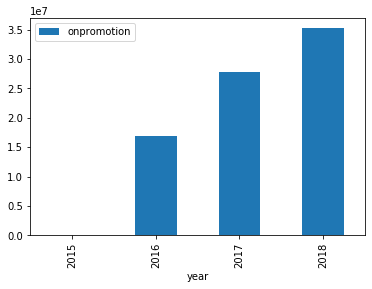

In [0]:
(train.groupby(['year']).agg({'onpromotion':'count'})).plot(kind='bar')

Notice that promotions are application only since 2016. Before 2016, they are not application. 

So, we can impute missing values for promotion (from the year 2015) with False i.e., no promotion.

In [0]:
train.onpromotion.fillna(value=False,inplace=True)

Verify that there are no more NAs in train data

In [0]:
total_NAs(train)

Total NAs: 0


In [0]:
train.year.unique()

[2015, 2016, 2017, 2018]
Categories (4, int64): [2015, 2016, 2017, 2018]

**EDA1: To check if sales are increased when items are sold on discounts/promotions**

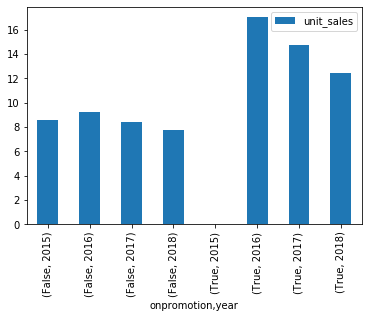

In [0]:
(train.groupby(['onpromotion','year']).agg({'unit_sales':'mean'})).plot(kind='bar')

Sales have increased when promotions are offered.

**EDA2: To get aggregate sales data for each year across all locations**

In [0]:
train_sub1=train.groupby('year').agg({'unit_sales':'sum'})
train_sub1

,unit_sales
year,
2015,140418000.0
2016,209474128.0
2017,240867824.0
2018,288633376.0


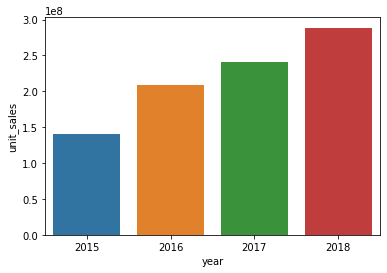

In [0]:
sns.barplot(train_sub1.index,train_sub1.unit_sales)

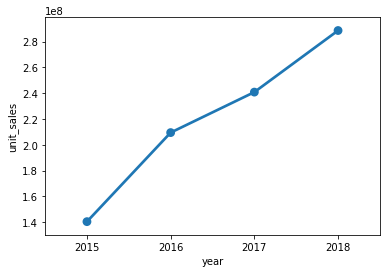

In [0]:
sns.pointplot(train_sub1.index,train_sub1.unit_sales)

In [0]:
train_sub1['Perc_inc']=100*(train_sub1['unit_sales'].pct_change())
train_sub1

,unit_sales,Perc_inc
year,,
2015,140418000.0,NaN
2016,209474128.0,49.178970
2017,240867824.0,14.986908
2018,288633376.0,19.830608


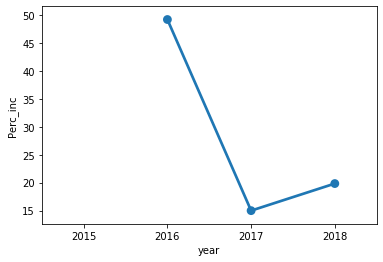

In [0]:
sns.pointplot(train_sub1.iloc[1:,:].index,train_sub1.iloc[1:,:].Perc_inc)

1.  The sum of sales increases over years.
2.  But, the percentage increase doesn't increase.

**Time series plots**

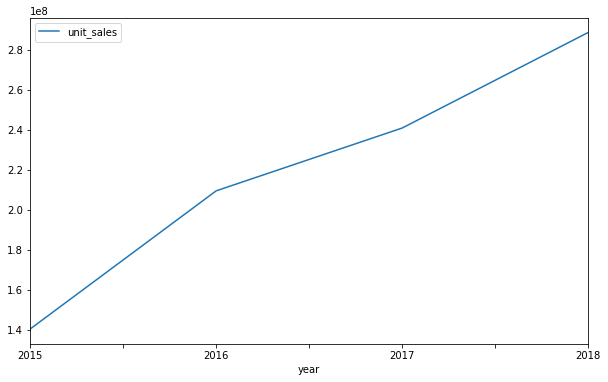

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
(train_sub1).plot(figsize=(10,6))
plt.show()




The above plot with year as index show trend in the data.



In [0]:
del train_sub1
gc.collect()

8607

**EDA3: To get aggregate sales data for each month for each of the 4 years**

In [0]:
train_sub2_2015=train[train.year==2015].groupby('month').agg({'unit_sales':'sum'})
train_sub2_2016=train[train.year==2016].groupby('month').agg({'unit_sales':'sum'})
train_sub2_2017=train[train.year==2017].groupby('month').agg({'unit_sales':'sum'})
train_sub2_2018=train[train.year==2018].groupby('month').agg({'unit_sales':'sum'})

In [0]:
print(train_sub2_2015.shape)
print(train_sub2_2016.shape)
print(train_sub2_2017.shape)
print(train_sub2_2018.shape)

(12, 1)
(12, 1)
(12, 1)
(12, 1)


Top sales across all the months in each of the past 4 years

In [0]:
print(train_sub2_2015.sort_values(by='unit_sales',ascending=False).head(1))
print(train_sub2_2016.sort_values(by='unit_sales',ascending=False).head(1))
print(train_sub2_2017.sort_values(by='unit_sales',ascending=False).head(1))
print(train_sub2_2018.sort_values(by='unit_sales',ascending=False).head(1))

          unit_sales
month               
December  15802362.0
          unit_sales
month               
December  24340448.0
          unit_sales
month               
December  27243976.0
          unit_sales
month               
December  29638204.0


Least sales across all the months in each of the past 4 years

In [0]:
print(train_sub2_2015.sort_values(by='unit_sales',ascending=True).head(1))
print(train_sub2_2016.sort_values(by='unit_sales',ascending=True).head(1))
print(train_sub2_2017.sort_values(by='unit_sales',ascending=True).head(1))
print(train_sub2_2018.sort_values(by='unit_sales',ascending=True).head(1))

          unit_sales
month               
February   9658960.0
          unit_sales
month               
February  12038341.0
          unit_sales
month               
February  13742395.0
          unit_sales
month               
February  21947408.0


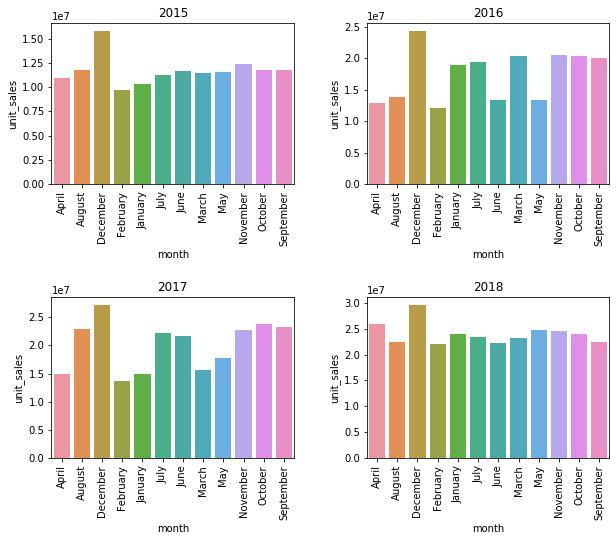

In [0]:
fig,ax = plt.subplots(2,2,figsize=(10,8))
fig.subplots_adjust(wspace=0.3,hspace=0.7)

sns.barplot(train_sub2_2015.index,train_sub2_2015.unit_sales,ax=ax[0][0])
ax[0][0].set_title('2015')
ax[0][0].set_xlabel('month')
ax[0][0].tick_params(axis ='x', rotation = 90)
ax[0][0].set_ylabel('unit_sales')

sns.barplot(train_sub2_2016.index,train_sub2_2016.unit_sales,ax=ax[0][1])
ax[0][1].set_title('2016')
ax[0][1].set_xlabel('month')
ax[0][1].tick_params(axis ='x', rotation = 90)
ax[0][1].set_ylabel('unit_sales')

sns.barplot(train_sub2_2017.index,train_sub2_2017.unit_sales,ax=ax[1][0])
ax[1][0].set_title('2017')
ax[1][0].set_xlabel('month')
ax[1][0].tick_params(axis ='x', rotation = 90)
ax[1][0].set_ylabel('unit_sales')

sns.barplot(train_sub2_2018.index,train_sub2_2018.unit_sales,ax=ax[1][1])
ax[1][1].set_title('2018')
ax[1][1].set_xlabel('month')
ax[1][1].tick_params(axis ='x', rotation = 90)
ax[1][1].set_ylabel('unit_sales')
fig.show()

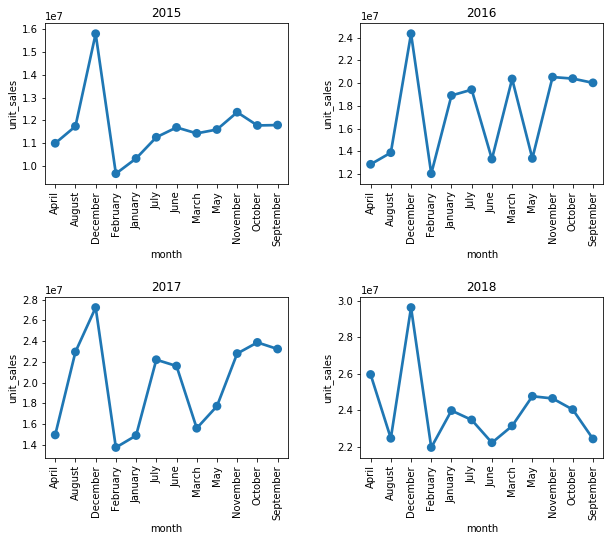

In [0]:
fig,ax = plt.subplots(2,2,figsize=(10,8))
fig.subplots_adjust(wspace=0.3,hspace=0.7)

sns.pointplot(train_sub2_2015.index,train_sub2_2015.unit_sales,ax=ax[0][0])
ax[0][0].set_title('2015')
ax[0][0].set_xlabel('month')
ax[0][0].tick_params(axis ='x', rotation = 90)
ax[0][0].set_ylabel('unit_sales')

sns.pointplot(train_sub2_2016.index,train_sub2_2016.unit_sales,ax=ax[0][1])
ax[0][1].set_title('2016')
ax[0][1].set_xlabel('month')
ax[0][1].tick_params(axis ='x', rotation = 90)
ax[0][1].set_ylabel('unit_sales')

sns.pointplot(train_sub2_2017.index,train_sub2_2017.unit_sales,ax=ax[1][0])
ax[1][0].set_title('2017')
ax[1][0].set_xlabel('month')
ax[1][0].tick_params(axis ='x', rotation = 90)
ax[1][0].set_ylabel('unit_sales')

sns.pointplot(train_sub2_2018.index,train_sub2_2018.unit_sales,ax=ax[1][1])
ax[1][1].set_title('2018')
ax[1][1].set_xlabel('month')
ax[1][1].tick_params(axis ='x', rotation = 90)
ax[1][1].set_ylabel('unit_sales')
fig.show()

The Monthly pattern looks more similar over alternate years.

In [0]:
train_sub2_2015['Perc_inc']=100*(train_sub2_2015['unit_sales'].pct_change())
train_sub2_2016['Perc_inc']=100*(train_sub2_2016['unit_sales'].pct_change())
train_sub2_2017['Perc_inc']=100*(train_sub2_2017['unit_sales'].pct_change())
train_sub2_2018['Perc_inc']=100*(train_sub2_2018['unit_sales'].pct_change())

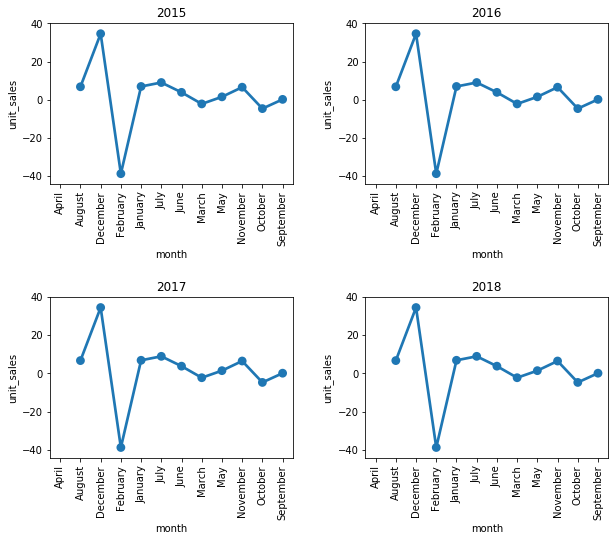

In [0]:
fig,ax = plt.subplots(2,2,figsize=(10,8))
fig.subplots_adjust(wspace=0.3,hspace=0.7)

sns.pointplot(train_sub2_2015.iloc[1:,:].index,train_sub2_2015.iloc[1:,:].Perc_inc,ax=ax[0][0])
ax[0][0].set_title('2015')
ax[0][0].set_xlabel('month')
ax[0][0].tick_params(axis ='x', rotation = 90)
ax[0][0].set_ylabel('unit_sales')

sns.pointplot(train_sub2_2016.iloc[1:,:].index,train_sub2_2015.iloc[1:,:].Perc_inc,ax=ax[0][1],sharey=True)
ax[0][1].set_title('2016')
ax[0][1].set_xlabel('month')
ax[0][1].tick_params(axis ='x', rotation = 90)
ax[0][1].set_ylabel('unit_sales')

sns.pointplot(train_sub2_2017.iloc[1:,:].index,train_sub2_2015.iloc[1:,:].Perc_inc,ax=ax[1][0],sharey=True)
ax[1][0].set_title('2017')
ax[1][0].set_xlabel('month')
ax[1][0].tick_params(axis ='x', rotation = 90)
ax[1][0].set_ylabel('unit_sales')

sns.pointplot(train_sub2_2018.iloc[1:,:].index,train_sub2_2015.iloc[1:,:].Perc_inc,ax=ax[1][1],sharey=True)
ax[1][1].set_title('2018')
ax[1][1].set_xlabel('month')
ax[1][1].tick_params(axis ='x', rotation = 90)
ax[1][1].set_ylabel('unit_sales')
fig.show()



1.   The percentage increase in sales over months is same for all 4 years. 
2.   Looks like a perfect case of additive monthly seasonality across all the 4 years



**Timeseries Plots**

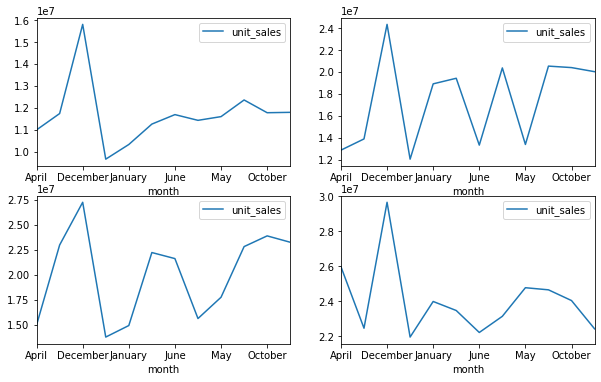

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
fig,ax = plt.subplots(2,2,figsize=(30,15))
train_sub2_2015.plot(figsize=(10,6),ax=ax[0,0])
train_sub2_2016.plot(figsize=(10,6),ax=ax[0,1])
train_sub2_2017.plot(figsize=(10,6),ax=ax[1,0])
train_sub2_2018.plot(figsize=(10,6),ax=ax[1,1])
plt.show()

Though monthly seasonality exists the cycle is repeated for alternate years.

In [0]:
del [[train_sub2_2015,train_sub2_2016,train_sub2_2017,train_sub2_2018]]
gc.collect()

7940

**EDA4: To get aggregate sales data across each day of the week in each of the 12 months over the past 4 years**

In [0]:
train_sub_month1=(train[train.month=='January'].groupby('day').agg({'unit_sales':'sum'}))
train_sub_month2=(train[train.month=='February'].groupby('day').agg({'unit_sales':'sum'}))
train_sub_month3=(train[train.month=='March'].groupby('day').agg({'unit_sales':'sum'}))
train_sub_month4=(train[train.month=='April'].groupby('day').agg({'unit_sales':'sum'}))
train_sub_month5=(train[train.month=='May'].groupby('day').agg({'unit_sales':'sum'}))
train_sub_month6=(train[train.month=='June'].groupby('day').agg({'unit_sales':'sum'}))
train_sub_month7=(train[train.month=='July'].groupby('day').agg({'unit_sales':'sum'}))
train_sub_month8=(train[train.month=='August'].groupby('day').agg({'unit_sales':'sum'}))
train_sub_month9=(train[train.month=='September'].groupby('day').agg({'unit_sales':'sum'}))
train_sub_month10=(train[train.month=='October'].groupby('day').agg({'unit_sales':'sum'}))
train_sub_month11=(train[train.month=='November'].groupby('day').agg({'unit_sales':'sum'}))
train_sub_month12=(train[train.month=='December'].groupby('day').agg({'unit_sales':'sum'}))

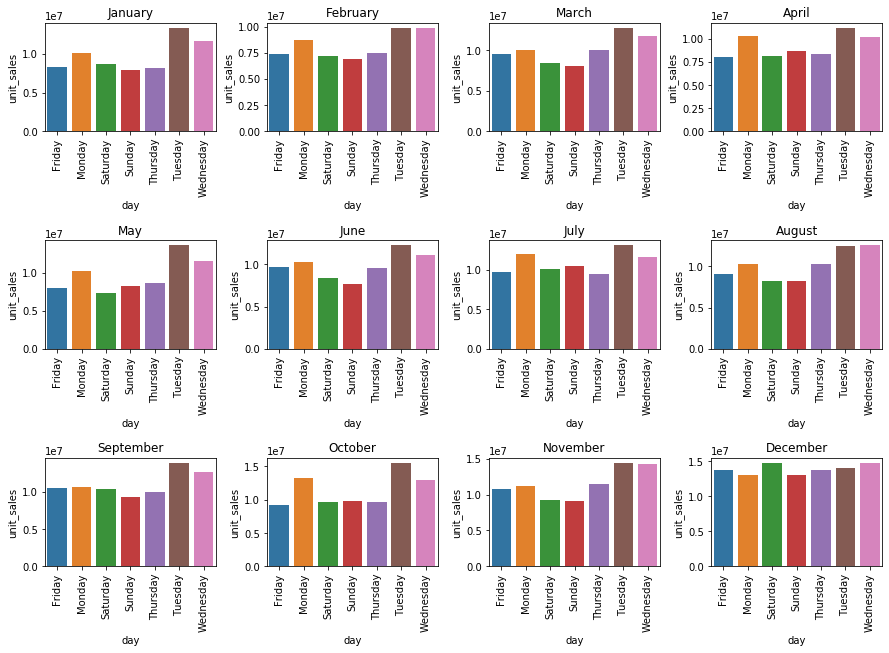

In [0]:
fig,ax = plt.subplots(3,4,figsize=(15,10))
fig.subplots_adjust(wspace=0.3,hspace=1)

sns.barplot(train_sub_month1.index,train_sub_month1.unit_sales,ax=ax[0][0])
ax[0][0].set_title('January')
ax[0][0].set_xlabel('day')
ax[0][0].tick_params(axis ='x', rotation = 90)
ax[0][0].set_ylabel('unit_sales')

sns.barplot(train_sub_month2.index,train_sub_month2.unit_sales,ax=ax[0][1])
ax[0][1].set_title('February')
ax[0][1].set_xlabel('day')
ax[0][1].tick_params(axis ='x', rotation = 90)
ax[0][1].set_ylabel('unit_sales')

sns.barplot(train_sub_month3.index,train_sub_month3.unit_sales,ax=ax[0][2])
ax[0][2].set_title('March')
ax[0][2].set_xlabel('day')
ax[0][2].tick_params(axis ='x', rotation = 90)
ax[0][2].set_ylabel('unit_sales')

sns.barplot(train_sub_month4.index,train_sub_month4.unit_sales,ax=ax[0][3])
ax[0][3].set_title('April')
ax[0][3].set_xlabel('day')
ax[0][3].tick_params(axis ='x', rotation = 90)
ax[0][3].set_ylabel('unit_sales')
fig.show()

sns.barplot(train_sub_month5.index,train_sub_month5.unit_sales,ax=ax[1][0])
ax[1][0].set_title('May')
ax[1][0].set_xlabel('day')
ax[1][0].tick_params(axis ='x', rotation = 90)
ax[1][0].set_ylabel('unit_sales')
fig.show()

sns.barplot(train_sub_month6.index,train_sub_month6.unit_sales,ax=ax[1][1])
ax[1][1].set_title('June')
ax[1][1].set_xlabel('day')
ax[1][1].tick_params(axis ='x', rotation = 90)
ax[1][1].set_ylabel('unit_sales')
fig.show()

sns.barplot(train_sub_month7.index,train_sub_month7.unit_sales,ax=ax[1][2])
ax[1][2].set_title('July')
ax[1][2].set_xlabel('day')
ax[1][2].tick_params(axis ='x', rotation = 90)
ax[1][2].set_ylabel('unit_sales')
fig.show()

sns.barplot(train_sub_month8.index,train_sub_month8.unit_sales,ax=ax[1][3])
ax[1][3].set_title('August')
ax[1][3].set_xlabel('day')
ax[1][3].tick_params(axis ='x', rotation = 90)
ax[1][3].set_ylabel('unit_sales')
fig.show()

sns.barplot(train_sub_month9.index,train_sub_month9.unit_sales,ax=ax[2][0])
ax[2][0].set_title('September')
ax[2][0].set_xlabel('day')
ax[2][0].tick_params(axis ='x', rotation = 90)
ax[2][0].set_ylabel('unit_sales')
fig.show()

sns.barplot(train_sub_month10.index,train_sub_month10.unit_sales,ax=ax[2][1])
ax[2][1].set_title('October')
ax[2][1].set_xlabel('day')
ax[2][1].tick_params(axis ='x', rotation = 90)
ax[2][1].set_ylabel('unit_sales')
fig.show()

sns.barplot(train_sub_month11.index,train_sub_month11.unit_sales,ax=ax[2][2])
ax[2][2].set_title('November')
ax[2][2].set_xlabel('day')
ax[2][2].tick_params(axis ='x', rotation = 90)
ax[2][2].set_ylabel('unit_sales')
fig.show()

sns.barplot(train_sub_month12.index,train_sub_month12.unit_sales,ax=ax[2][3])
ax[2][3].set_title('December')
ax[2][3].set_xlabel('day')
ax[2][3].tick_params(axis ='x', rotation = 90)
ax[2][3].set_ylabel('unit_sales')
fig.show()

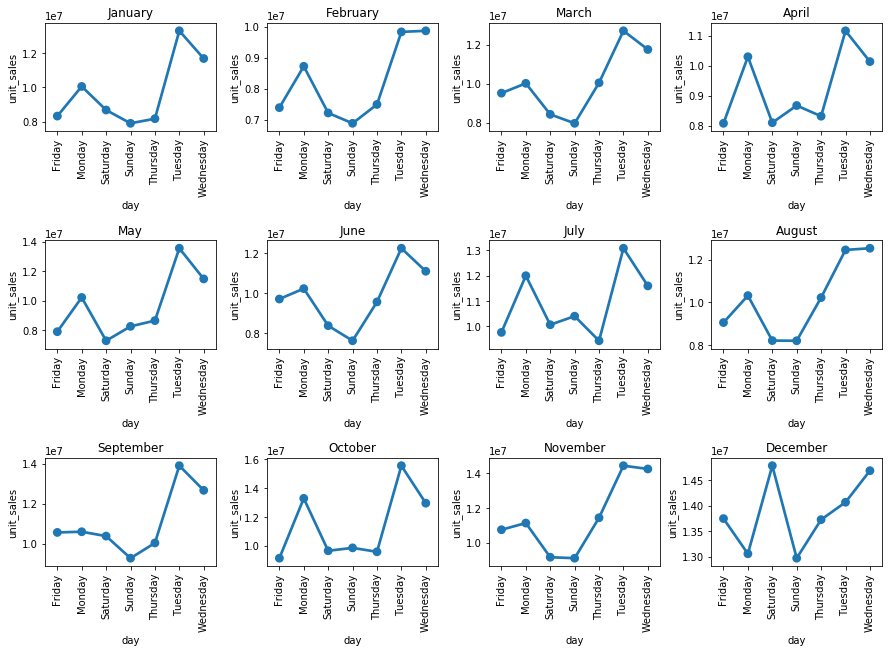

In [0]:
fig,ax = plt.subplots(3,4,figsize=(15,10))
fig.subplots_adjust(wspace=0.3,hspace=1)

sns.pointplot(train_sub_month1.index,train_sub_month1.unit_sales,ax=ax[0][0])
ax[0][0].set_title('January')
ax[0][0].set_xlabel('day')
ax[0][0].tick_params(axis ='x', rotation = 90)
ax[0][0].set_ylabel('unit_sales')

sns.pointplot(train_sub_month2.index,train_sub_month2.unit_sales,ax=ax[0][1])
ax[0][1].set_title('February')
ax[0][1].set_xlabel('day')
ax[0][1].tick_params(axis ='x', rotation = 90)
ax[0][1].set_ylabel('unit_sales')

sns.pointplot(train_sub_month3.index,train_sub_month3.unit_sales,ax=ax[0][2])
ax[0][2].set_title('March')
ax[0][2].set_xlabel('day')
ax[0][2].tick_params(axis ='x', rotation = 90)
ax[0][2].set_ylabel('unit_sales')

sns.pointplot(train_sub_month4.index,train_sub_month4.unit_sales,ax=ax[0][3])
ax[0][3].set_title('April')
ax[0][3].set_xlabel('day')
ax[0][3].tick_params(axis ='x', rotation = 90)
ax[0][3].set_ylabel('unit_sales')
fig.show()

sns.pointplot(train_sub_month5.index,train_sub_month5.unit_sales,ax=ax[1][0])
ax[1][0].set_title('May')
ax[1][0].set_xlabel('day')
ax[1][0].tick_params(axis ='x', rotation = 90)
ax[1][0].set_ylabel('unit_sales')
fig.show()

sns.pointplot(train_sub_month6.index,train_sub_month6.unit_sales,ax=ax[1][1])
ax[1][1].set_title('June')
ax[1][1].set_xlabel('day')
ax[1][1].tick_params(axis ='x', rotation = 90)
ax[1][1].set_ylabel('unit_sales')
fig.show()

sns.pointplot(train_sub_month7.index,train_sub_month7.unit_sales,ax=ax[1][2])
ax[1][2].set_title('July')
ax[1][2].set_xlabel('day')
ax[1][2].tick_params(axis ='x', rotation = 90)
ax[1][2].set_ylabel('unit_sales')
fig.show()

sns.pointplot(train_sub_month8.index,train_sub_month8.unit_sales,ax=ax[1][3])
ax[1][3].set_title('August')
ax[1][3].set_xlabel('day')
ax[1][3].tick_params(axis ='x', rotation = 90)
ax[1][3].set_ylabel('unit_sales')
fig.show()

sns.pointplot(train_sub_month9.index,train_sub_month9.unit_sales,ax=ax[2][0])
ax[2][0].set_title('September')
ax[2][0].set_xlabel('day')
ax[2][0].tick_params(axis ='x', rotation = 90)
ax[2][0].set_ylabel('unit_sales')
fig.show()

sns.pointplot(train_sub_month10.index,train_sub_month10.unit_sales,ax=ax[2][1])
ax[2][1].set_title('October')
ax[2][1].set_xlabel('day')
ax[2][1].tick_params(axis ='x', rotation = 90)
ax[2][1].set_ylabel('unit_sales')
fig.show()

sns.pointplot(train_sub_month11.index,train_sub_month11.unit_sales,ax=ax[2][2])
ax[2][2].set_title('November')
ax[2][2].set_xlabel('day')
ax[2][2].tick_params(axis ='x', rotation = 90)
ax[2][2].set_ylabel('unit_sales')
fig.show()

sns.pointplot(train_sub_month12.index,train_sub_month12.unit_sales,ax=ax[2][3])
ax[2][3].set_title('December')
ax[2][3].set_xlabel('day')
ax[2][3].tick_params(axis ='x', rotation = 90)
ax[2][3].set_ylabel('unit_sales')
fig.show()



1.   Across all the months, top sales are usually seen on Tuesdays.
2.   Least sales are usually seen on Sundays



**Time Series Plots**

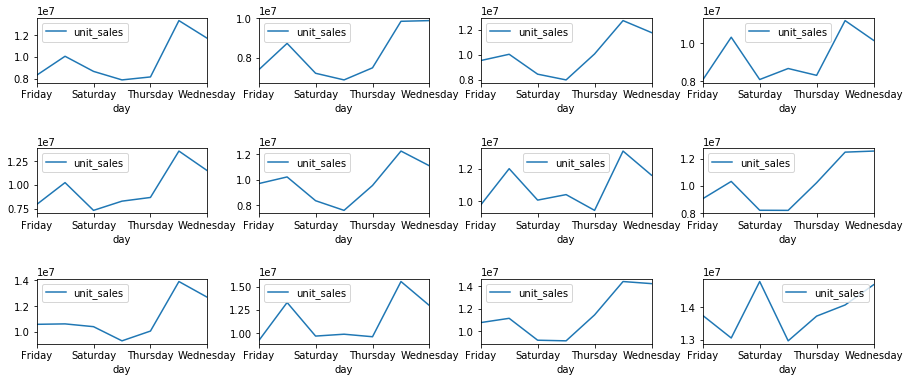

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
fig,ax = plt.subplots(3,4,figsize=(40,20))
fig.subplots_adjust(wspace=0.3,hspace=1)
train_sub_month1.plot(figsize=(15,6),ax=ax[0,0])
train_sub_month2.plot(figsize=(15,6),ax=ax[0,1])
train_sub_month3.plot(figsize=(15,6),ax=ax[0,2])
train_sub_month4.plot(figsize=(15,6),ax=ax[0,3])
train_sub_month5.plot(figsize=(15,6),ax=ax[1,0])
train_sub_month6.plot(figsize=(15,6),ax=ax[1,1])
train_sub_month7.plot(figsize=(15,6),ax=ax[1,2])
train_sub_month8.plot(figsize=(15,6),ax=ax[1,3])
train_sub_month9.plot(figsize=(15,6),ax=ax[2,0])
train_sub_month10.plot(figsize=(15,6),ax=ax[2,1])
train_sub_month11.plot(figsize=(15,6),ax=ax[2,2])
train_sub_month12.plot(figsize=(15,6),ax=ax[2,3])

plt.show()



1.   There is some weekly seasonality.
2.   But it is not as strong as monthly seasonality.



In [0]:
del [[train_sub_month1, train_sub_month2, train_sub_month3, train_sub_month4, train_sub_month5, train_sub_month6, 
train_sub_month7, train_sub_month8, train_sub_month9, train_sub_month10, train_sub_month11, train_sub_month12]]
gc.collect()

32198

**EDA5: To get aggregate sales data across different locations over all 4 years**

In [0]:
train_sub3_2015=train[train.year==2015].groupby('locationId').agg({'unit_sales':'sum'})
train_sub3_2016=train[train.year==2016].groupby('locationId').agg({'unit_sales':'sum'})
train_sub3_2017=train[train.year==2017].groupby('locationId').agg({'unit_sales':'sum'})
train_sub3_2018=train[train.year==2018].groupby('locationId').agg({'unit_sales':'sum'})

In [0]:
print(train_sub3_2015.shape)
print(train_sub3_2016.shape)
print(train_sub3_2017.shape)
print(train_sub3_2018.shape)

(53, 1)
(53, 1)
(53, 1)
(53, 1)


Top sales across different locations over different years

In [0]:
print(train_sub3_2015.sort_values(by='unit_sales',ascending=False).head(5))
print(train_sub3_2016.sort_values(by='unit_sales',ascending=False).head(5))
print(train_sub3_2017.sort_values(by='unit_sales',ascending=False).head(5))
print(train_sub3_2018.sort_values(by='unit_sales',ascending=False).head(5))

             unit_sales
locationId             
location_44   8327322.0
location_45   7098805.5
location_47   6727159.0
location_3    6462661.0
location_46   6241694.5
             unit_sales
locationId             
location_44  13380209.0
location_45  11245712.0
location_47  10455265.0
location_3   10291149.0
location_46   8709582.0
             unit_sales
locationId             
location_44  13524420.0
location_45  11973484.0
location_3   11369221.0
location_47  11320021.0
location_49  10035304.0
             unit_sales
locationId             
location_44  16365473.0
location_45  14524088.0
location_3   13646529.0
location_47  13376745.0
location_49  12692748.0


Least sales across different locations over different years

In [0]:
print(train_sub3_2015.sort_values(by='unit_sales',ascending=True).head(5))
print(train_sub3_2016.sort_values(by='unit_sales',ascending=True).head(5))
print(train_sub3_2017.sort_values(by='unit_sales',ascending=True).head(5))
print(train_sub3_2018.sort_values(by='unit_sales',ascending=True).head(5))

             unit_sales
locationId             
location_20         0.0
location_29         0.0
location_42         0.0
location_22         0.0
location_21         0.0
             unit_sales
locationId             
location_42         0.0
location_29         0.0
location_22         0.0
location_21         0.0
location_20         0.0
               unit_sales
locationId               
location_22  5.126053e+05
location_32  1.235958e+06
location_42  1.564016e+06
location_30  1.643827e+06
location_26  1.644435e+06
              unit_sales
locationId              
location_32  1480657.625
location_26  1756819.250
location_30  1945135.750
location_35  2006838.750
location_22  2060382.250


1.   Top sales across the years are usually seen in the locations - 44, 45, 47, 3, 46 and 49.

1.   Least sales across years are usually seen in the locations - 20, 21, 22, 29, 42, 26, 30, 32 and 42.

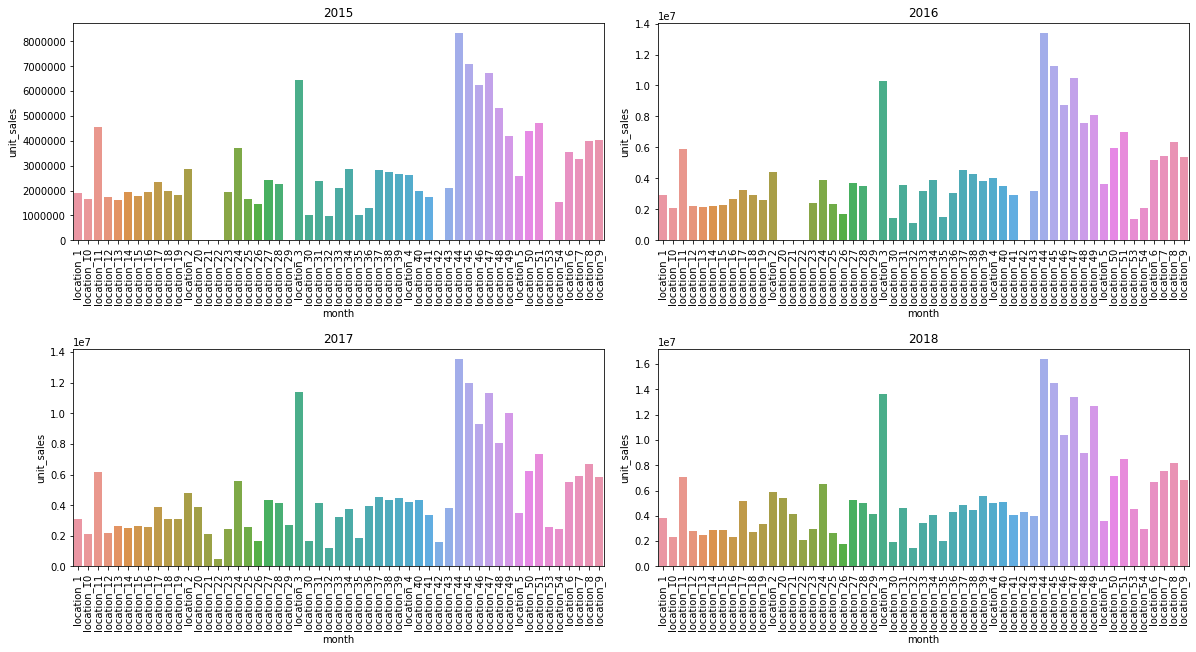

In [0]:
fig,ax = plt.subplots(2,2,figsize=(20,10))
fig.subplots_adjust(wspace=0.1,hspace=0.5)

sns.barplot(train_sub3_2015.index,train_sub3_2015.unit_sales,ax=ax[0][0])
ax[0][0].set_title('2015')
ax[0][0].set_xlabel('month')
ax[0][0].tick_params(axis ='x', rotation = 90)
ax[0][0].set_ylabel('unit_sales')

sns.barplot(train_sub3_2016.index,train_sub3_2016.unit_sales,ax=ax[0][1])
ax[0][1].set_title('2016')
ax[0][1].set_xlabel('month')
ax[0][1].tick_params(axis ='x', rotation = 90)
ax[0][1].set_ylabel('unit_sales')

sns.barplot(train_sub3_2017.index,train_sub3_2017.unit_sales,ax=ax[1][0])
ax[1][0].set_title('2017')
ax[1][0].set_xlabel('month')
ax[1][0].tick_params(axis ='x', rotation = 90)
ax[1][0].set_ylabel('unit_sales')

sns.barplot(train_sub3_2018.index,train_sub3_2018.unit_sales,ax=ax[1][1])
ax[1][1].set_title('2018')
ax[1][1].set_xlabel('month')
ax[1][1].tick_params(axis ='x', rotation = 90)
ax[1][1].set_ylabel('unit_sales')

fig.show()

The overall sales pattern is uniform across different locations over the past 4 years.



In [0]:
del [[train_sub3_2015, train_sub3_2016, train_sub3_2017, train_sub3_2018]]
gc.collect()

572

**EDA6: To get monthly aggregate sales data across all the locations in the past 4 years**

In [0]:
train_sub4=train.groupby('month_years').agg({'unit_sales':'sum'})

In [0]:
train_sub5.shape

(48, 1)

Top unit sales across each month of all the 4 years i.e., across 12*4 = 48 months

In [0]:
train_sub4.sort_values(by='unit_sales',ascending=False).head(10)

,unit_sales
month_years,
2018-12,29638204.0
2017-12,27243976.0
2018-04,25960078.0
2018-05,24763406.0
2018-11,24642578.0
2016-12,24340448.0
2018-10,24030388.0
2018-01,23977786.0
2017-10,23878262.0


Least unit sales across each month of all the 4 years i.e., across 12*4 = 48 months

In [0]:
train_sub4.sort_values(by='unit_sales',ascending=True).head(10)

,unit_sales
month_years,
2015-02,9658960.0
2015-01,10327412.0
2015-04,10993463.0
2015-07,11257399.0
2015-03,11428497.0
2015-05,11597702.0
2015-06,11689336.0
2015-08,11737788.0
2015-10,11775619.0


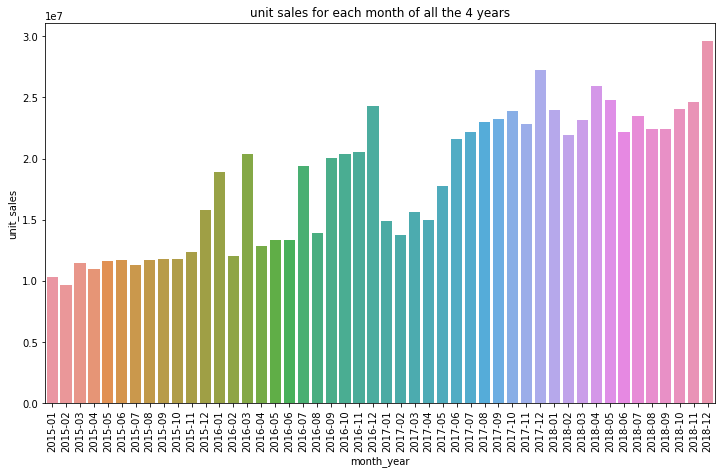

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,7))
sns.barplot(train_sub4.index,train_sub4.unit_sales)
plt.xlabel('month_year')
plt.xticks(rotation='vertical')
plt.ylabel('unit_sales',)
plt.title('unit sales for each month of all the 4 years')
plt.show()

Notice that there is an increase in sales over years, with some monthly fluctuations.

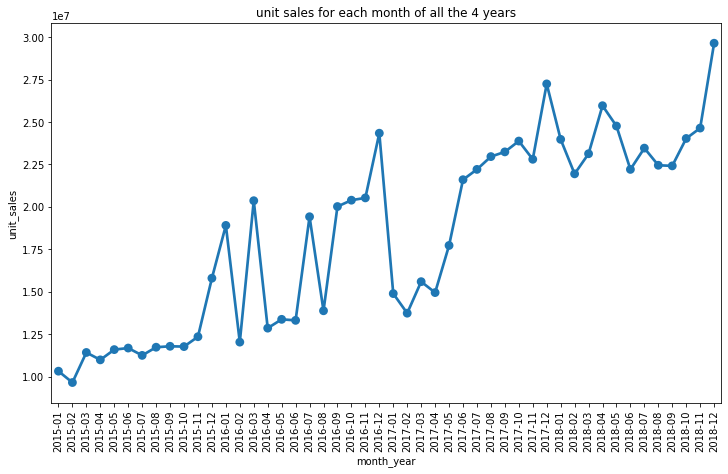

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,7))
sns.pointplot(train_sub4.index,train_sub4.unit_sales)
plt.xlabel('month_year')
plt.xticks(rotation='vertical')
plt.ylabel('unit_sales',)
plt.title('unit sales for each month of all the 4 years')
plt.show()

Clearly there is yearly treand with monthly seasonality in the data.

**Time series plots**

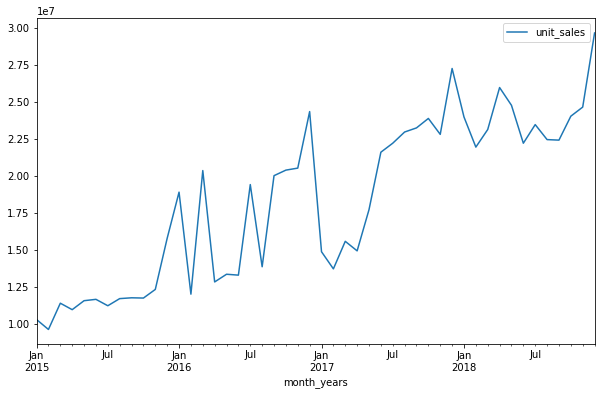

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
(train_sub4).plot(figsize=(10,6))
plt.show()

This is a strong indication of trend over 4 years and seasonality across months.

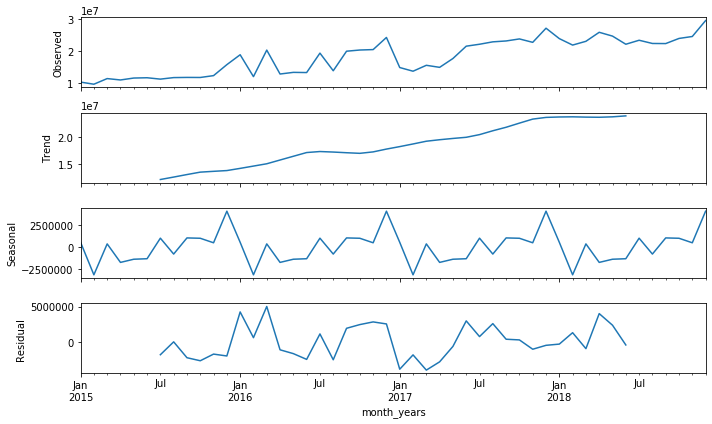

In [0]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 10, 6
decomposition = sm.tsa.seasonal_decompose(train_sub4, model = 'additive', freq= 12)
fig = decomposition.plot()
plt.show()



1.   The train data can be decomposed into trend, seasonality and random noise.
2.   Seasonality looks more like additive seasonality.



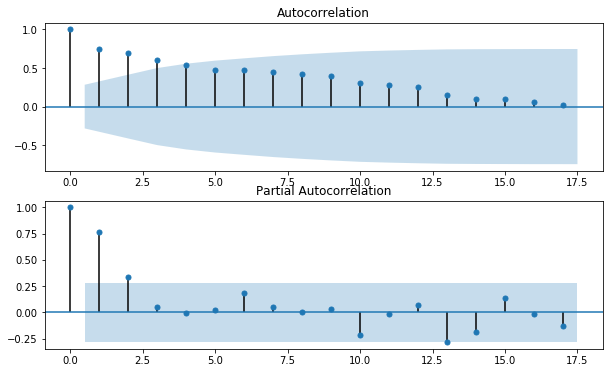

In [0]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
plt.subplot(211)
plot_acf(train_sub4, ax=plt.gca())
plt.subplot(212)
plot_pacf(train_sub4, ax=plt.gca())
plt.show()



1.   ACF plots indicate bars decaying gradually over lags which is an indication of trend in the data.
2.   PACF shows cyclicity which is an indication of seasonality in the data.



In [0]:
del [train_sub4]
gc.collect()

563

**Loading item details data**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD")
item_details=import_other_data('item_details.csv')

Memory usage of dataframe is 0.13 MB
Memory usage after optimization is: 0.22 MB
Decreased by -79.6%


**Loading location details data**

In [0]:
location_details=import_other_data('location_details.csv')

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by -125.1%


**Understanding item_details data**

In [0]:
understand_data(item_details)

,Datatype,No of NAs,No of Levels,Levels
item_id,category,0,4100,"[item_96995, item_99197, item_103501, item_103..."
category_of_item,category,0,30,"[grocery_items, cleaning_utilities, baked_item..."
class,category,0,337,"[class_1093, class_1067, class_3008, class_102..."
perishable,int8,0,2,[0 1]


**Understanding location_details data**

In [0]:
understand_data(location_details)

,Datatype,No of NAs,No of Levels,Levels
location_id,category,0,54,"[location_1, location_2, location_3, location_..."
city,category,0,22,"[Bengaluru, Delhi, Kolkata, Noida, Vijayawada,..."
state,category,0,13,"[Karnataka, NCR, West Bengal, Uttar Pradesh, C..."
type,category,0,5,"[D, B, C, E, A]\nCategories (5, object): [D, B..."
cluster,int8,0,17,[13 8 9 4 6 15 7 3 12 16 1 10 2 5 11 ...


**check total NAs in item_details data**

In [0]:
total_NAs(item_details)

Total NAs: 0


**check total NAs in location_details data**

In [0]:
total_NAs(location_details)

Total NAs: 0


There are no NAs in both the datasets.

**Check for any duplicate records in item_details, location_details**

In [0]:
item_details[item_details.item_id.duplicated(keep = False)].sort_values('item_id')

,item_id,category_of_item,class,perishable


In [0]:
location_details[location_details.location_id.duplicated(keep = False)].sort_values('location_id')

,location_id,city,state,type,cluster


**Joining datasets**

In [0]:
train.columns

Index(['date', 'locationId', 'item_id', 'unit_sales', 'onpromotion', 'day',
       'month', 'year', 'month_years'],
      dtype='object')

In [0]:
item_details.columns

Index(['item_id', 'category_of_item', 'class', 'perishable'], dtype='object')

In [0]:
location_details.columns

Index(['location_id', 'city', 'state', 'type', 'cluster'], dtype='object')

**Changing the mismatched column names to perform join**

In [0]:
location_details.columns=[x.replace('location_id','locationId') for x in location_details.columns]

**Joining train, item_details dataframes**

In [0]:
merged_data1=train.merge(item_details,how='left',on=['item_id'])

In [0]:
total_NAs(merged_data1)

Total NAs: 0


In [0]:
print(train.shape);print(merged_data1.shape)

(101688779, 9)
(101688779, 12)


In [0]:
merged_data1.columns

Index(['date', 'locationId', 'item_id', 'unit_sales', 'onpromotion', 'day',
       'month', 'year', 'month_years', 'category_of_item', 'class',
       'perishable'],
      dtype='object')

In [0]:
merged_data1.head()

,date,locationId,item_id,unit_sales,onpromotion,day,month,year,month_years,category_of_item,class,perishable
0,2015-01-01,location_25,item_103665,7.0,False,Thursday,January,2015,2015-01,baked_items / bread_based,class_2712,1
1,2015-01-01,location_25,item_105574,1.0,False,Thursday,January,2015,2015-01,grocery_items,class_1045,0
2,2015-01-01,location_25,item_105575,2.0,False,Thursday,January,2015,2015-01,grocery_items,class_1045,0
3,2015-01-01,location_25,item_108079,1.0,False,Thursday,January,2015,2015-01,grocery_items,class_1030,0
4,2015-01-01,location_25,item_108701,1.0,False,Thursday,January,2015,2015-01,deli_items,class_2644,1


In [0]:
gc.collect()

0

**Joining train, item_details dataframes and location_details**

In [0]:
merged_data1=merged_data1.merge(location_details,how='left',on=['locationId'])

In [0]:
total_NAs(merged_data1)

Total NAs: 0


In [0]:
print(merged_data1.shape)

(101688779, 16)


In [0]:
merged_data1.columns

Index(['date', 'locationId', 'item_id', 'unit_sales', 'onpromotion', 'day',
       'month', 'year', 'month_years', 'category_of_item', 'class',
       'perishable', 'city', 'state', 'type', 'cluster'],
      dtype='object')

In [0]:
merged_data1.head()

,date,locationId,item_id,unit_sales,onpromotion,day,month,year,month_years,category_of_item,class,perishable,city,state,type,cluster
0,2015-01-01,location_25,item_103665,7.0,False,Thursday,January,2015,2015-01,baked_items / bread_based,class_2712,1,Kanpur,Uttar Pradesh,D,1
1,2015-01-01,location_25,item_105574,1.0,False,Thursday,January,2015,2015-01,grocery_items,class_1045,0,Kanpur,Uttar Pradesh,D,1
2,2015-01-01,location_25,item_105575,2.0,False,Thursday,January,2015,2015-01,grocery_items,class_1045,0,Kanpur,Uttar Pradesh,D,1
3,2015-01-01,location_25,item_108079,1.0,False,Thursday,January,2015,2015-01,grocery_items,class_1030,0,Kanpur,Uttar Pradesh,D,1
4,2015-01-01,location_25,item_108701,1.0,False,Thursday,January,2015,2015-01,deli_items,class_2644,1,Kanpur,Uttar Pradesh,D,1


In [0]:
print(merged_data1.memory_usage().sum() / 1024**2)
merged_data1=optimize_floats(merged_data1)
merged_data1=optimize_ints(merged_data1)
merged_data1=optimize_objects(merged_data1,[])
merged_data1=optimize(merged_data1)
print(merged_data1.memory_usage().sum() / 1024**2)

5527.760989189148
4267.236064910889


**Taking backup of merged data**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
create_backupfiles('merged_data1',merged_data1)

**Verify whether the backup files are created**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
print(os.getcwd())
!ls -lrt

/content/drive/My Drive/PHD/MemoryReducedFiles
total 7150177
-rw------- 1 root root 2847374947 Feb 14 07:44 train
-rw------- 1 root root 4474405752 Feb 14 07:49 merged_data1


**Restore backedup merged data**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
merged_data1=reload_backupfiles('merged_data1')

In [0]:
del [[train, item_details, location_details]]
gc.collect()

65

**EDA7: To get the clusters with top and least sales for each year**

In [0]:
train_sub5=merged_data1.groupby(['year','cluster']).agg({'unit_sales':'sum'}).reset_index()
train_sub5

,year,cluster,unit_sales
0,2015,1,7789934.00
1,2015,2,2835043.00
2,2015,3,10547868.00
3,2015,4,7060762.00
4,2015,5,8327322.00
...,...,...,...
63,2018,13,20866328.00
64,2018,14,39856096.00
65,2018,15,13840134.00
66,2018,16,2690695.75


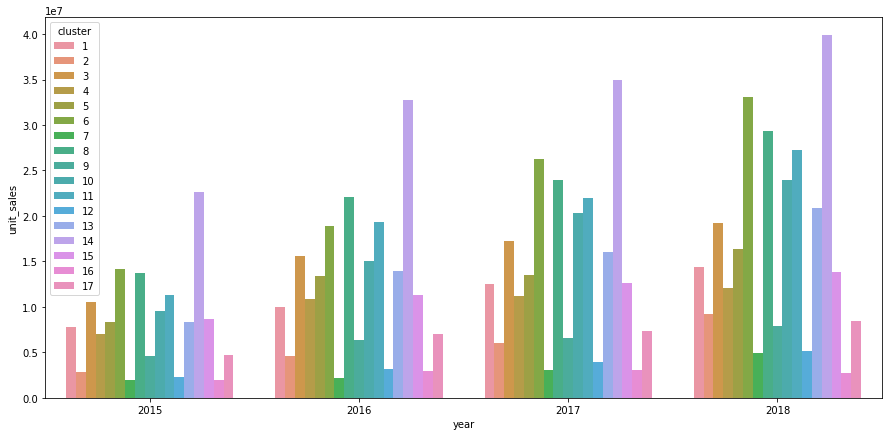

In [0]:
plt.figure(figsize=(15,7))
sns.barplot(x='year',y='unit_sales',hue='cluster',data=train_sub5)

Cluster 14 recorded higheset sales across all the 4 years.

In [0]:
print("\n5 top sales clusters in 2015\n")
print(train_sub5[train_sub5.year==2015].sort_values(by='unit_sales',ascending=False).head(5))
print("\n5 least sales clusters in 2015\n")
print(train_sub5[train_sub5.year==2015].sort_values(by='unit_sales',ascending=True).head(5))


5 top sales clusters in 2015

    year  cluster  unit_sales
13  2015       14  22683306.0
5   2015        6  14131531.0
7   2015        8  13743734.0
10  2015       11  11284051.0
2   2015        3  10547868.0

5 least sales clusters in 2015

    year  cluster   unit_sales
6   2015        7  1950353.625
15  2015       16  1970772.625
11  2015       12  2334355.750
1   2015        2  2835043.000
8   2015        9  4557808.000


In [0]:
print("\n5 top sales clusters in 2016\n")
print(train_sub5[train_sub5.year==2016].sort_values(by='unit_sales',ascending=False).head(5))
print("\n5 least sales clusters in 2016\n")
print(train_sub5[train_sub5.year==2016].sort_values(by='unit_sales',ascending=True).head(5))


5 top sales clusters in 2016

    year  cluster  unit_sales
30  2016       14  32707608.0
24  2016        8  22100780.0
27  2016       11  19368254.0
22  2016        6  18910922.0
19  2016        3  15579945.0

5 least sales clusters in 2016

    year  cluster  unit_sales
23  2016        7  2203211.75
32  2016       16  2935647.75
28  2016       12  3215758.00
18  2016        2  4550328.50
25  2016        9  6405619.50


In [0]:
print("\n5 top sales clusters in 2017\n")
print(train_sub5[train_sub5.year==2017].sort_values(by='unit_sales',ascending=False).head(5))
print("\n5 least sales clusters in 2017\n")
print(train_sub5[train_sub5.year==2017].sort_values(by='unit_sales',ascending=True).head(5))


5 top sales clusters in 2017

    year  cluster  unit_sales
47  2017       14  34945692.0
39  2017        6  26259316.0
41  2017        8  23980804.0
44  2017       11  22008788.0
43  2017       10  20361260.0

5 least sales clusters in 2017

    year  cluster  unit_sales
40  2017        7   3038044.5
49  2017       16   3075841.5
45  2017       12   3912243.5
35  2017        2   6069823.5
42  2017        9   6625983.0


In [0]:
print("\n5 top sales clusters in 2018\n")
print(train_sub5[train_sub5.year==2018].sort_values(by='unit_sales',ascending=False).head(5))
print("\n5 least sales clusters in 2018\n")
print(train_sub5[train_sub5.year==2018].sort_values(by='unit_sales',ascending=True).head(5))


5 top sales clusters in 2018

    year  cluster  unit_sales
64  2018       14  39856096.0
56  2018        6  33047686.0
58  2018        8  29358830.0
61  2018       11  27216836.0
60  2018       10  23926146.0

5 least sales clusters in 2018

    year  cluster  unit_sales
66  2018       16  2690695.75
57  2018        7  4902007.00
62  2018       12  5201351.50
59  2018        9  7939334.50
67  2018       17  8489286.00


In [0]:
train_sub5_2015=(train_sub5[train_sub5.year==2016].sort_values(by='unit_sales',ascending=False).head(5)).set_index('cluster')
train_sub5_2016=(train_sub5[train_sub5.year==2016].sort_values(by='unit_sales',ascending=False).head(5)).set_index('cluster')
train_sub5_2017=(train_sub5[train_sub5.year==2017].sort_values(by='unit_sales',ascending=False).head(5)).set_index('cluster')
train_sub5_2018=(train_sub5[train_sub5.year==2018].sort_values(by='unit_sales',ascending=False).head(5)).set_index('cluster')

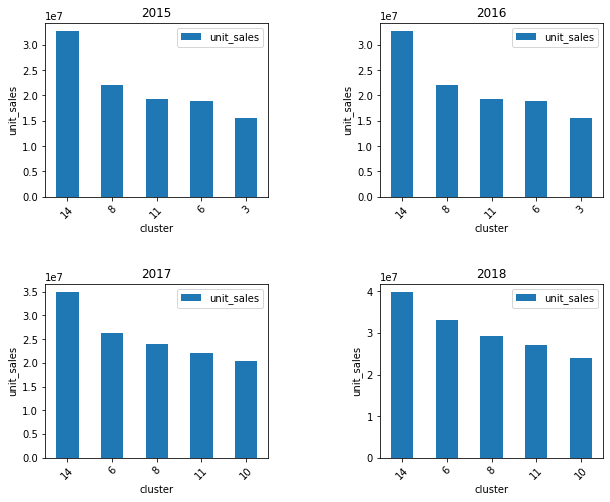

In [0]:
fig,ax = plt.subplots(2,2,figsize=(10,8))
fig.subplots_adjust(wspace=0.5,hspace=0.5)

(train_sub5_2015).plot(kind='bar',ax=ax[0][0])
ax[0][0].set_title('2015')
ax[0][0].set_xlabel('cluster')
ax[0][0].tick_params(axis ='x', rotation = 45)
ax[0][0].set_ylabel('unit_sales')

(train_sub5_2016).plot(kind='bar',ax=ax[0][1])
ax[0][1].set_title('2016')
ax[0][1].set_xlabel('cluster')
ax[0][1].tick_params(axis ='x', rotation = 45)
ax[0][1].set_ylabel('unit_sales')

(train_sub5_2017).plot(kind='bar',ax=ax[1][0])
ax[1][0].set_title('2017')
ax[1][0].set_xlabel('cluster')
ax[1][0].tick_params(axis ='x', rotation = 45)
ax[1][0].set_ylabel('unit_sales')

(train_sub5_2018).plot(kind='bar',ax=ax[1][1])
ax[1][1].set_title('2018')
ax[1][1].set_xlabel('cluster')
ax[1][1].tick_params(axis ='x', rotation = 45)
ax[1][1].set_ylabel('unit_sales')

fig.show()

Max sales are mostly from the same clusters across 4 years.
Min sales are mostly from the same customers across 4 years.

In [0]:
del [[train_sub5,train_sub5_2015,train_sub5_2016,train_sub5_2017, train_sub5_2018]]
gc.collect()

76178

**EDA8: To get the business unit that recorded maximum sales over all the 4 years.**

In [0]:
train_sub6=merged_data1.groupby(['year','cluster','type']).agg({'unit_sales':'sum'}).reset_index().dropna()
train_sub6.head()

,year,cluster,type,unit_sales
3,2015,1,D,7789934.0
8,2015,2,D,2835043.0
12,2015,3,C,10547868.0
18,2015,4,D,7060762.0
20,2015,5,A,8327322.0


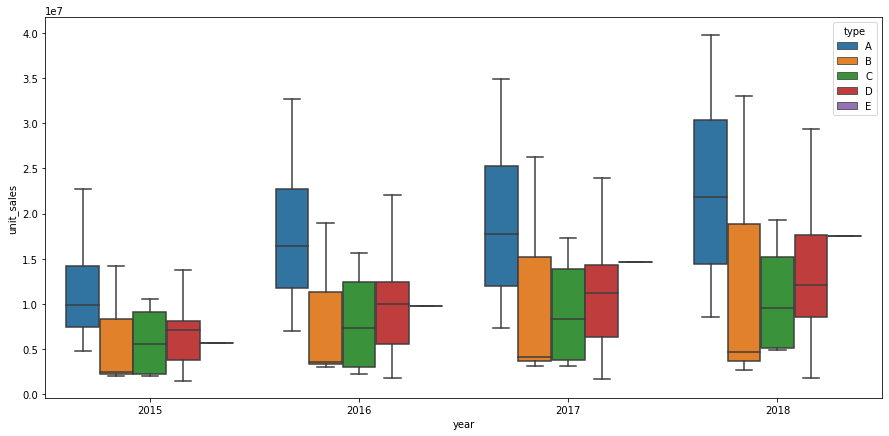

In [0]:
plt.figure(figsize=(15,7))
sns.boxplot(x='year',y='unit_sales',hue='type',data=train_sub6)

Business unit A accounts to highest sales across all the 4 years.

**EDA9: To know the business unit with top sales across all the clusters**

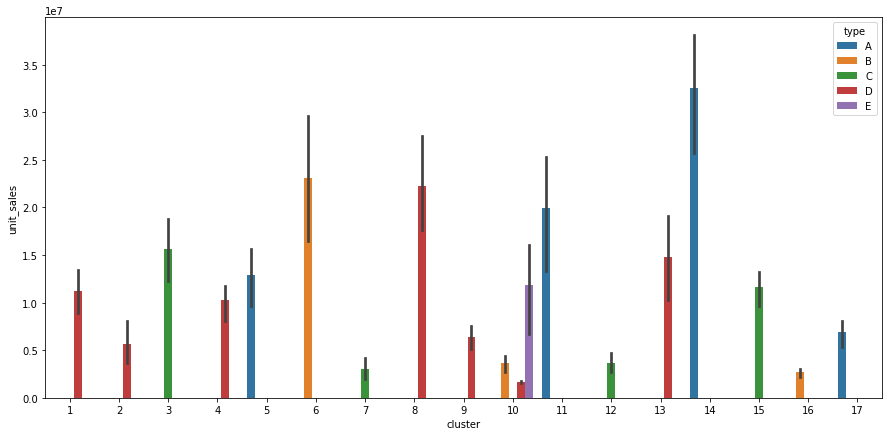

In [0]:
plt.figure(figsize=(15,7))
sns.barplot(x='cluster',y='unit_sales',hue='type',data=train_sub6)

Business units of type 'A' belonging to cluster 14 have recorded maximum sales.

In [0]:
del train_sub6
gc.collect()

359

**EDA10: To get the average unit sales of each item category per Business unit**

<Figure size 864x1296 with 0 Axes>

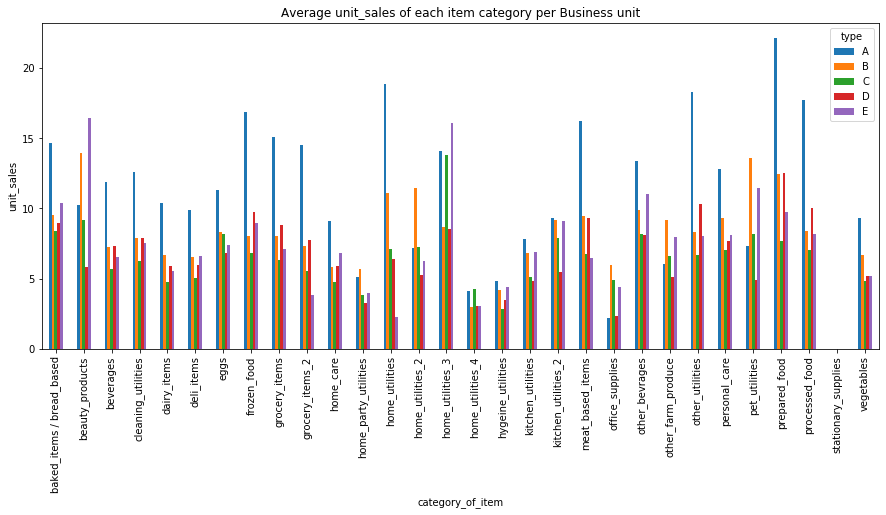

In [0]:
merged_data1.groupby(['category_of_item','type'])['unit_sales'].mean().unstack().plot(kind = 'bar', figsize = (15,6))
plt.title('Average unit_sales of each item category per Business unit')
plt.ylabel('unit_sales')

Prepared_food items in business unit A has highest mean sales.

**EDA 11: To get the most sold items and least sold items for each year**

In [0]:
train_sub7=merged_data1.groupby(['year','category_of_item']).agg({'unit_sales':'sum'}).reset_index().dropna()
train_sub7

,year,category_of_item,unit_sales
0,2015,baked_items / bread_based,6.992152e+06
1,2015,beauty_products,4.737100e+04
2,2015,beverages,2.177788e+07
3,2015,cleaning_utilities,1.751452e+07
4,2015,dairy_items,7.738440e+06
...,...,...,...
115,2018,pet_utilities,1.299930e+05
116,2018,prepared_food,2.069074e+06
117,2018,processed_food,4.574580e+05
118,2018,stationary_supplies,4.119000e+03


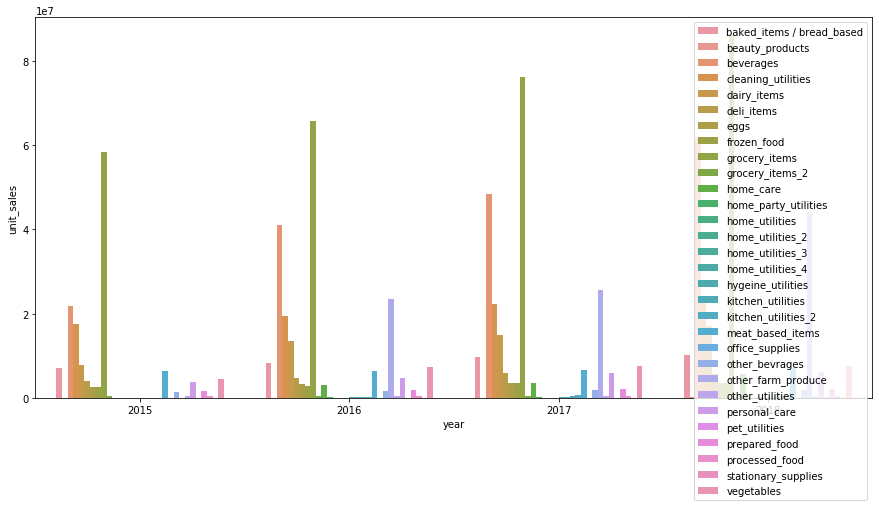

In [0]:
plt.figure(figsize=(15,7))
sns.barplot(x='year',y='unit_sales',hue='category_of_item',data=train_sub7)
plt.legend(loc='upper right')

Notice that grocerry items are sold the most in all the years.

In [0]:
print("\n5 top sales item categories in 2015\n")
print(train_sub7[train_sub7.year==2015].sort_values(by='unit_sales',ascending=False).head(5))
print("\n5 least sales item categories in 2015\n")
print(train_sub7[train_sub7.year==2015].sort_values(by='unit_sales',ascending=True).head(5))


5 top sales item categories in 2015

   year           category_of_item  unit_sales
8  2015              grocery_items  58339628.0
2  2015                  beverages  21777880.0
3  2015         cleaning_utilities  17514516.0
4  2015                dairy_items   7738440.0
0  2015  baked_items / bread_based   6992152.0

5 least sales item categories in 2015

    year    category_of_item  unit_sales
12  2015      home_utilities      9770.0
1   2015     beauty_products     47371.0
22  2015  other_farm_produce     72800.0
23  2015     other_utilities    325657.0
9   2015     grocery_items_2    376877.0


In [0]:
print("\n5 top sales item categories in 2016\n")
print(train_sub7[train_sub7.year==2016].sort_values(by='unit_sales',ascending=False).head(5))
print("\n5 least item categories in 2016\n")
print(train_sub7[train_sub7.year==2016].sort_values(by='unit_sales',ascending=True).head(5))


5 top sales item categories in 2016

    year    category_of_item  unit_sales
38  2016       grocery_items  65666792.0
32  2016           beverages  41050432.0
52  2016  other_farm_produce  23512528.0
33  2016  cleaning_utilities  19497600.0
34  2016         dairy_items  13491785.0

5 least item categories in 2016

    year  category_of_item  unit_sales
44  2016  home_utilities_3       619.0
42  2016    home_utilities      9125.0
43  2016  home_utilities_2     14945.0
50  2016   office_supplies     31985.0
31  2016   beauty_products     55607.0


In [0]:
print("\n5 top sales item categories in 2017\n")
print(train_sub7[train_sub7.year==2017].sort_values(by='unit_sales',ascending=False).head(5))
print("\n5 least item categories in 2017\n")
print(train_sub7[train_sub7.year==2017].sort_values(by='unit_sales',ascending=True).head(5))


5 top sales item categories in 2017

    year    category_of_item  unit_sales
68  2017       grocery_items  76228536.0
62  2017           beverages  48413656.0
82  2017  other_farm_produce  25595844.0
63  2017  cleaning_utilities  22381432.0
64  2017         dairy_items  14834138.0

5 least item categories in 2017

    year  category_of_item  unit_sales
74  2017  home_utilities_3      1529.0
72  2017    home_utilities      9149.0
80  2017   office_supplies     43337.0
73  2017  home_utilities_2     48376.0
85  2017     pet_utilities     62783.0


In [0]:
print("\n5 top sales item categories in 2018\n")
print(train_sub7[train_sub7.year==2018].sort_values(by='unit_sales',ascending=False).head(5))
print("\n5 least item categories in 2018\n")
print(train_sub7[train_sub7.year==2018].sort_values(by='unit_sales',ascending=True).head(5))


5 top sales item categories in 2018

     year    category_of_item  unit_sales
98   2018       grocery_items  86085832.0
92   2018           beverages  61747688.0
112  2018  other_farm_produce  44248100.0
93   2018  cleaning_utilities  22626036.0
94   2018         dairy_items  16967192.0

5 least item categories in 2018

     year     category_of_item  unit_sales
118  2018  stationary_supplies      4119.0
104  2018     home_utilities_3      5166.0
102  2018       home_utilities      6528.0
110  2018      office_supplies     81214.0
91   2018      beauty_products     99478.0


In [0]:
train_sub7_2015=(train_sub7[train_sub7.year==2016].sort_values(by='unit_sales',ascending=False).head(5)).set_index('category_of_item')
train_sub7_2016=(train_sub7[train_sub7.year==2016].sort_values(by='unit_sales',ascending=False).head(5)).set_index('category_of_item')
train_sub7_2017=(train_sub7[train_sub7.year==2017].sort_values(by='unit_sales',ascending=False).head(5)).set_index('category_of_item')
train_sub7_2018=(train_sub7[train_sub7.year==2018].sort_values(by='unit_sales',ascending=False).head(5)).set_index('category_of_item')

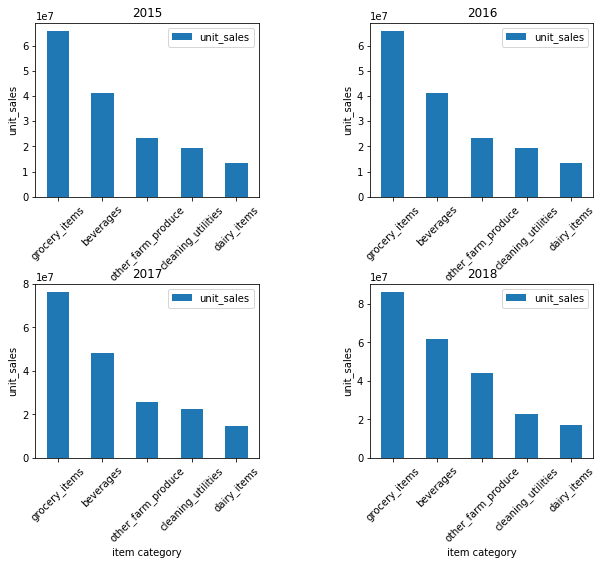

In [0]:
fig,ax = plt.subplots(2,2,figsize=(10,8))
fig.subplots_adjust(wspace=0.5,hspace=0.5)

(train_sub7_2015).plot(kind='bar',ax=ax[0][0])
ax[0][0].set_title('2015')
ax[0][0].set_xlabel('item category')
ax[0][0].tick_params(axis ='x', rotation = 45)
ax[0][0].set_ylabel('unit_sales')

(train_sub7_2016).plot(kind='bar',ax=ax[0][1])
ax[0][1].set_title('2016')
ax[0][1].set_xlabel('item category')
ax[0][1].tick_params(axis ='x', rotation = 45)
ax[0][1].set_ylabel('unit_sales')

(train_sub7_2017).plot(kind='bar',ax=ax[1][0])
ax[1][0].set_title('2017')
ax[1][0].set_xlabel('item category')
ax[1][0].tick_params(axis ='x', rotation = 45)
ax[1][0].set_ylabel('unit_sales')

(train_sub7_2018).plot(kind='bar',ax=ax[1][1])
ax[1][1].set_title('2018')
ax[1][1].set_xlabel('item category')
ax[1][1].tick_params(axis ='x', rotation = 45)
ax[1][1].set_ylabel('unit_sales')

fig.show()

Notice that groceries, beverages, dairy products, farm produces and cleaning utensils are sold the most in all the 4 years. Small basket should make sure these products supply meet the existing high demand. 

They should also make sure that items with least sales are not stocked in surplus.

In [0]:
del [[train_sub7,train_sub7_2015,train_sub7_2016,train_sub7_2017,train_sub7_2018]]
gc.collect()

367

Top sales are mostly amongst same class i.e., group of items across the 4 years

**EDA 12: Cities which recorded high sales for each item categories for each year**

In [0]:
train_sub8=merged_data1.groupby(['year','city','category_of_item']).agg({'unit_sales':'sum'}).reset_index().dropna()
train_sub8

,year,city,category_of_item,unit_sales
0,2015,Ahmedabad,baked_items / bread_based,55556.000000
1,2015,Ahmedabad,beauty_products,861.000000
2,2015,Ahmedabad,beverages,238702.000000
3,2015,Ahmedabad,cleaning_utilities,283591.000000
4,2015,Ahmedabad,dairy_items,52424.000000
...,...,...,...,...
2634,2018,Visakhapatnam,personal_care,33038.000000
2635,2018,Visakhapatnam,pet_utilities,190.000000
2636,2018,Visakhapatnam,prepared_food,7179.000000
2637,2018,Visakhapatnam,processed_food,163.000000


In [0]:
print("\n5 top selling item categories across each city in 2015\n")
print(train_ts_sub8[train_ts_sub8.year==2015].sort_values(by='unit_sales',ascending=False).head(5))
print("\n5 least selling item categories across each city city in 2015\n")
print(train_ts_sub8[train_ts_sub8.year==2015].sort_values(by='unit_sales',ascending=True).head(5))


5 top selling item categories across each city in 2015

     year       city    category_of_item  unit_sales
38   2015  Bengaluru       grocery_items  28547148.0
32   2015  Bengaluru           beverages  11751911.0
33   2015  Bengaluru  cleaning_utilities   8401066.0
398  2015     Mumbai       grocery_items   6867537.0
34   2015  Bengaluru         dairy_items   4618543.0

5 least selling item categories across each city city in 2015

     year           city category_of_item  unit_sales
282  2015         Indore   home_utilities        53.0
192  2015         Guntur   home_utilities        60.0
631  2015  Visakhapatnam  beauty_products        61.0
102  2015     Coimbatore   home_utilities        70.0
642  2015  Visakhapatnam   home_utilities        71.0


In [0]:
print("\n5 top selling item categories across each city in 2016\n")
print(train_ts_sub8[train_ts_sub8.year==2016].sort_values(by='unit_sales',ascending=False).head(5))
print("\n5 least selling item categories across each city in 2016\n")
print(train_ts_sub8[train_ts_sub8.year==2016].sort_values(by='unit_sales',ascending=True).head(5))


5 top selling item categories across each city in 2016

     year       city    category_of_item  unit_sales
698  2016  Bengaluru       grocery_items  32508918.0
692  2016  Bengaluru           beverages  22103756.0
712  2016  Bengaluru  other_farm_produce  14646871.0
693  2016  Bengaluru  cleaning_utilities   9221770.0
694  2016  Bengaluru         dairy_items   7756434.0

5 least selling item categories across each city in 2016

      year           city  category_of_item  unit_sales
1280  2016     Vijayawada   office_supplies         4.0
1304  2016  Visakhapatnam  home_utilities_3         9.0
794   2016          Delhi  home_utilities_3        12.0
1190  2016          Patna   office_supplies        12.0
1034  2016        Lucknow  home_utilities_3        12.0


In [0]:
print("\n5 top selling item categories across each city in 2017\n")
print(train_ts_sub8[train_ts_sub8.year==2017].sort_values(by='unit_sales',ascending=False).head(5))
print("\n5 least selling item categories across each city in 2017\n")
print(train_ts_sub8[train_ts_sub8.year==2017].sort_values(by='unit_sales',ascending=True).head(5))


5 top selling item categories across each city in 2017

      year       city    category_of_item  unit_sales
1358  2017  Bengaluru       grocery_items  37066676.0
1352  2017  Bengaluru           beverages  25267170.0
1372  2017  Bengaluru  other_farm_produce  15372948.0
1353  2017  Bengaluru  cleaning_utilities  10153825.0
1718  2017     Mumbai       grocery_items   8551030.0

5 least selling item categories across each city in 2017

      year         city  category_of_item  unit_sales
1430  2017   Coimbatore   office_supplies         3.0
1514  2017       Guntur  home_utilities_3         6.0
1424  2017   Coimbatore  home_utilities_3         8.0
1604  2017       Indore  home_utilities_3         9.0
1490  2017  Gandhinagar   office_supplies        10.0


In [0]:
print("\n5 top selling item categories across each city in 2018\n")
print(train_ts_sub8[train_ts_sub8.year==2018].sort_values(by='unit_sales',ascending=False).head(5))
print("\n5 least selling item categories across each city in 2018\n")
print(train_ts_sub8[train_ts_sub8.year==2018].sort_values(by='unit_sales',ascending=True).head(5))


5 top selling item categories across each city in 2018

      year       city    category_of_item  unit_sales
2018  2018  Bengaluru       grocery_items  41782348.0
2012  2018  Bengaluru           beverages  32042060.0
2032  2018  Bengaluru  other_farm_produce  26320074.0
2013  2018  Bengaluru  cleaning_utilities  10067786.0
2378  2018     Mumbai       grocery_items   9559533.0

5 least selling item categories across each city in 2018

      year        city   category_of_item  unit_sales
2176  2018      Guntur  hygeine_utilities         5.0
2262  2018      Indore     home_utilities        10.0
2054  2018     Chennai   home_utilities_3        11.0
2594  2018  Vijayawada   home_utilities_3        11.0
2564  2018       Surat   home_utilities_3        11.0


In [0]:
train_ts_sub8_2015=(train_ts_sub8[train_ts_sub8.year==2016].sort_values(by='unit_sales',ascending=False).head(5)).reset_index()
train_ts_sub8_2016=(train_ts_sub8[train_ts_sub8.year==2016].sort_values(by='unit_sales',ascending=False).head(5)).reset_index()
train_ts_sub8_2017=(train_ts_sub8[train_ts_sub8.year==2017].sort_values(by='unit_sales',ascending=False).head(5)).reset_index()
train_ts_sub8_2018=(train_ts_sub8[train_ts_sub8.year==2018].sort_values(by='unit_sales',ascending=False).head(5)).reset_index()

train_ts_sub8_2015['city'] = train_ts_sub8_2015.city.cat.remove_unused_categories()
train_ts_sub8_2016['city'] = train_ts_sub8_2016.city.cat.remove_unused_categories()
train_ts_sub8_2017['city'] = train_ts_sub8_2017.city.cat.remove_unused_categories()
train_ts_sub8_2018['city'] = train_ts_sub8_2018.city.cat.remove_unused_categories()
train_ts_sub8_2015['category_of_item']=train_ts_sub8_2015.category_of_item.cat.remove_unused_categories()
train_ts_sub8_2016['category_of_item']=train_ts_sub8_2016.category_of_item.cat.remove_unused_categories()
train_ts_sub8_2017['category_of_item']=train_ts_sub8_2017.category_of_item.cat.remove_unused_categories()
train_ts_sub8_2018['category_of_item']=train_ts_sub8_2018.category_of_item.cat.remove_unused_categories()

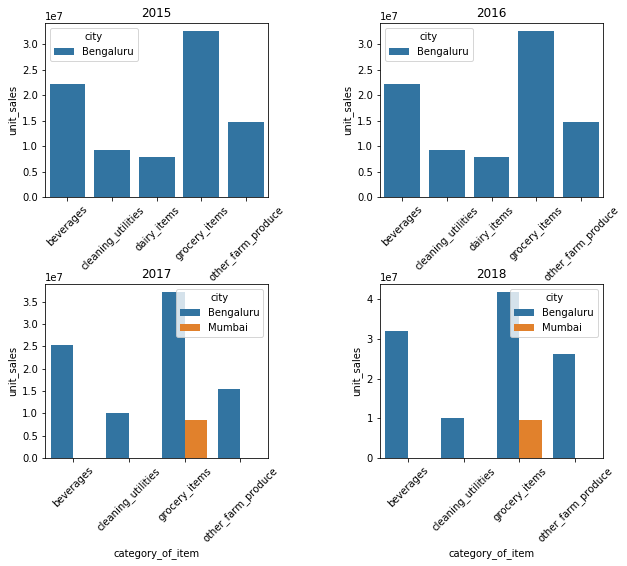

In [0]:
fig,ax = plt.subplots(2,2,figsize=(10,8))
fig.subplots_adjust(wspace=0.5,hspace=0.5)

sns.barplot(x='category_of_item',y='unit_sales',hue='city',data=train_ts_sub8_2015,ax=ax[0][0])
ax[0][0].set_title('2015')
ax[0][0].set_xlabel('category_of_item')
ax[0][0].tick_params(axis ='x', rotation = 45)
ax[0][0].set_ylabel('unit_sales')

sns.barplot(x='category_of_item',y='unit_sales',hue='city',data=train_ts_sub8_2016,ax=ax[0][1])
ax[0][1].set_title('2016')
ax[0][1].set_xlabel('category_of_item')
ax[0][1].tick_params(axis ='x', rotation = 45)
ax[0][1].set_ylabel('unit_sales')

sns.barplot(x='category_of_item',y='unit_sales',hue='city',data=train_ts_sub8_2017,ax=ax[1][0])
ax[1][0].set_title('2017')
ax[1][0].set_xlabel('category_of_item')
ax[1][0].tick_params(axis ='x', rotation = 45)
ax[1][0].set_ylabel('unit_sales')

sns.barplot(x='category_of_item',y='unit_sales',hue='city',data=train_ts_sub8_2018,ax=ax[1][1])
ax[1][1].set_title('2018')
ax[1][1].set_xlabel('category_of_item')
ax[1][1].tick_params(axis ='x', rotation = 45)
ax[1][1].set_ylabel('unit_sales')

fig.show()

High sales for most sold items are seen in Bangalore and Mumbai. 

Small basket should make sure it fills the warehouses in these 2 locations on priority.

In [0]:
del [[train_sub8,train_sub8_2015,train_sub8_2016,train_sub8_2017,train_sub8_2018]]
gc.collect()

362

**EDA13: sales trend over the years for perishable versus non-perishable items**

In [0]:
train_sub9=merged_data1.groupby(['year','perishable']).agg({'unit_sales':'sum'}).reset_index().dropna()
train_sub9.head()

,year,perishable,unit_sales
0,2015,0,106066560.0
1,2015,1,34351444.0
2,2016,0,140205152.0
3,2016,1,69268968.0
4,2017,0,164362016.0


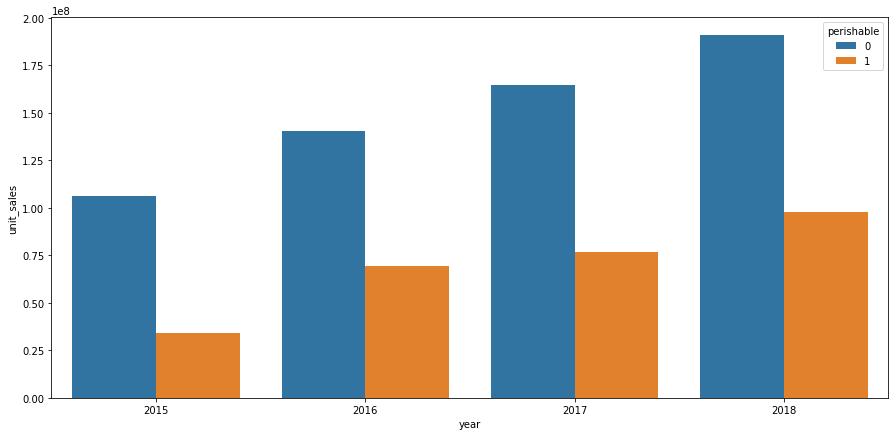

In [0]:
plt.figure(figsize=(15,7))
sns.barplot(x='year',y='unit_sales',hue='perishable',data=train_sub9)


1. Sales of perishable items are gradually decreasing over the years. 
2. Since they get decayed if not refrigerated properly, it is challenging to save them until they are being sold. 
3.   Proper care should be taken at each location.

In [0]:
del train_sub9
gc.collect()

3709

**Loading and processing train_transactions data**



In [0]:
os.chdir(r"/content/drive/My Drive/PHD")
train_transactions=pd.read_csv('train_transactions.csv')

In [0]:
train_transactions=reduce_mem_usage(train_transactions)

Memory usage of dataframe is 1.63 MB
Memory usage after optimization is: 0.39 MB
Decreased by 75.9%


In [0]:
understand_data(train_transactions)

,Datatype,No of NAs,No of Levels,Levels
date,category,0,1454,"[2015-01-01, 2015-01-02, 2015-01-03, 2015-01-0..."
location_identifier,category,0,53,"[location_25, location_1, location_2, location..."
transactions,int16,0,4912,[ 770 2111 2358 ... 5598 5304 5259]


In [0]:
train_transactions['date']=pd.to_datetime(train_transactions['date'])
train_transactions['year']=train_transactions.date.dt.year

In [0]:
train_sub10=train_transactions.groupby(['location_identifier','year']).agg({'transactions':'sum'}).reset_index().dropna()
train_sub10.head()

,location_identifier,year,transactions
0,location_1,2015,552779.0
1,location_1,2016,558324.0
2,location_1,2017,558606.0
3,location_1,2018,544262.0
4,location_10,2015,397491.0


**EDA14: To see whether total transactions at each location have increased or decreased over years**

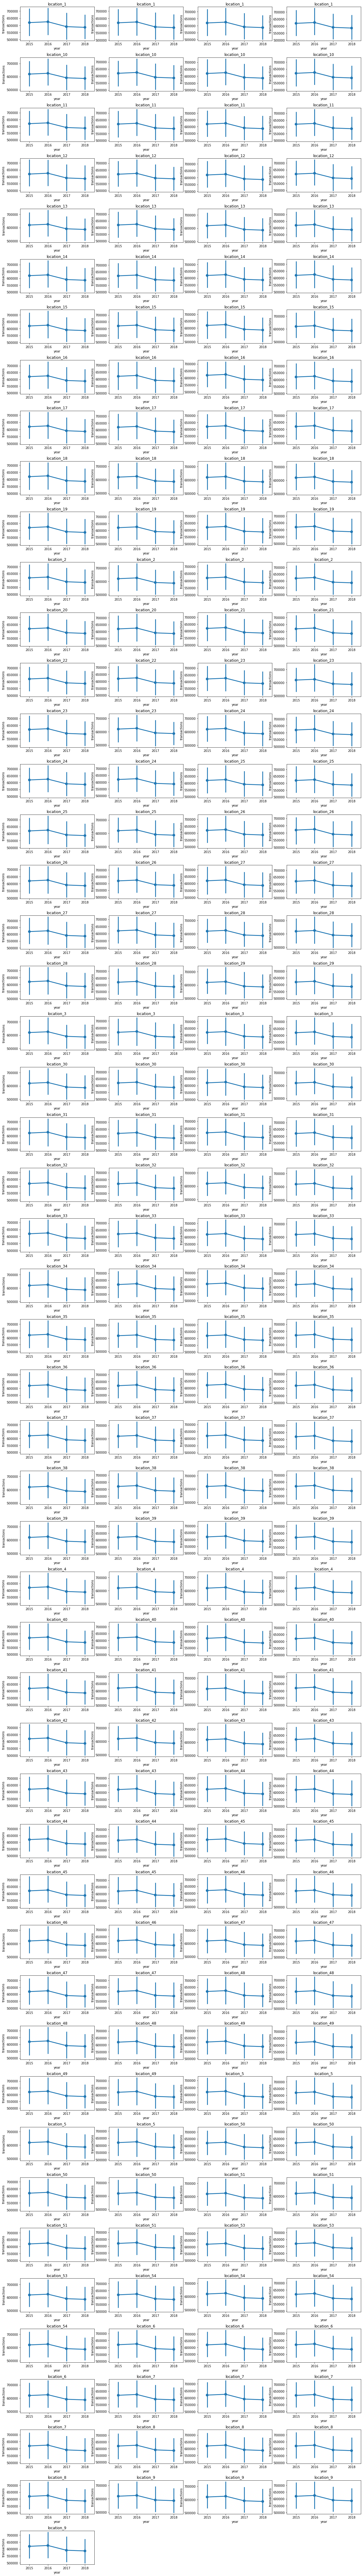

In [0]:
list_check = train_sub10['location_identifier']
plt.figure(figsize = (20,160))
plt.subplots_adjust(wspace=0.2,hspace=0.5)
for j,i in enumerate(list_check, start=1):
    sub = train_sub10[(train_sub10.location_identifier == i)]
    plt.subplot(53,4,j)
    sns.pointplot(train_sub10['year'],train_sub10['transactions'])
    plt.title(f'{i}')
plt.show()

###### Notice that the total transactions slightly increased from 2015 to 2016 and dropped from 2016 to 2017 and further dropped in 2018



-------------------------------------------------- **EDA Finished**



**Data Pre-processing for statistical and machine learning models**

**Function to reduce memory consumption**

In [0]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if col_type == 'datetime64[ns]':
              print ("")
            elif str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Loading train data**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD")
train=pd.read_csv('train.csv')


1.   In EDA it has observed that there is some treand over the years and strong month seasonality.

2.   Also, monthly seasonlity appers to be repeating over alternate years.

3.   Aim is to come up with a model that can do sales forecast for the first 15 days of January.

4.   Working on data from Dec 2017 to Feb 2018 so that along with seasonality trend before and after January (previous year) is captured.


**Taking subset of data from the entire train data**

In [0]:
train=train[(train['date'] >= '2017-12-01') & (train['date'] <= '2018-02-31')]

**Checking the dimensions of the reduced train data**

In [0]:
print(train.shape)

(8424765, 5)




1.   For any time series data we should have continuous data.

2.   Since we took three months data - Dec, Jan and Feb, the expectation is to have 90 unique dates.



In [0]:
print(train.date.unique())
print(len(train.date.unique()))

['2017-12-01' '2017-12-02' '2017-12-03' '2017-12-04' '2017-12-05'
 '2017-12-06' '2017-12-07' '2017-12-08' '2017-12-09' '2017-12-10'
 '2017-12-11' '2017-12-12' '2017-12-13' '2017-12-14' '2017-12-15'
 '2017-12-16' '2017-12-17' '2017-12-18' '2017-12-19' '2017-12-20'
 '2017-12-21' '2017-12-22' '2017-12-23' '2017-12-24' '2017-12-26'
 '2017-12-27' '2017-12-28' '2017-12-29' '2017-12-30' '2017-12-31'
 '2018-01-01' '2018-01-02' '2018-01-03' '2018-01-04' '2018-01-05'
 '2018-01-06' '2018-01-07' '2018-01-08' '2018-01-09' '2018-01-10'
 '2018-01-11' '2018-01-12' '2018-01-13' '2018-01-14' '2018-01-15'
 '2018-01-16' '2018-01-17' '2018-01-18' '2018-01-19' '2018-01-20'
 '2018-01-21' '2018-01-22' '2018-01-23' '2018-01-24' '2018-01-25'
 '2018-01-26' '2018-01-27' '2018-01-28' '2018-01-29' '2018-01-30'
 '2018-01-31' '2018-02-01' '2018-02-02' '2018-02-03' '2018-02-04'
 '2018-02-05' '2018-02-06' '2018-02-07' '2018-02-08' '2018-02-09'
 '2018-02-10' '2018-02-11' '2018-02-12' '2018-02-13' '2018-02-14'
 '2018-02-

**Notice that 25th December 2017 is missing, imputing missing date**

In [0]:
import datetime
from datetime import date, timedelta
#add missing date
min_date = min(train.date)
max_date = max(train.date)

calendar = []

d1 = datetime.datetime.strptime(min_date, '%Y-%m-%d')  
d2 = datetime.datetime.strptime(max_date, '%Y-%m-%d')

delta = d2 - d1         # timedelta

for i in range(delta.days + 1):
    calendar.append(datetime.date.strftime(d1 + timedelta(days=i), '%Y-%m-%d'))

calendar = pd.DataFrame({'date':calendar})

train = calendar.merge(train, left_on='date', right_on='date', how='left')

**Check that the missing date is now present in train data after imputation**

In [0]:
print(train.date.unique())
print(len(train.date.unique()))

['2017-12-01' '2017-12-02' '2017-12-03' '2017-12-04' '2017-12-05'
 '2017-12-06' '2017-12-07' '2017-12-08' '2017-12-09' '2017-12-10'
 '2017-12-11' '2017-12-12' '2017-12-13' '2017-12-14' '2017-12-15'
 '2017-12-16' '2017-12-17' '2017-12-18' '2017-12-19' '2017-12-20'
 '2017-12-21' '2017-12-22' '2017-12-23' '2017-12-24' '2017-12-25'
 '2017-12-26' '2017-12-27' '2017-12-28' '2017-12-29' '2017-12-30'
 '2017-12-31' '2018-01-01' '2018-01-02' '2018-01-03' '2018-01-04'
 '2018-01-05' '2018-01-06' '2018-01-07' '2018-01-08' '2018-01-09'
 '2018-01-10' '2018-01-11' '2018-01-12' '2018-01-13' '2018-01-14'
 '2018-01-15' '2018-01-16' '2018-01-17' '2018-01-18' '2018-01-19'
 '2018-01-20' '2018-01-21' '2018-01-22' '2018-01-23' '2018-01-24'
 '2018-01-25' '2018-01-26' '2018-01-27' '2018-01-28' '2018-01-29'
 '2018-01-30' '2018-01-31' '2018-02-01' '2018-02-02' '2018-02-03'
 '2018-02-04' '2018-02-05' '2018-02-06' '2018-02-07' '2018-02-08'
 '2018-02-09' '2018-02-10' '2018-02-11' '2018-02-12' '2018-02-13'
 '2018-02-

In [0]:
train.shape

(8424766, 5)

In [0]:
train.head(10)

,date,locationId,item_id,unit_sales,onpromotion
0,2017-12-01,location_1,item_99197,14.0,False
1,2017-12-01,location_1,item_103520,3.0,True
2,2017-12-01,location_1,item_103665,2.0,False
3,2017-12-01,location_1,item_105574,4.0,False
4,2017-12-01,location_1,item_105575,27.0,False
5,2017-12-01,location_1,item_106716,4.0,False
6,2017-12-01,location_1,item_108079,1.0,False
7,2017-12-01,location_1,item_108696,2.0,False
8,2017-12-01,location_1,item_108701,1.0,False
9,2017-12-01,location_1,item_108786,2.0,False


In [0]:
train.dtypes

date            object
locationId      object
item_id         object
unit_sales     float64
onpromotion     object
dtype: object

**Memory optimization for train data**

In [0]:
locationId_unique = train['locationId'].unique()
locationId_mapping = {locationId: idx for 
                             idx, locationId in 
                             enumerate(locationId_unique, 1)}
train['locationId'] = train['locationId'].map(locationId_mapping)

print(train.locationId.min())
print(train.locationId.max())
print("int8 datatype can handle integer values ranging from {} to {}".format(np.iinfo(np.int8).min,np.iinfo(np.int8).max))

train['locationId'] = train['locationId'].astype("int8")

item_id_unique = train['item_id'].unique()
item_id_mapping = {item_id: idx for 
                             idx, item_id in 
                             enumerate(item_id_unique, 1)}
train['item_id'] = train['item_id'].map(item_id_mapping)

print(train.item_id.min())
print(train.item_id.max())
print("int16 datatype can handle integer values ranging from {} to {}".format(np.iinfo(np.int16).min,np.iinfo(np.int16).max))

train['item_id'] = train['item_id'].astype("int16")

1
54
int8 datatype can handle integer values ranging from -128 to 127
1
3482
int16 datatype can handle integer values ranging from -32768 to 32767


**Modifying the existing features and generatng new features out of the existing ones**

In [0]:
import datetime
def process_data(data):
  data.date=pd.to_datetime(data['date'])
  data['day'] = data.date.dt.day_name()
  data['month'] = data.date.dt.strftime('%B')
  data['year'] = data.date.dt.year

In [0]:
process_data(train)

In [0]:
train.head()

,date,locationId,item_id,unit_sales,onpromotion,day,month,year
0,2017-12-01,1,1,14.0,False,Friday,December,2017
1,2017-12-01,1,2,3.0,True,Friday,December,2017
2,2017-12-01,1,3,2.0,False,Friday,December,2017
3,2017-12-01,1,4,4.0,False,Friday,December,2017
4,2017-12-01,1,5,27.0,False,Friday,December,2017


**Dropping unwanted columns**

In [0]:
train.drop(['date'],axis=1,inplace=True)

In [0]:
train.dtypes

locationId        int8
item_id          int16
unit_sales     float64
onpromotion     object
day             object
month           object
year             int64
dtype: object

**Further memory optimaztion to reduce file size**

In [0]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 409.76 MB
Memory usage after optimization is: 144.62 MB
Decreased by 64.7%


In [0]:
train.dtypes

locationId         int8
item_id           int16
unit_sales      float16
onpromotion    category
day            category
month          category
year              int16
dtype: object

**Understanding train data**

In [0]:
def understand_data(data) :
    return(pd.DataFrame({"Datatype":data.dtypes,"No of NAs":data.isna().sum(),"No of Levels":data.apply(lambda x: x.nunique(),axis=0),"Levels":data.apply(lambda x: str(x.unique()),axis=0)}))

In [0]:
understand_data(train)

,Datatype,No of NAs,No of Levels,Levels
locationId,int8,0,54,[ 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
item_id,int16,0,3482,[ 1 2 3 ... 3480 3481 3482]
unit_sales,float16,1,10909,[ 1.40000000e+01 3.00000000e+00 2.00000000e+...
onpromotion,category,1,2,"[False, True, NaN]\nCategories (2, object): [F..."
day,category,0,7,"[Friday, Saturday, Sunday, Monday, Tuesday, We..."
month,category,0,3,"[December, January, February]\nCategories (3, ..."
year,int16,0,2,[2017 2018]


**Handling Null Values**

In [0]:
def total_NAs(data) :
    print ("Total NAs:",data.isna().sum().sum())

Check total NAs in train data

In [0]:
total_NAs(train)

Total NAs: 2


In [0]:
print(train.isnull().sum(), '\n')

locationId     0
item_id        0
unit_sales     1
onpromotion    1
day            0
month          0
year           0
dtype: int64 





1. For the imputed date record, other values are missing. 

2. Imputing values for locationId, item_id, onpromotion and unit sales for the imputed data



In [0]:
#Check index to apply the formula
na_index_train = train[train['unit_sales'].isnull() == True].index.values

#Define the index to use to apply the formala
na_index_train_plus = na_index_train.copy()
na_index_train_minus = np.maximum(0, na_index_train-1)

for i in range(len(na_index_train)):
    k = 1
    while (na_index_train[min(i+k,len(na_index_train)-1)] == na_index_train[i]+k):
        k += 1
    na_index_train_plus[i] = min(len(train)-1, na_index_train_plus[i] + k )

#Apply the formula
for i in range(len(na_index_train)):
    if (na_index_train[i] == 0):
        train.loc[na_index_train[i], 'unit_sales'] = train.loc[na_index_train_plus[i], 'unit_sales']
    elif (na_index_train[i] == len(train)):
        train.loc[na_index_train[i], 'unit_sales'] = train.loc[na_index_train_minus[i], 'unit_sales']
    else:
        train.loc[na_index_train[i], 'unit_sales'] = (train.loc[na_index_train_plus[i], 'unit_sales'] + train.loc[na_index_train_minus[i], 'unit_sales'])/ 2    

In [0]:
train.onpromotion.fillna(value=False,inplace=True)

In [0]:
print(train.isnull().sum(), '\n')

locationId     0
item_id        0
unit_sales     0
onpromotion    0
day            0
month          0
year           0
dtype: int64 



**Checking summary statistics**

In [0]:
train.describe(include='all')

,locationId,item_id,unit_sales,onpromotion,day,month,year
count,8.424766e+06,8.424766e+06,8424766.0,8424766,8424766,8424766,8.424766e+06
unique,NaN,NaN,NaN,2,7,3,NaN
top,NaN,NaN,NaN,False,Wednesday,December,NaN
freq,NaN,NaN,NaN,7988654,1377695,2867927,NaN
mean,2.747409e+01,1.479686e+03,NaN,NaN,NaN,NaN,2.017660e+03
std,1.607050e+01,9.158058e+02,NaN,NaN,NaN,NaN,4.738492e-01
min,1.000000e+00,1.000000e+00,-1806.0,NaN,NaN,NaN,2.017000e+03
25%,1.300000e+01,7.000000e+02,2.0,NaN,NaN,NaN,2.017000e+03
50%,2.800000e+01,1.422000e+03,4.0,NaN,NaN,NaN,2.018000e+03
75%,4.200000e+01,2.184000e+03,9.0,NaN,NaN,NaN,2.018000e+03




1.   Notice that unit_sales have negative values too.They can be considered as products returned.

2.   So, let us retain them and us them as they are.



**Creating a folder in colab to take save backedup data**

In [0]:
PATH='/content/drive/My Drive/PHD/MemoryReducedFiles'
if os.path.exists(PATH):
  shutil.rmtree(PATH)
  
os.mkdir(PATH)

**Taking text backup and storing backedup files in the created folder path** 

In [0]:
def create_backupfiles(filename,dfin):
  outfile=open(filename,'wb')
  pkl.dump(dfin,outfile)
  outfile.close()

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
create_backupfiles('train',train)

**Reload backedup data**

In [0]:
def reload_backupfiles(filename):
  infile=open(filename,'rb')
  dfout=pkl.load(infile)
  infile.close()
  return(dfout)

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
train=reload_backupfiles('train')

In [0]:
import gc
gc.collect()

386

**Loading and understanding test data**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD")
test=pd.read_csv('test.csv')

In [0]:
total_NAs(test)

Total NAs: 0


In [0]:
test.shape

(1482295, 5)

In [0]:
understand_data(test)

,Datatype,No of NAs,No of Levels,Levels
id,int64,0,1482295,[0 1 2 ... 1482292 1482293 1482294]
date,object,0,15,['2019-01-01' '2019-01-02' '2019-01-03' '2019-...
locationId,object,0,53,['location_25' 'location_1' 'location_2' 'loca...
item_id,object,0,3828,['item_99197' 'item_103665' 'item_105574' ... ...
onpromotion,bool,0,2,[False True]


**Check for continuous date values in test data**

In [0]:
print(test.date.unique())
print(len(test.date.unique()))

['2019-01-01' '2019-01-02' '2019-01-03' '2019-01-04' '2019-01-05'
 '2019-01-06' '2019-01-07' '2019-01-08' '2019-01-09' '2019-01-10'
 '2019-01-11' '2019-01-12' '2019-01-13' '2019-01-14' '2019-01-15']
15


**Memory optimization for test data**

In [0]:
locationId_unique = test['locationId'].unique()
locationId_mapping = {locationId: idx for 
                             idx, locationId in 
                             enumerate(locationId_unique, 1)}
test['locationId'] = test['locationId'].map(locationId_mapping)

print(test.locationId.min())
print(test.locationId.max())
print("int8 datatype can handle integer values ranging from {} to {}".format(np.iinfo(np.int8).min,np.iinfo(np.int8).max))

test['locationId'] = test['locationId'].astype("int8")

item_id_unique = test['item_id'].unique()
item_id_mapping = {item_id: idx for 
                             idx, item_id in 
                             enumerate(item_id_unique, 1)}
test['item_id'] = test['item_id'].map(item_id_mapping)

print(test.item_id.min())
print(test.item_id.max())
print("int16 datatype can handle integer values ranging from {} to {}".format(np.iinfo(np.int16).min,np.iinfo(np.int16).max))

test['item_id'] = test['item_id'].astype("int16")
test['onpromotion']=test['onpromotion'].astype('str').astype('category')

1
53
int8 datatype can handle integer values ranging from -128 to 127
1
3828
int16 datatype can handle integer values ranging from -32768 to 32767


**Modifying existing features and generating new features out of the existing for test data**

In [0]:
process_data(test)

In [0]:
test.dtypes

id                      int64
date           datetime64[ns]
locationId               int8
item_id                 int16
onpromotion          category
day                    object
month                  object
year                    int64
dtype: object

**Dropping unwanted columns**

In [0]:
test.drop('date',axis=1,inplace=True)

In [0]:
test.shape

(1482295, 7)

In [0]:
understand_data(test)

,Datatype,No of NAs,No of Levels,Levels
id,int64,0,1482295,[ 0 1 2 ... 1482292 1482293 1...
locationId,int8,0,53,[ 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
item_id,int16,0,3828,[ 1 2 3 ... 3826 3827 3828]
onpromotion,category,0,2,"[False, True]\nCategories (2, object): [False,..."
day,object,0,7,['Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Sa...
month,object,0,1,['January']
year,int64,0,1,[2019]


**Create backup for test data**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
create_backupfiles('test',test)

**Reload backedup data**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
test=reload_backupfiles('test')

In [0]:
import gc
gc.collect()

52

**Loading and understanding item details data**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD")
item_details=pd.read_csv('item_details.csv')

In [0]:
total_NAs(item_details)

Total NAs: 0


In [0]:
understand_data(item_details)

,Datatype,No of NAs,No of Levels,Levels
item_id,object,0,4100,['item_96995' 'item_99197' 'item_103501' ... '...
category_of_item,object,0,30,['grocery_items' 'cleaning_utilities' 'baked_i...
class,object,0,337,['class_1093' 'class_1067' 'class_3008' 'class...
perishable,int64,0,2,[0 1]


**Loading and understanding location details data**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD")
location_details=pd.read_csv('location_details.csv')

In [0]:
total_NAs(location_details)

Total NAs: 0


In [0]:
understand_data(location_details)

,Datatype,No of NAs,No of Levels,Levels
location_id,object,0,54,['location_1' 'location_2' 'location_3' 'locat...
city,object,0,22,['Bengaluru' 'Delhi' 'Kolkata' 'Noida' 'Vijaya...
state,object,0,13,['Karnataka' 'NCR' 'West Bengal' 'Uttar Prades...
type,object,0,5,['D' 'B' 'C' 'E' 'A']
cluster,int64,0,17,[13 8 9 4 6 15 7 3 12 16 1 10 2 5 11 14 17]


**Memory optimization for item_details data**

In [0]:
item_id_unique = item_details['item_id'].unique()
item_id_mapping = {item_id: idx for 
                             idx, item_id in 
                             enumerate(item_id_unique, 1)}
item_details['item_id'] = item_details['item_id'].map(item_id_mapping)

print(item_details.item_id.min())
print(item_details.item_id.max())
print("int16 datatype can handle integer values ranging from {} to {}".format(np.iinfo(np.int16).min,np.iinfo(np.int16).max))

item_details['item_id'] = item_details['item_id'].astype("int16")

1
4100
int16 datatype can handle integer values ranging from -32768 to 32767


**Changing the column names to to be in consistent with those in train data**

In [0]:
location_details.columns=[x.replace('location_id','locationId') for x in location_details.columns]

**Memory optimization for location_details data**

In [0]:
locationId_unique = location_details['locationId'].unique()
locationId_mapping = {locationId: idx for 
                             idx, locationId in 
                             enumerate(locationId_unique, 1)}
location_details['locationId'] = location_details['locationId'].map(locationId_mapping)

print(location_details.locationId.min())
print(location_details.locationId.max())
print("int8 datatype can handle integer values ranging from {} to {}".format(np.iinfo(np.int8).min,np.iinfo(np.int8).max))

location_details['locationId'] = location_details['locationId'].astype("int8")

1
54
int8 datatype can handle integer values ranging from -128 to 127


In [0]:
understand_data(item_details)

,Datatype,No of NAs,No of Levels,Levels
item_id,int16,0,4100,[1 2 3 ... 4098 4099 4100]
category_of_item,object,0,30,['grocery_items' 'cleaning_utilities' 'baked_i...
class,object,0,337,['class_1093' 'class_1067' 'class_3008' 'class...
perishable,int64,0,2,[0 1]


In [0]:
understand_data(location_details)

,Datatype,No of NAs,No of Levels,Levels
locationId,int8,0,54,[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
city,object,0,22,['Bengaluru' 'Delhi' 'Kolkata' 'Noida' 'Vijaya...
state,object,0,13,['Karnataka' 'NCR' 'West Bengal' 'Uttar Prades...
type,object,0,5,['D' 'B' 'C' 'E' 'A']
cluster,int64,0,17,[13 8 9 4 6 15 7 3 12 16 1 10 2 5 11 14 17]


In [0]:
item_details=reduce_mem_usage(item_details)

Memory usage of dataframe is 0.10 MB
Memory usage after optimization is: 0.04 MB
Decreased by 63.3%


In [0]:
location_details=reduce_mem_usage(location_details)

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by -13.0%


In [0]:
understand_data(item_details)

,Datatype,No of NAs,No of Levels,Levels
item_id,int16,0,4100,[ 1 2 3 ... 4098 4099 4100]
category_of_item,category,0,30,"[grocery_items, cleaning_utilities, baked_item..."
class,category,0,337,"[class_1093, class_1067, class_3008, class_102..."
perishable,int8,0,2,[0 1]


In [0]:
understand_data(location_details)

,Datatype,No of NAs,No of Levels,Levels
locationId,int8,0,54,[ 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
city,category,0,22,"[Bengaluru, Delhi, Kolkata, Noida, Vijayawada,..."
state,category,0,13,"[Karnataka, NCR, West Bengal, Uttar Pradesh, C..."
type,category,0,5,"[D, B, C, E, A]\nCategories (5, object): [D, B..."
cluster,int8,0,17,[13 8 9 4 6 15 7 3 12 16 1 10 2 5 11 ...


**Create backups for item_details and location_details files**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
create_backupfiles('item_details',item_details)
create_backupfiles('location_details',location_details)

**Reload backup files**

In [0]:
item_details=reload_backupfiles('item_details')
location_details=reload_backupfiles('location_details')
gc.collect()

44

**Joining train, item_details dataframes**

In [0]:
merged_data1=train.merge(item_details,how='left',on=['item_id'])

In [0]:
total_NAs(merged_data1)

Total NAs: 0


In [0]:
print(train.shape);print(merged_data1.shape)

(8424766, 7)
(8424766, 10)


In [0]:
print(merged_data1.columns)

Index(['locationId', 'item_id', 'unit_sales', 'onpromotion', 'day', 'month',
       'year', 'category_of_item', 'class', 'perishable'],
      dtype='object')


In [0]:
merged_data1.head()

,locationId,item_id,unit_sales,onpromotion,day,month,year,category_of_item,class,perishable
0,1,1,14.0,False,Friday,December,2017,grocery_items,class_1093,0
1,1,2,3.0,True,Friday,December,2017,grocery_items,class_1067,0
2,1,3,2.0,False,Friday,December,2017,cleaning_utilities,class_3008,0
3,1,4,4.0,False,Friday,December,2017,grocery_items,class_1028,0
4,1,5,27.0,False,Friday,December,2017,baked_items / bread_based,class_2712,1


**Joining train, item_details dataframes and location_details**

In [0]:
merged_data1=merged_data1.merge(location_details,how='left',on=['locationId'])

In [0]:
total_NAs(merged_data1)

Total NAs: 0


In [0]:
print(merged_data1.shape)

(8424766, 14)


In [0]:
merged_data1.columns

Index(['locationId', 'item_id', 'unit_sales', 'onpromotion', 'day', 'month',
       'year', 'category_of_item', 'class', 'perishable', 'city', 'state',
       'type', 'cluster'],
      dtype='object')

In [0]:
merged_data1.head()

,locationId,item_id,unit_sales,onpromotion,day,month,year,category_of_item,class,perishable,city,state,type,cluster
0,1,1,14.0,False,Friday,December,2017,grocery_items,class_1093,0,Bengaluru,Karnataka,D,13
1,1,2,3.0,True,Friday,December,2017,grocery_items,class_1067,0,Bengaluru,Karnataka,D,13
2,1,3,2.0,False,Friday,December,2017,cleaning_utilities,class_3008,0,Bengaluru,Karnataka,D,13
3,1,4,4.0,False,Friday,December,2017,grocery_items,class_1028,0,Bengaluru,Karnataka,D,13
4,1,5,27.0,False,Friday,December,2017,baked_items / bread_based,class_2712,1,Bengaluru,Karnataka,D,13


In [0]:
understand_data(merged_data1)

,Datatype,No of NAs,No of Levels,Levels
locationId,int8,0,54,[ 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
item_id,int16,0,3482,[ 1 2 3 ... 3480 3481 3482]
unit_sales,float16,0,10909,[ 1.40000000e+01 3.00000000e+00 2.00000000e+...
onpromotion,category,0,2,"[False, True]\nCategories (2, object): [False,..."
day,category,0,7,"[Friday, Saturday, Sunday, Monday, Tuesday, We..."
month,category,0,3,"[December, January, February]\nCategories (3, ..."
year,int16,0,2,[2017 2018]
category_of_item,category,0,29,"[grocery_items, cleaning_utilities, baked_item..."
class,category,0,310,"[class_1093, class_1067, class_3008, class_102..."
perishable,int8,0,2,[0 1]


In [0]:
merged_data1.unit_sales=merged_data1.unit_sales.astype('float32')
merged_data1.dtypes

locationId              int8
item_id                int16
unit_sales           float32
onpromotion         category
day                 category
month               category
year                   int16
category_of_item    category
class               category
perishable              int8
city                category
state               category
type                category
cluster                 int8
dtype: object

**Taking backup of merged data**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
create_backupfiles('merged_data1',merged_data1)

**Restore backedup merged data**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
merged_data1=reload_backupfiles('merged_data1')

**Joining test, item_details dataframes**

In [0]:
merged_test=test.merge(item_details,how='left',on=['item_id'])

In [0]:
total_NAs(merged_test)

Total NAs: 0


In [0]:
print(test.shape);
print(merged_test.shape)

(1482295, 7)
(1482295, 10)


In [0]:
print(merged_test.columns)

Index(['id', 'locationId', 'item_id', 'onpromotion', 'day', 'month', 'year',
       'category_of_item', 'class', 'perishable'],
      dtype='object')


In [0]:
merged_test.head()

,id,locationId,item_id,onpromotion,day,month,year,category_of_item,class,perishable
0,0,1,1,False,Tuesday,January,2019,grocery_items,class_1093,0
1,1,1,2,False,Tuesday,January,2019,grocery_items,class_1067,0
2,2,1,3,False,Tuesday,January,2019,cleaning_utilities,class_3008,0
3,3,1,4,False,Tuesday,January,2019,grocery_items,class_1028,0
4,4,1,5,False,Tuesday,January,2019,baked_items / bread_based,class_2712,1


**Joining test, item_details dataframes and location_details**

In [0]:
merged_test=merged_test.merge(location_details,how='left',on=['locationId'])

In [0]:
total_NAs(merged_test)

Total NAs: 0


In [0]:
print(merged_test.shape)

(1482295, 14)


In [0]:
merged_test.columns

Index(['id', 'locationId', 'item_id', 'onpromotion', 'day', 'month', 'year',
       'category_of_item', 'class', 'perishable', 'city', 'state', 'type',
       'cluster'],
      dtype='object')

In [0]:
merged_test.head()

,id,locationId,item_id,onpromotion,day,month,year,category_of_item,class,perishable,city,state,type,cluster
0,0,1,1,False,Tuesday,January,2019,grocery_items,class_1093,0,Bengaluru,Karnataka,D,13
1,1,1,2,False,Tuesday,January,2019,grocery_items,class_1067,0,Bengaluru,Karnataka,D,13
2,2,1,3,False,Tuesday,January,2019,cleaning_utilities,class_3008,0,Bengaluru,Karnataka,D,13
3,3,1,4,False,Tuesday,January,2019,grocery_items,class_1028,0,Bengaluru,Karnataka,D,13
4,4,1,5,False,Tuesday,January,2019,baked_items / bread_based,class_2712,1,Bengaluru,Karnataka,D,13


In [0]:
understand_data(merged_test)

,Datatype,No of NAs,No of Levels,Levels
id,int64,0,1482295,[ 0 1 2 ... 1482292 1482293 1...
locationId,int8,0,53,[ 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
item_id,int16,0,3828,[ 1 2 3 ... 3826 3827 3828]
onpromotion,category,0,2,"[False, True]\nCategories (2, object): [False,..."
day,object,0,7,['Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Sa...
month,object,0,1,['January']
year,int64,0,1,[2019]
category_of_item,category,0,30,"[grocery_items, cleaning_utilities, baked_item..."
class,category,0,326,"[class_1093, class_1067, class_3008, class_102..."
perishable,int8,0,2,[0 1]


**Creating backup for merged test file**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
create_backupfiles('merged_test',merged_test)

**Restoring backuped merged test file**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
merged_test=reload_backupfiles('merged_test')

In [0]:
merged_test.drop(['id'],axis=1,inplace=True)

**Saving id column from test file - to use while generating test predictions**

In [0]:
id=pd.DataFrame(test.id)
id.shape

(1482295, 1)

In [0]:
del [[train,test,item_details,location_details]]
gc.collect()

0

**Label Encoding item_id**

In [0]:
def setdiff_sorted(array1,array2,assume_unique=False):
  ans=np.setdiff1d(array1,array2,assume_unique).tolist()
  if assume_unique:
    return sorted(ans)
  return ans

In [0]:
merged_data1.item_id=merged_data1.item_id.astype('str').astype('category')
merged_test.item_id=merged_test.item_id.astype('str').astype('category')
merged_data1_item_levels=merged_data1['item_id'].cat.categories.tolist()
merged_test_item_levels=merged_test['item_id'].cat.categories.tolist()
new_item_levels=setdiff_sorted(merged_test_item_levels,merged_data1_item_levels)
total_item_levels=merged_data1_item_levels+new_item_levels
print('\nItems in merged_data1 only:\n')
print(len(merged_data1_item_levels))
print('\nItems in merged_test only:\n')
print(len(merged_test_item_levels))
print('\nTotal items in merged_data1 and merged_test are:\n')
print(len(total_item_levels))


Items in merged_data1 only:

3482

Items in merged_test only:

3828

Total items in merged_data1 and merged_test are:

3828


**Label Encoding locationId column**

In [0]:
total_NAs(merged_data1)

Total NAs: 0


In [0]:
encoded_values1=list(range(3828))
dict_items1=dict(zip(total_item_levels,encoded_values1))
merged_data1['item_id']=merged_data1['item_id'].map(dict_items1)
merged_data1.item_id=merged_data1.item_id.astype('int32')

In [0]:
merged_data1.locationId=merged_data1.locationId.astype('str').astype('category')
merged_test.locationId=merged_test.locationId.astype('str').astype('category')
total_location_levels=merged_data1['locationId'].unique().tolist()
encoded_values2=list(range(len(total_location_levels)))
dict_items2=dict(zip(total_location_levels,encoded_values2))
merged_data1['locationId']=merged_data1['locationId'].map(dict_items2)
merged_data1.locationId=merged_data1.locationId.astype('int32')

**Label Encoding item_id and locationId columns in merged_testdata**

In [0]:
merged_test['item_id']=merged_test['item_id'].map(dict_items1)
merged_test.item_id=merged_test.item_id.astype('int32')
merged_test['locationId']=merged_test['locationId'].map(dict_items2)
merged_test.locationId=merged_test.locationId.astype('int32')

**Function to drop unimportant columns**

In [0]:
def drop_unimp_cols(data,unimp_cols) :
    print("Deleting unimportant columns", unimp_cols)
    data.drop(unimp_cols,axis=1,inplace=True)

**Understanding important Features**

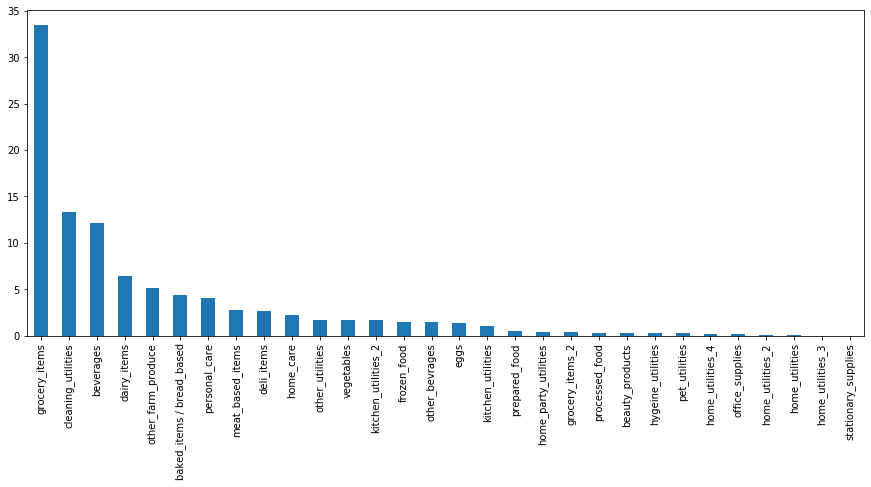

In [0]:
(merged_data1.category_of_item.value_counts(normalize = True)*100).plot(kind = 'bar', figsize = (15,6))

Taking the top 10 categories of "category_of_items" for model building

**One hot encoding for multiple cateogircal levels using top 10 levels**

In [0]:
# Function to do one-hot encoding for a categorical variable with multiple levels
def one_hot_top_x(data, variable, top_x_labels) :
    for label in top_x_labels :
        data[variable+'_'+label] = np.where(data[variable]==label, 1, 0)

In [0]:
# Find the 10 most frequent categories for category_of_item
top_10_category_of_item = [x for x in merged_data1.category_of_item.value_counts().sort_values(ascending=False).head(10).index]

# Now create the 10 most frequent dummy variables for category_of_item
one_hot_top_x(merged_data1, 'category_of_item', top_10_category_of_item)
merged_data1.head()

,locationId,item_id,unit_sales,onpromotion,day,month,year,category_of_item,class,perishable,city,state,type,cluster,category_of_item_grocery_items,category_of_item_cleaning_utilities,category_of_item_beverages,category_of_item_dairy_items,category_of_item_other_farm_produce,category_of_item_baked_items / bread_based,category_of_item_personal_care,category_of_item_meat_based_items,category_of_item_deli_items,category_of_item_home_care
0,0,0,14.0,False,Friday,December,2017,grocery_items,class_1093,0,Bengaluru,Karnataka,D,13,1,0,0,0,0,0,0,0,0,0
1,0,1111,3.0,True,Friday,December,2017,grocery_items,class_1067,0,Bengaluru,Karnataka,D,13,1,0,0,0,0,0,0,0,0,0
2,0,2222,2.0,False,Friday,December,2017,cleaning_utilities,class_3008,0,Bengaluru,Karnataka,D,13,0,1,0,0,0,0,0,0,0,0
3,0,2816,4.0,False,Friday,December,2017,grocery_items,class_1028,0,Bengaluru,Karnataka,D,13,1,0,0,0,0,0,0,0,0,0
4,0,2927,27.0,False,Friday,December,2017,baked_items / bread_based,class_2712,1,Bengaluru,Karnataka,D,13,0,0,0,0,0,1,0,0,0,0


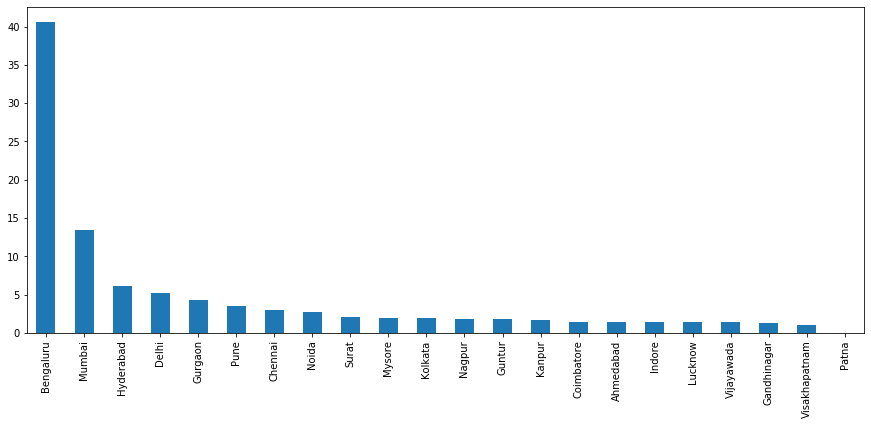

In [0]:
(merged_data1.city.value_counts(normalize = True)*100).plot(kind = 'bar', figsize = (15,6))


1.   Most of the records are from Bengaluru city. 
2.   So, we might not get significant insights if we use city column to extract any sales information per location.

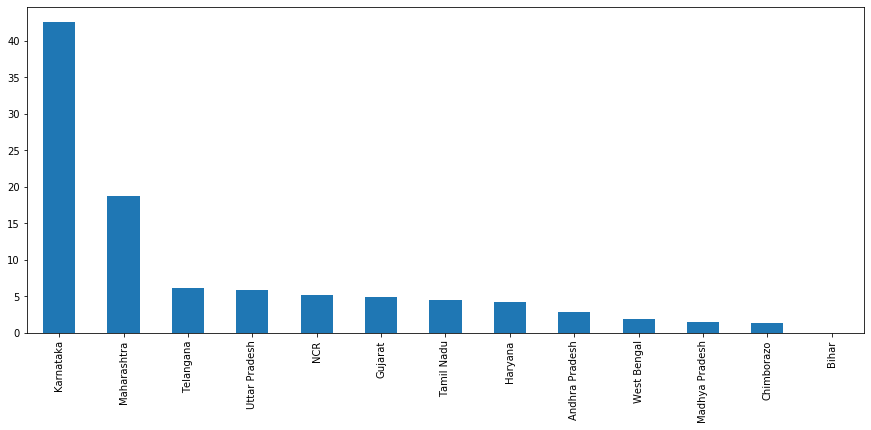

In [0]:
(merged_data1.state.value_counts(normalize = True)*100).plot(kind = 'bar', figsize = (15,6))



1.   Most of the records are from Karnataka and Maharashtra state.
2.   So, we might not get sufficient location based sales insights using state attribute.



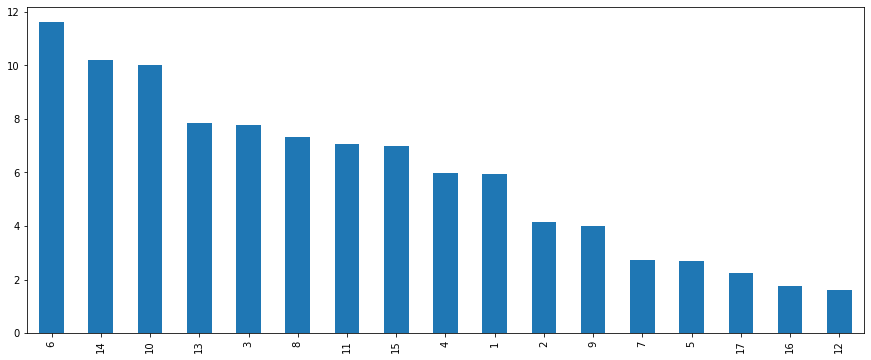

In [0]:
(merged_data1.cluster.value_counts(normalize = True)*100).plot(kind = 'bar', figsize = (15,6))

Taking the top 10 categories of "clusters" for model building

**One hot encoding for multiple cateogircal levels using top 10 levels**

In [0]:
# Find the 10 most frequent categories for cluster
merged_data1.cluster=merged_data1.cluster.astype('str')
top_10_cluster = [x for x in merged_data1.cluster.value_counts().sort_values(ascending=False).head(10).index]

# Now create the 10 most frequent dummy variables for cluster
one_hot_top_x(merged_data1, 'cluster', top_10_cluster)
merged_data1.head()

,locationId,item_id,unit_sales,onpromotion,day,month,year,category_of_item,class,perishable,city,state,type,cluster,category_of_item_grocery_items,category_of_item_cleaning_utilities,category_of_item_beverages,category_of_item_dairy_items,category_of_item_other_farm_produce,category_of_item_baked_items / bread_based,category_of_item_personal_care,category_of_item_meat_based_items,category_of_item_deli_items,category_of_item_home_care,cluster_6,cluster_14,cluster_10,cluster_13,cluster_3,cluster_8,cluster_11,cluster_15,cluster_4,cluster_1
0,0,0,14.0,False,Friday,December,2017,grocery_items,class_1093,0,Bengaluru,Karnataka,D,13,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,1111,3.0,True,Friday,December,2017,grocery_items,class_1067,0,Bengaluru,Karnataka,D,13,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,2222,2.0,False,Friday,December,2017,cleaning_utilities,class_3008,0,Bengaluru,Karnataka,D,13,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,2816,4.0,False,Friday,December,2017,grocery_items,class_1028,0,Bengaluru,Karnataka,D,13,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,2927,27.0,False,Friday,December,2017,baked_items / bread_based,class_2712,1,Bengaluru,Karnataka,D,13,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [0]:
merged_data1.columns

Index(['locationId', 'item_id', 'unit_sales', 'onpromotion', 'day', 'month',
       'year', 'category_of_item', 'class', 'perishable', 'city', 'state',
       'type', 'cluster', 'category_of_item_grocery_items',
       'category_of_item_cleaning_utilities', 'category_of_item_beverages',
       'category_of_item_dairy_items', 'category_of_item_other_farm_produce',
       'category_of_item_baked_items / bread_based',
       'category_of_item_personal_care', 'category_of_item_meat_based_items',
       'category_of_item_deli_items', 'category_of_item_home_care',
       'cluster_6', 'cluster_14', 'cluster_10', 'cluster_13', 'cluster_3',
       'cluster_8', 'cluster_11', 'cluster_15', 'cluster_4', 'cluster_1'],
      dtype='object')

In [0]:
drop_unimp_cols(merged_data1,['cluster','category_of_item','class','city','state'])

Deleting unimportant columns ['cluster', 'category_of_item', 'class', 'city', 'state']


In [0]:
understand_data(merged_data1)

,Datatype,No of NAs,No of Levels,Levels
locationId,int32,0,54,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
item_id,int32,0,3482,[ 0 1111 2222 ... 2757 2758 2759]
unit_sales,float32,0,10909,[ 1.40000000e+01 3.00000000e+00 2.00000000e+...
onpromotion,category,0,2,"[False, True]\nCategories (2, object): [False,..."
day,category,0,7,"[Friday, Saturday, Sunday, Monday, Tuesday, We..."
month,category,0,3,"[December, January, February]\nCategories (3, ..."
year,int16,0,2,[2017 2018]
perishable,int8,0,2,[0 1]
type,category,0,5,"[D, B, C, E, A]\nCategories (5, object): [D, B..."
category_of_item_grocery_items,int64,0,2,[1 0]


In [0]:
import pandas as pd
from typing import List


def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df


def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df


def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if float(num_unique_values) / num_total_values < 0.5:
                df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df

def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))

In [0]:
print(merged_data1.memory_usage().sum() / 1024**2)
merged_data1=optimize_floats(merged_data1)
merged_data1=optimize_ints(merged_data1)
merged_data1=optimize_objects(merged_data1,[])
merged_data1=optimize(merged_data1)
print(merged_data1.memory_usage().sum() / 1024**2)

1502.449052810669
377.62143898010254


In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
create_backupfiles('merged_data1',merged_data1)
merged_data1=reload_backupfiles('merged_data1')

**One hot encoding for attributes in test data**

**One hot encoding for top 10 categorical levels in category_of_item in merged_test data**

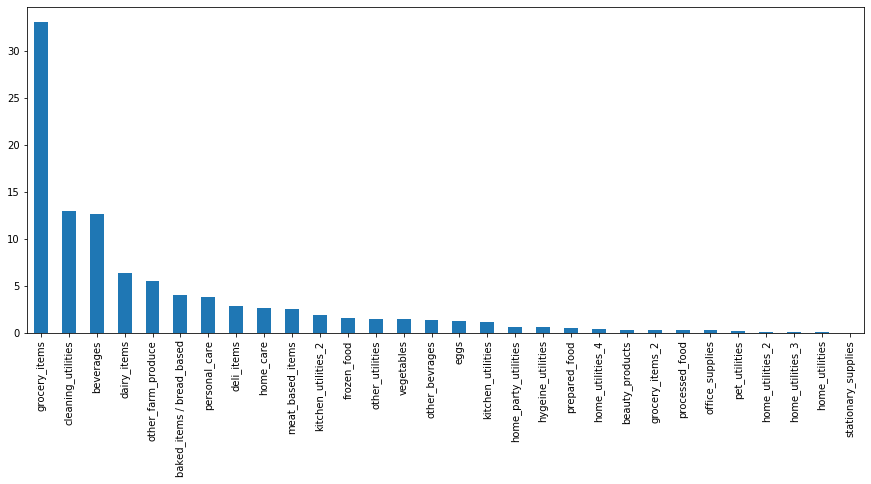

In [0]:
(merged_test.category_of_item.value_counts(normalize = True)*100).plot(kind = 'bar', figsize = (15,6))

Notice that top 10 most popular items in test and train are the same.

In [0]:
# Now create the 10 most frequent dummy variables for category_of_item
one_hot_top_x(merged_test, 'category_of_item', top_10_category_of_item)
merged_test.head()

,locationId,item_id,onpromotion,day,month,year,category_of_item,class,perishable,city,state,type,cluster,category_of_item_grocery_items,category_of_item_cleaning_utilities,category_of_item_beverages,category_of_item_dairy_items,category_of_item_other_farm_produce,category_of_item_baked_items / bread_based,category_of_item_personal_care,category_of_item_meat_based_items,category_of_item_deli_items,category_of_item_home_care
0,0,0,False,Tuesday,January,2019,grocery_items,class_1093,0,Bengaluru,Karnataka,D,13,1,0,0,0,0,0,0,0,0,0
1,0,1111,False,Tuesday,January,2019,grocery_items,class_1067,0,Bengaluru,Karnataka,D,13,1,0,0,0,0,0,0,0,0,0
2,0,2222,False,Tuesday,January,2019,cleaning_utilities,class_3008,0,Bengaluru,Karnataka,D,13,0,1,0,0,0,0,0,0,0,0
3,0,2816,False,Tuesday,January,2019,grocery_items,class_1028,0,Bengaluru,Karnataka,D,13,1,0,0,0,0,0,0,0,0,0
4,0,2927,False,Tuesday,January,2019,baked_items / bread_based,class_2712,1,Bengaluru,Karnataka,D,13,0,0,0,0,0,1,0,0,0,0


**One hot encoding with top 10 categories of cluster column**

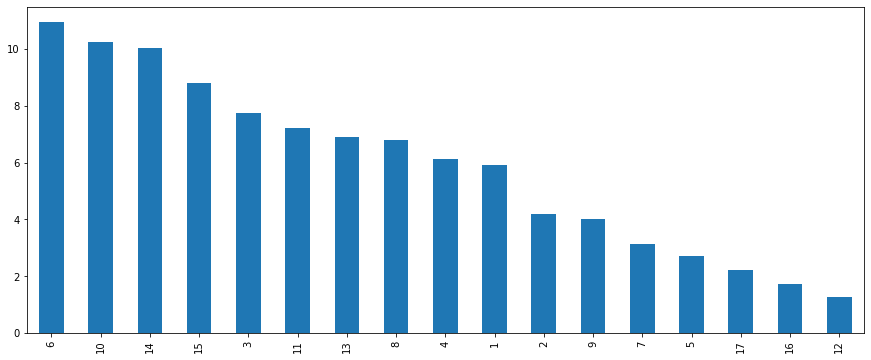

In [0]:
(merged_test.cluster.value_counts(normalize = True)*100).plot(kind = 'bar', figsize = (15,6))

Notice that the top 10 popular clusters in test and train are the same.

In [0]:
# Now create the 10 most frequent dummy variables for cluster
one_hot_top_x(merged_test, 'cluster', top_10_cluster)
merged_test.head()

,locationId,item_id,onpromotion,day,month,year,category_of_item,class,perishable,city,state,type,cluster,category_of_item_grocery_items,category_of_item_cleaning_utilities,category_of_item_beverages,category_of_item_dairy_items,category_of_item_other_farm_produce,category_of_item_baked_items / bread_based,category_of_item_personal_care,category_of_item_meat_based_items,category_of_item_deli_items,category_of_item_home_care,cluster_6,cluster_14,cluster_10,cluster_13,cluster_3,cluster_8,cluster_11,cluster_15,cluster_4,cluster_1
0,0,0,False,Tuesday,January,2019,grocery_items,class_1093,0,Bengaluru,Karnataka,D,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1111,False,Tuesday,January,2019,grocery_items,class_1067,0,Bengaluru,Karnataka,D,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,2222,False,Tuesday,January,2019,cleaning_utilities,class_3008,0,Bengaluru,Karnataka,D,13,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,2816,False,Tuesday,January,2019,grocery_items,class_1028,0,Bengaluru,Karnataka,D,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,2927,False,Tuesday,January,2019,baked_items / bread_based,class_2712,1,Bengaluru,Karnataka,D,13,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
merged_test.columns

Index(['locationId', 'item_id', 'onpromotion', 'day', 'month', 'year',
       'category_of_item', 'class', 'perishable', 'city', 'state', 'type',
       'cluster', 'category_of_item_grocery_items',
       'category_of_item_cleaning_utilities', 'category_of_item_beverages',
       'category_of_item_dairy_items', 'category_of_item_other_farm_produce',
       'category_of_item_baked_items / bread_based',
       'category_of_item_personal_care', 'category_of_item_meat_based_items',
       'category_of_item_deli_items', 'category_of_item_home_care',
       'cluster_6', 'cluster_14', 'cluster_10', 'cluster_13', 'cluster_3',
       'cluster_8', 'cluster_11', 'cluster_15', 'cluster_4', 'cluster_1'],
      dtype='object')

In [0]:
drop_unimp_cols(merged_test,['category_of_item','cluster','class','city','state'])

Deleting unimportant columns ['category_of_item', 'cluster', 'class', 'city', 'state']


In [0]:
print(merged_test.memory_usage().sum() / 1024**2)
merged_test=optimize_floats(merged_test)
merged_test=optimize_ints(merged_test)
merged_test=optimize_objects(merged_test,[])
merged_test=optimize(merged_test)
print(merged_test.memory_usage().sum() / 1024**2)

286.96649646759033
60.78667163848877


In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
create_backupfiles('merged_test',merged_test)
merged_test=reload_backupfiles('merged_test')

In [0]:
print("======verify that the no of columns are the same in train,val and test after dummification======")
print(merged_data1.shape[1])
print(merged_test.shape[1])

======verify that the no of columns are the same in train,val and test after dummification======
29
28


Before dummification except for the target column, all other columns are present train are present in test.

In [0]:
print(merged_data1.columns)
print(merged_test.columns)

Index(['locationId', 'item_id', 'unit_sales', 'onpromotion', 'day', 'month',
       'year', 'perishable', 'type', 'category_of_item_grocery_items',
       'category_of_item_cleaning_utilities', 'category_of_item_beverages',
       'category_of_item_dairy_items', 'category_of_item_other_farm_produce',
       'category_of_item_baked_items / bread_based',
       'category_of_item_personal_care', 'category_of_item_meat_based_items',
       'category_of_item_deli_items', 'category_of_item_home_care',
       'cluster_6', 'cluster_14', 'cluster_10', 'cluster_13', 'cluster_3',
       'cluster_8', 'cluster_11', 'cluster_15', 'cluster_4', 'cluster_1'],
      dtype='object')
Index(['locationId', 'item_id', 'onpromotion', 'day', 'month', 'year',
       'perishable', 'type', 'category_of_item_grocery_items',
       'category_of_item_cleaning_utilities', 'category_of_item_beverages',
       'category_of_item_dairy_items', 'category_of_item_other_farm_produce',
       'category_of_item_baked_items / 

In [0]:
# Renaming test file
test=merged_test.copy()

**Train Validation split**

In [0]:
X=merged_data1.drop(['unit_sales'],axis=1)
y=pd.DataFrame(merged_data1['unit_sales'])
print(X.columns);print(y.columns)

Index(['locationId', 'item_id', 'onpromotion', 'day', 'month', 'year',
       'perishable', 'type', 'category_of_item_grocery_items',
       'category_of_item_cleaning_utilities', 'category_of_item_beverages',
       'category_of_item_dairy_items', 'category_of_item_other_farm_produce',
       'category_of_item_baked_items / bread_based',
       'category_of_item_personal_care', 'category_of_item_meat_based_items',
       'category_of_item_deli_items', 'category_of_item_home_care',
       'cluster_6', 'cluster_14', 'cluster_10', 'cluster_13', 'cluster_3',
       'cluster_8', 'cluster_11', 'cluster_15', 'cluster_4', 'cluster_1'],
      dtype='object')
Index(['unit_sales'], dtype='object')


In [0]:
# Split train and validation data
from sklearn.model_selection import train_test_split
train_x,val_x,train_y,val_y=train_test_split(X,y,test_size=0.2,random_state=42)
print(train_x.shape)
print(val_x.shape)
print(train_y.shape)
print(val_y.shape)

(6739812, 28)
(1684954, 28)
(6739812, 1)
(1684954, 1)


In [0]:
#def train_test_split(X,y):
#  len=X.shape[0]
#  train_size = int((len) * 0.7)
#  train_x, val_x = X[:train_size], X[train_size:]
#  train_y, val_y = y[:train_size], y[train_size:]
#  return (train_x,val_x,train_y,val_y)

In [0]:
#train_x,val_x,train_y,val_y=train_test_split(X,y)

In [0]:
train_x.columns

Index(['locationId', 'item_id', 'onpromotion', 'day', 'month', 'year',
       'perishable', 'type', 'category_of_item_grocery_items',
       'category_of_item_cleaning_utilities', 'category_of_item_beverages',
       'category_of_item_dairy_items', 'category_of_item_other_farm_produce',
       'category_of_item_baked_items / bread_based',
       'category_of_item_personal_care', 'category_of_item_meat_based_items',
       'category_of_item_deli_items', 'category_of_item_home_care',
       'cluster_6', 'cluster_14', 'cluster_10', 'cluster_13', 'cluster_3',
       'cluster_8', 'cluster_11', 'cluster_15', 'cluster_4', 'cluster_1'],
      dtype='object')

In [0]:
test.columns

Index(['locationId', 'item_id', 'onpromotion', 'day', 'month', 'year',
       'perishable', 'type', 'category_of_item_grocery_items',
       'category_of_item_cleaning_utilities', 'category_of_item_beverages',
       'category_of_item_dairy_items', 'category_of_item_other_farm_produce',
       'category_of_item_baked_items / bread_based',
       'category_of_item_personal_care', 'category_of_item_meat_based_items',
       'category_of_item_deli_items', 'category_of_item_home_care',
       'cluster_6', 'cluster_14', 'cluster_10', 'cluster_13', 'cluster_3',
       'cluster_8', 'cluster_11', 'cluster_15', 'cluster_4', 'cluster_1'],
      dtype='object')

In [0]:
del [[merged_data1,merged_test,X,y]]
gc.collect()

17

**Dummifying other categorical variables**

In [0]:
cat_cols=['onpromotion','day','month','year','type']
train_x=pd.get_dummies(train_x,columns=cat_cols,drop_first=False)
val_x=pd.get_dummies(val_x,columns=cat_cols,drop_first=False)
test=pd.get_dummies(test,columns=cat_cols,drop_first=False)

In [0]:
print("======verify that the no of columns are the same in train,val and test after dummification======")
print(train_x.shape[1])
print(val_x.shape[1])
print(test.shape[1])

======verify that the no of columns are the same in train,val and test after dummification======
42
42
39


**Checking Alignment**

In [0]:
set(train_x.columns.tolist()) - set(val_x.columns.tolist()) 

set()

In [0]:
set(val_x.columns.tolist()) - set(train_x.columns.tolist())

set()

In [0]:
set(train_x.columns.tolist()) - set(test.columns.tolist()) 

{'month_December', 'month_February', 'year_2017', 'year_2018'}

In [0]:
set(test.columns.tolist()) - set(train_x.columns.tolist())

{'year_2019'}

In [0]:
train_x_aligned, test_aligned  = train_x.align(test, join = 'outer', axis = 1, fill_value = 0)
print(train_x_aligned.shape)
print(test_aligned.shape)

(6739812, 43)
(1482295, 43)


In [0]:
train_x_aligned, val_x_aligned  = train_x_aligned.align(val_x, join = 'outer', axis = 1, fill_value = 0)
print(train_x_aligned.shape)
print(val_x_aligned.shape)

(6739812, 43)
(1684954, 43)


In [0]:
print("======verify that the no of columns are the same in train,val and test after alignment======")
print(train_x_aligned.shape[1])
print(val_x_aligned.shape[1])
print(test_aligned.shape[1])

======verify that the no of columns are the same in train,val and test after alignment======
43
43
43


In [0]:
del [[train_x,val_x,test]]
del [[top_10_cluster,top_10_category_of_item,merged_data1_item_levels,merged_test_item_levels,total_location_levels,total_item_levels]]
gc.collect()

0

In [0]:
# Renaming
train_x=train_x_aligned
val_x=val_x_aligned
test=test_aligned

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
create_backupfiles('train_x',train_x)
create_backupfiles('train_y',train_y)
create_backupfiles('val_x',val_x)
create_backupfiles('val_y',val_y)
create_backupfiles('test',test)
train_x=reload_backupfiles('train_x')
train_y=reload_backupfiles('train_y')
val_x=reload_backupfiles('val_x')
val_y=reload_backupfiles('val_y')
test=reload_backupfiles('test')

In [0]:
del [[train_x_aligned,val_x_aligned,test_aligned]]
gc.collect()

0

**Target Distribution Analysis**

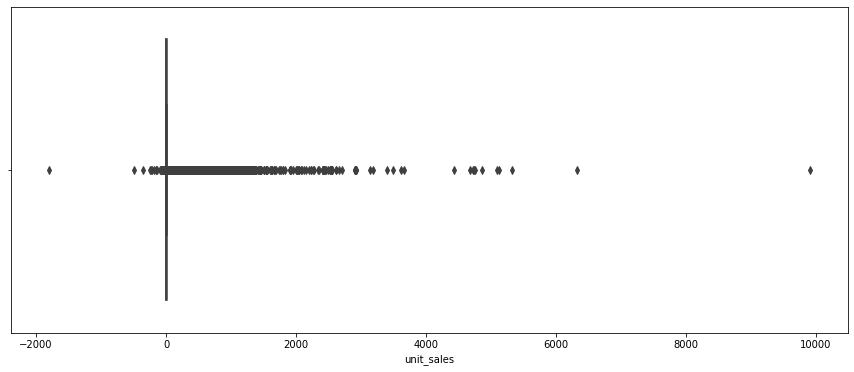

In [0]:
plt.figure(figsize = (15,6))
sns.boxplot(train_y['unit_sales'])

In [0]:
train_y[train_y.unit_sales>4000]

,unit_sales
750849,4672.0
1327083,4744.0
6014015,4856.0
6300855,4728.0
1978053,6316.0
2016219,9904.0
87488,5116.0
2038684,4748.0
6391946,5096.0
6009151,5328.0


In [0]:
train_y[train_y.unit_sales<-300]

,unit_sales
8109228,-363.0
1293565,-494.0
1396196,-1806.0


In [0]:
# Function to get Upper and Lower Quantiles for all the numerical columns of a dataset
def getUpperLowerQuantiles(data) :
    LowerQuantile=[]
    UpperQuantile=[]
    num_cols=data.select_dtypes(include=['int64','float64']).columns
    print(num_cols)
    for i in num_cols:
        LowerQuantile.append(data[i].quantile(.01))
        UpperQuantile.append(data[i].quantile(.99))
    return(LowerQuantile,UpperQuantile)

In [0]:
# Get the Upper and Lower Quantiles
#LowerQuantile,UpperQuantile=list(getUpperLowerQuantiles(train_y))

In [0]:
# Function to do quantile clipping incase of any outliers
def clip_outliers(data):
    data.clip(lower=LowerQuantile, axis=1, inplace=True)
    data.clip(upper=UpperQuantile, axis=1, inplace=True)

In [0]:
# Clip Outliers (if any) in train data
#clip_outliers(train_y)
# Clip Outliers (if any) in validation data 
#clip_outliers(val_y)

There are few extreme values, retaining there as they are not many.

In [0]:
train_y_abs=pd.DataFrame(np.abs(train_y),columns=['unit_sales'])

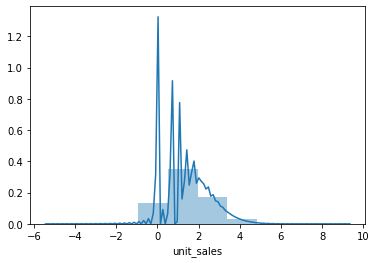

In [0]:
sns.distplot(np.log(abs(train_y['unit_sales'])),bins=10,kde=True)

In [0]:
train_xy=pd.concat([train_x,train_y],axis=1)
val_xy=pd.concat([val_x,val_y],axis=1)

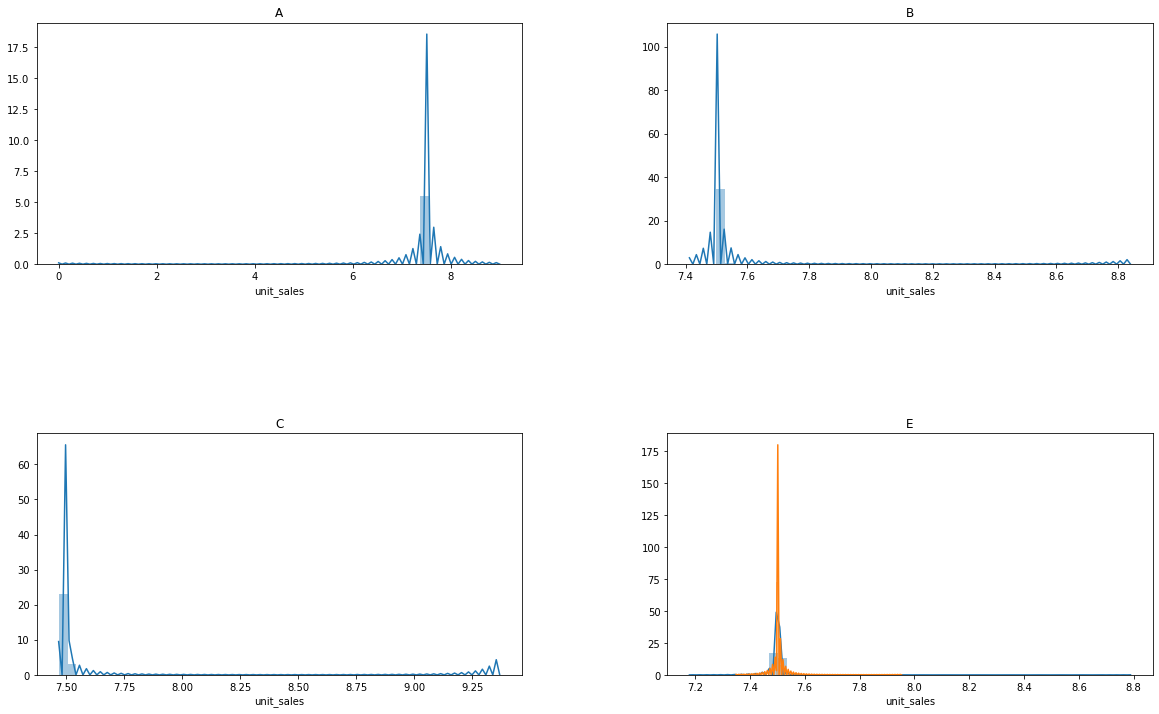

In [0]:
plt.figure(figsize = (20,12))
plt.subplots_adjust(wspace=0.3,hspace=0.7)
plt.subplot(2,2,1)
sns.distplot(np.log1p(train_xy[train_xy.type_A == 1]['unit_sales']+1806))
plt.title('A')

plt.subplot(2,2,2)
sns.distplot(np.log1p(train_xy[train_xy.type_B == 1]['unit_sales']+1806))
plt.title('B')

plt.subplot(2,2,3)
sns.distplot(np.log1p(train_xy[train_xy.type_C == 1]['unit_sales']+1806))
plt.title('C')

plt.subplot(2,2,4)
sns.distplot(np.log1p(train_xy[train_xy.type_D == 1]['unit_sales']+1806))
plt.title('D')

plt.subplot(2,2,4)
sns.distplot(np.log1p(train_xy[train_xy.type_E == 1]['unit_sales']+1806))
plt.title('E')
plt.show()

**Function to evaluate model and calculate Erorr Metrics**

In [0]:
def ErrorMetrics(train_y,train_pred,val_y,val_pred):
    print("-----Train Error------")
    print("MSE:", mean_squared_error(train_y, train_pred))
    print("RMSE:", np.sqrt(mean_squared_error(train_y, train_pred)))
    print("MAE:", mean_absolute_error(train_y, train_pred))
    print ('MAPE: ',np.mean(np.abs((train_y - train_pred)/train_y))*100)
    
    print("-----Validation Error------")
    print("MSE:", mean_squared_error(val_y, val_pred))
    print("RMSE:", np.sqrt(mean_squared_error(val_y, val_pred)))
    print("MAE:", mean_absolute_error(val_y, val_pred))
    print ('MAPE: ',np.mean(np.abs((val_y - val_pred)/val_y))*100)

**Linear Regression Model Building**

In [0]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
def model_building(model):
    m=model
    m.fit(train_x,train_y)
    train_pred = m.predict(train_x)
    val_pred = m.predict(val_x)
    print('=======Train======')
    print('MSE: ', mean_squared_error(train_y, train_pred))
    print('RMSE: ', np.sqrt(mean_squared_error(train_y, train_pred)))
    print('MAE: ', mean_absolute_error(train_y,train_pred))
    print('MAPE: ', np.mean(np.abs((train_y - train_pred)/train_y))*100)
    print('======Test======')
    print('MSE: ', mean_squared_error(val_y, val_pred))
    print('RMSE: ', np.sqrt(mean_squared_error(val_y, val_pred)))
    print('MAE: ', mean_absolute_error(val_y,val_pred))
    print ('MAPE: ',np.mean(np.abs((val_y - val_pred)/val_y))*100)
    return m

In [0]:
from sklearn.linear_model import LinearRegression
reg = model_building(LinearRegression())

=======Train======
MSE:  499.546839597735
RMSE:  22.35054450338369
MAE:  7.754277490119543
MAPE:  unit_sales    230.643653
dtype: float64
======Test======
MSE:  563.0684955576424
RMSE:  23.72906436330018
MAE:  7.731187257401141
MAPE:  unit_sales    230.192323
dtype: float64


([7.7268009466984715,
  7.725166921183163,
  7.7476147395865125,
  7.760618670500531,
  7.765842605751995,
  7.752665445084684,
  7.747210578929522,
  7.751378715493179,
  7.753714195283549,
  7.754277490119543],
 [7.725623445239643,
  7.725065322250197,
  7.731456377424871,
  7.735351087825964,
  7.7358605621977174,
  7.731949711658981,
  7.7303341597513615,
  7.731059222902084,
  7.731250672603368,
  7.731187257401141])

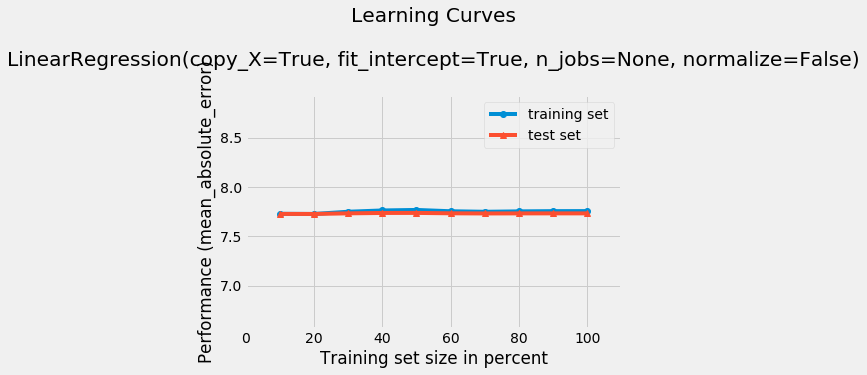

In [0]:
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(train_x, train_y, val_x, val_y, reg, scoring='mean_absolute_error')

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
create_backupfiles('reg',reg)
reg=reload_backupfiles('reg')

**Ridge Regularizatoin**

In [0]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
# The value of alpha determines the extent of penalization.
# But we also need to check which value of alpha gives best predictions on test data.
# For this we experiment with several values of alpha and pick the best. 
# We do this by performing grid search over several values of alpha - Cross Validation
alphas = np.array([1,0.1,0.01,0.001,0.0001,0,1.5,2])

In [0]:
# create and fit a ridge regression model
model_ridge = Ridge()
grid = GridSearchCV(estimator=model_ridge, param_grid=dict(alpha=alphas),cv=10)
grid.fit(train_x,train_y)
print(grid)

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.0e+00, 1.0e-01, 1.0e-02, 1.0e-03, 1.0e-04, 0.0e+00, 1.5e+00,
       2.0e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)


In [0]:
print(grid.best_score_)
print(grid.best_estimator_.alpha)

0.023632008465658126
0.0001


In [0]:
Ridge_model= Ridge(alpha=2,normalize=False)
Ridge_model.fit(train_x,train_y)
train_pred_ridge=Ridge_model.predict(train_x)
val_pred_ridge=Ridge_model.predict(val_x)

In [0]:
train_pred_ridge=pd.DataFrame(train_pred_ridge)
val_pred_ridge=pd.DataFrame(val_pred_ridge)
ErrorMetrics(train_y.values,train_pred_ridge,val_y.values,val_pred_ridge)

-----Train Error------
SSE: 499.82440838583
RMSE: 22.356753082364843
MAE: 7.751015390425943
MAPE:  0    230.751734
dtype: float64
-----Validation Error------
SSE: 563.3577505229316
RMSE: 23.735158531657873
MAE: 7.728553082015212
MAPE:  0    230.325363
dtype: float64


**Lasso Regularization**

In [0]:
# create and fit a lasso regression model
model_lasso = Lasso()
grid = GridSearchCV(estimator=model_lasso, param_grid=dict(alpha=alphas),cv=5)
grid.fit(train_x,train_y)
print(grid)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.0e+00, 1.0e-01, 1.0e-02, 1.0e-03, 1.0e-04, 0.0e+00, 1.5e+00,
       2.0e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)


In [0]:
print(grid.best_score_)
print(grid.best_estimator_.alpha)

0.02390861762152683
0.0


In [0]:
Lasso_model= Lasso(alpha=0.01,normalize=False)
Lasso_model.fit(train_x,train_y)
train_pred_lasso=Lasso_model.predict(train_x)
val_pred_lasso=Lasso_model.predict(val_x)

In [0]:
train_pred_lasso=pd.DataFrame(train_pred_lasso)
val_pred_lasso=pd.DataFrame(val_pred_lasso)
ErrorMetrics(train_y.values,train_pred_lasso,val_y.values,val_pred_lasso)

-----Train Error------
MSE: 499.62205418575695
RMSE: 22.35222705203571
MAE: 7.748442635845634
MAPE:  0    231.339586
dtype: float64
-----Validation Error------
MSE: 563.1326568235415
RMSE: 23.730416280030603
MAE: 7.725707932572501
MAPE:  0    230.899805
dtype: float64


**Decission Tree**

In [0]:
# Build DT Model
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
dt_reg1 = DecisionTreeRegressor(max_depth=15,criterion='mse')

# Fit the model on train data
%time dt_reg1.fit(train_x,train_y)
print(dt_reg1.score)

# Predict target on train and val data
train_pred = dt_reg1.predict(train_x)
val_pred = dt_reg1.predict(val_x)

# Evaluate the model on train and val
train_pred=pd.DataFrame(train_pred)
val_pred=pd.DataFrame(val_pred)
ErrorMetrics(train_y.values,train_pred,val_y.values,val_pred)

CPU times: user 1min 24s, sys: 676 ms, total: 1min 24s
Wall time: 1min 24s
<bound method RegressorMixin.score of DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')>
-----Train Error------
SSE: 311.31470318995827
RMSE: 17.644112422844007
MAE: 5.921016354880794
MAPE:  0    163.533511
dtype: float64
-----Validation Error------
SSE: 408.5959586239349
RMSE: 20.213756667772937
MAE: 5.989231812712858
MAPE:  0    164.194364
dtype: float64


**Plotting feature importance**

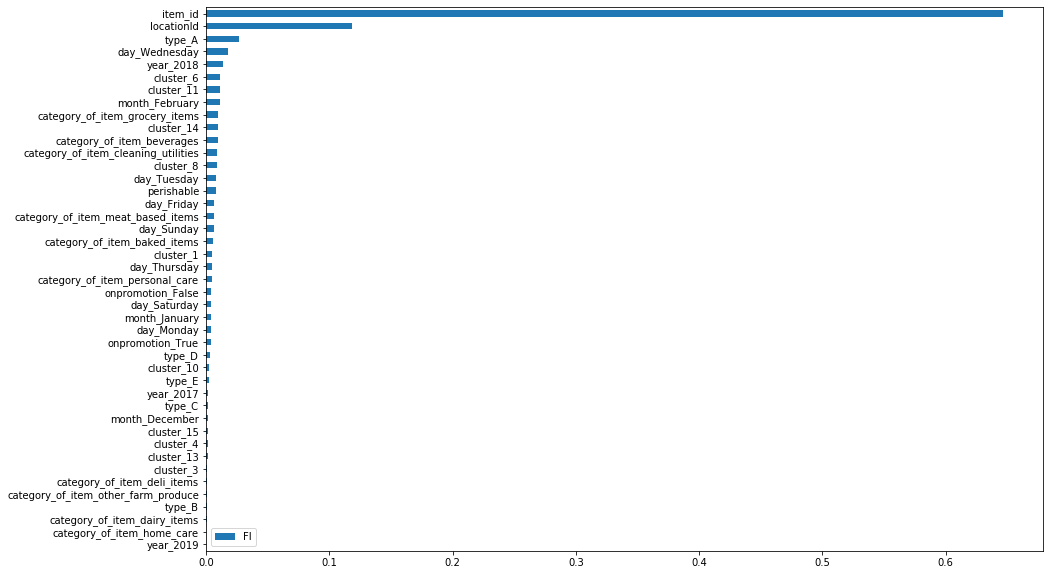

In [0]:
features = pd.DataFrame(dt_reg1.feature_importances_, columns = ['FI'], index = train_x.columns).sort_values('FI', ascending = True)
features.plot(kind = 'barh', figsize = (15,10))
del features

**Plotting Learning Curves**

([5.590458381473603,
  5.717068233127158,
  5.762688980727453,
  5.800393519270249,
  5.8246659294730465,
  5.82833410311025,
  5.848821416857377,
  5.85819844303475,
  5.861423287222042,
  5.921016542101456],
 [6.3826737528628,
  6.145304545794325,
  6.07498345770257,
  6.025403392057531,
  6.0036270876176525,
  5.9834194612084435,
  5.973915959763902,
  5.956267286038608,
  5.946368959990411,
  5.98948324927367])

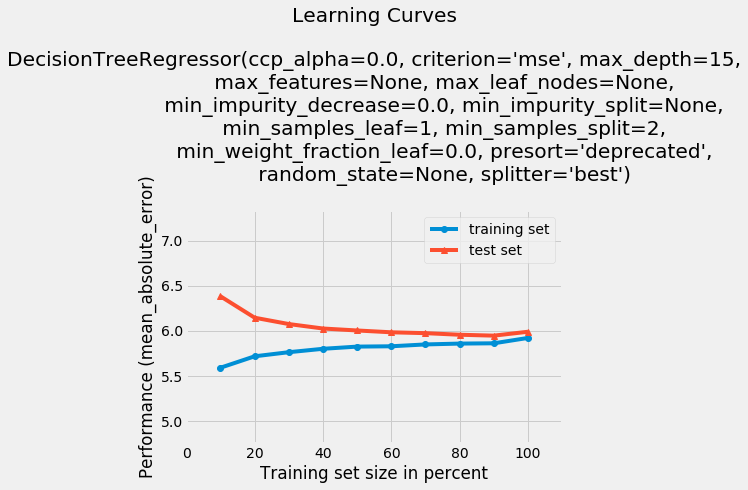

In [0]:
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(train_x, train_y, val_x, val_y, dt_reg1, scoring='mean_absolute_error')

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
create_backupfiles('dt_reg1',dt_reg1)
dt_reg1=reload_backupfiles('dt_reg1')

**Random Forest**

In [0]:
# Build Model
from sklearn.ensemble import RandomForestRegressor
rf1 = RandomForestRegressor(random_state=3,max_depth=6,min_samples_leaf=3)

# Fit model on train data
%time rf1.fit(train_x,train_y)
print(rf1.score)

# Predict target on train and val data
train_pred = rf1.predict(train_x)
val_pred = rf1.predict(val_x)

# Evaluate the model on train and val
train_pred=pd.DataFrame(train_pred)
val_pred=pd.DataFrame(val_pred)
ErrorMetrics(train_y.values,train_pred,val_y.values,val_pred)

CPU times: user 53min 41s, sys: 1.97 s, total: 53min 43s
Wall time: 53min 43s
<bound method RegressorMixin.score of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=3, verbose=0, warm_start=False)>
-----Train Error------
SSE: 478.9759416095814
RMSE: 21.88551899337965
MAE: 7.448499711050313
MAPE:  0    217.103651
dtype: float64
-----Validation Error------
SSE: 542.3828355808922
RMSE: 23.289114100388023
MAE: 7.427718794528491
MAPE:  0    216.761885
dtype: float64


**Plotting important features**

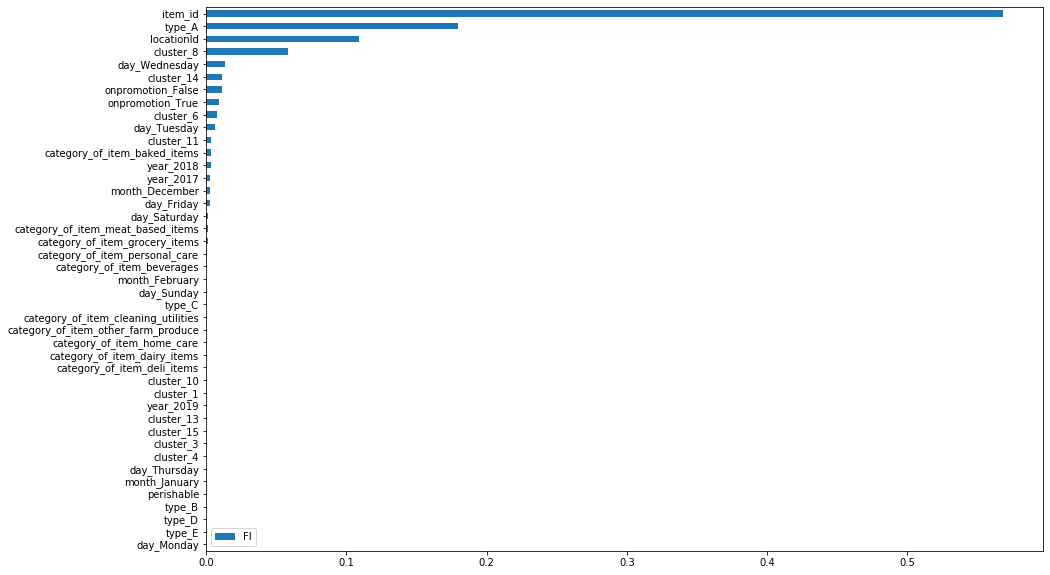

In [0]:
features = pd.DataFrame(rf1.feature_importances_, columns = ['FI'], index = train_x.columns).sort_values('FI', ascending = True)
features.plot(kind = 'barh', figsize = (15,10))
del features

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
create_backupfiles('rf1',rf1)
rf1=reload_backupfiles('rf1')

**Gradient Boosting Regressor**

In [0]:
# Build Model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
gb= GradientBoostingRegressor(n_estimators=200,learning_rate=0.002,max_depth=6,max_leaf_nodes=15)

# Fit model on train data
%time gb.fit(train_x,train_y)
print(gb.score)

# Predict target on train and val data
train_pred = gb.predict(train_x)
val_pred = gb.predict(val_x)

# Evaluate the model on train and val
train_pred=pd.DataFrame(train_pred)
val_pred=pd.DataFrame(val_pred)
ErrorMetrics(train_y.values,train_pred,val_y.values,val_pred)

<bound method RegressorMixin.score of GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.002, loss='ls',
                          max_depth=6, max_features=None, max_leaf_nodes=15,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)>
-----Train Error------
SSE: 498.4019198480043
RMSE: 22.324917017718214
MAE: 7.813271149287712
MAPE:  0    245.265067
dtype: float64
-----Validation Error------
SSE: 561.5588366605227
RMSE: 23.69723267937678
MAE: 7.789487728787394
MAPE:  0    244.892874
dtype: float64


**XG Boost**

In [0]:
from xgboost.sklearn import XGBRegressor
xgb1 = XGBRegressor(random_state=6,n_estimators=100,learning_rate=0.001)

# Fit model on train data
%time xgb1.fit(train_x,train_y)
print(xgb1.score)

# Predict target on train and val data
train_pred = xgb1.predict(train_x)
val_pred = xgb1.predict(val_x)

# Evaluate the model on train and val
train_pred=pd.DataFrame(train_pred)
val_pred=pd.DataFrame(val_pred)
ErrorMetrics(train_y.values,train_pred,val_y.values,val_pred)

[19:05:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:10] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
CPU times: user 45min 56s, sys: 7.59 s, total: 46min 4s
Wall time: 46min 4s
<bound method RegressorMixin.score of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.001, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=6,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)>
-----Train Error------
SSE: 564.2608
RMSE: 23.754175
MAE: 7.

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
create_backupfiles('xgb1',xgb1)
xgb1=reload_backupfiles('xgb1')

[19:57:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


**Pre-processing for Neural Networks**

**Functions to reduce memory consumption**

In [0]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if col_type == 'datetime64[ns]':
              print ("")
            elif str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Loading the train data**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD")
train=pd.read_csv('train.csv')

**Working on last one year data**

In [0]:
train=train[(train['date'] >= '2018-01-01') & (train['date'] <= '2018-12-31')]

**For any time series data we should have continuous data.**

**Since we took one year data of 2018- the expectation is to have 365 dates**

In [0]:
print(len(train.date.unique()))

364


**Notice that there is a missing date**

**Let us impute values for this date**

In [0]:
import datetime
from datetime import date, timedelta
#add missing date
min_date = min(train.date)
max_date = max(train.date)

calendar = []

d1 = datetime.datetime.strptime(min_date, '%Y-%m-%d')  
d2 = datetime.datetime.strptime(max_date, '%Y-%m-%d')

delta = d2 - d1         # timedelta

for i in range(delta.days + 1):
    calendar.append(datetime.date.strftime(d1 + timedelta(days=i), '%Y-%m-%d'))

calendar = pd.DataFrame({'date':calendar})

train = calendar.merge(train, left_on='date', right_on='date', how='left')

**Now check that the missing date gets imputed**

In [0]:
print(len(train.date.unique()))

365


In [0]:
train.shape

(35229872, 5)

In [0]:
train.head()

,date,locationId,item_id,unit_sales,onpromotion
0,2018-01-01,location_25,item_105574,12.0,False
1,2018-01-01,location_25,item_105575,9.0,False
2,2018-01-01,location_25,item_105857,3.0,False
3,2018-01-01,location_25,item_108634,3.0,False
4,2018-01-01,location_25,item_108701,2.0,True


**Modifying existing columns and generating new columns**

In [0]:
import datetime
def process_data(data):
  data.date=pd.to_datetime(data['date'])
  data['day'] = data.date.dt.day_name()
  data['month'] = data.date.dt.strftime('%B')
  data['year'] = data.date.dt.year

In [0]:
process_data(train)

In [0]:
train.head()

,date,locationId,item_id,unit_sales,onpromotion,day,month,year
0,2018-01-01,location_25,item_105574,12.0,False,Monday,January,2018
1,2018-01-01,location_25,item_105575,9.0,False,Monday,January,2018
2,2018-01-01,location_25,item_105857,3.0,False,Monday,January,2018
3,2018-01-01,location_25,item_108634,3.0,False,Monday,January,2018
4,2018-01-01,location_25,item_108701,2.0,True,Monday,January,2018


**Droppping unwanted columns**

In [0]:
train.drop(['date'],axis=1,inplace=True)

In [0]:
train.dtypes

locationId      object
item_id         object
unit_sales     float64
onpromotion     object
day             object
month           object
year             int64
dtype: object

**Understanding train data**

In [0]:
def understand_data(data) :
    return(pd.DataFrame({"Datatype":data.dtypes,"No of NAs":data.isna().sum(),"No of Levels":data.apply(lambda x: x.nunique(),axis=0),"Levels":data.apply(lambda x: str(x.unique()),axis=0)}))

In [0]:
understand_data(train)

**Null Value Handling**

In [0]:
def total_NAs(data) :
    print ("Total NAs:",data.isna().sum().sum())

In [0]:
total_NAs(train)

Total NAs: 4


In [0]:
train.isna().sum()

locationId     1
item_id        1
unit_sales     1
onpromotion    1
day            0
month          0
year           0
dtype: int64

**For the date we have imputed all other columns are missing, let us impute values for them too**

In [0]:
#Check index to apply the formula
na_index_train = train[train['unit_sales'].isnull() == True].index.values

#Define the index to use to apply the formala
na_index_train_plus = na_index_train.copy()
na_index_train_minus = np.maximum(0, na_index_train-1)

for i in range(len(na_index_train)):
    k = 1
    while (na_index_train[min(i+k,len(na_index_train)-1)] == na_index_train[i]+k):
        k += 1
    na_index_train_plus[i] = min(len(train)-1, na_index_train_plus[i] + k )

#Apply the formula
for i in range(len(na_index_train)):
    if (na_index_train[i] == 0):
        train.loc[na_index_train[i], 'unit_sales'] = train.loc[na_index_train_plus[i], 'unit_sales']
    elif (na_index_train[i] == len(train)):
        train.loc[na_index_train[i], 'unit_sales'] = train.loc[na_index_train_minus[i], 'unit_sales']
    else:
        train.loc[na_index_train[i], 'unit_sales'] = (train.loc[na_index_train_plus[i], 'unit_sales'] + train.loc[na_index_train_minus[i], 'unit_sales'])/ 2    

**Impute values for onpromotion as False**

In [0]:
train.onpromotion.fillna(value=False,inplace=True)

In [0]:
print(train.isnull().sum(), '\n')

locationId     1
item_id        1
unit_sales     0
onpromotion    0
day            0
month          0
year           0
dtype: int64 



**Call memory optimaztion function to reduce file size**

In [0]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 3195.08 MB
Memory usage after optimization is: 1985.74 MB
Decreased by 37.8%


**Checking Summary statistics**

In [0]:
train.describe(include='all')

,locationId,item_id,unit_sales,onpromotion,day,month,year
count,35229871,35229871,3.522987e+07,35229872.0,35229872,35229872,35229872.0
unique,53,3886,NaN,NaN,7,12,NaN
top,location_44,item_502331,NaN,NaN,Monday,December,NaN
freq,964732,19092,NaN,NaN,5284154,3178500,NaN
mean,NaN,NaN,7.146758e+00,NaN,NaN,NaN,2018.0
std,NaN,NaN,2.828991e+01,0.0,NaN,NaN,0.0
min,NaN,NaN,-4.673000e+03,0.0,NaN,NaN,2018.0
25%,NaN,NaN,2.000000e+00,0.0,NaN,NaN,2018.0
50%,NaN,NaN,4.000000e+00,0.0,NaN,NaN,2018.0
75%,NaN,NaN,8.000000e+00,0.0,NaN,NaN,2018.0


**Taking text backup and storing backedup files in the created folder path**


In [0]:
def create_backupfiles(filename,dfin):
  outfile=open(filename,'wb')
  pkl.dump(dfin,outfile)
  outfile.close()

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
create_backupfiles('train',train)

**Verifty whether files are created or not**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
print(os.getcwd())
!ls -lrt

/content/drive/My Drive/PHD/MemoryReducedFiles
total 722574
-rw------- 1 root root 739915400 Feb 19 07:37 train


**Reload backedup data**

In [0]:
def reload_backupfiles(filename):
  infile=open(filename,'rb')
  dfout=pkl.load(infile)
  infile.close()
  return(dfout)

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
train=reload_backupfiles('train')

In [0]:
import gc
gc.collect()

470

**Loading and Understanding test data**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD")
test=pd.read_csv('test.csv')

In [0]:
total_NAs(test)

Total NAs: 0


In [0]:
test.shape

(1482295, 5)

In [0]:
understand_data(test)

,Datatype,No of NAs,No of Levels,Levels
id,int64,0,1482295,[0 1 2 ... 1482292 1482293 1482294]
date,object,0,15,['2019-01-01' '2019-01-02' '2019-01-03' '2019-...
locationId,object,0,53,['location_25' 'location_1' 'location_2' 'loca...
item_id,object,0,3828,['item_99197' 'item_103665' 'item_105574' ... ...
onpromotion,bool,0,2,[False True]


**Modifying existing features and generating new features out of the existing for test data**

In [0]:
process_data(test)

In [0]:
test.dtypes

id                      int64
date           datetime64[ns]
locationId             object
item_id                object
onpromotion              bool
day                    object
month                  object
year                    int64
dtype: object

**Check for continuous date values in test data**

In [0]:
print(test.date.unique())
print(len(test.date.unique()))

['2019-01-01T00:00:00.000000000' '2019-01-02T00:00:00.000000000'
 '2019-01-03T00:00:00.000000000' '2019-01-04T00:00:00.000000000'
 '2019-01-05T00:00:00.000000000' '2019-01-06T00:00:00.000000000'
 '2019-01-07T00:00:00.000000000' '2019-01-08T00:00:00.000000000'
 '2019-01-09T00:00:00.000000000' '2019-01-10T00:00:00.000000000'
 '2019-01-11T00:00:00.000000000' '2019-01-12T00:00:00.000000000'
 '2019-01-13T00:00:00.000000000' '2019-01-14T00:00:00.000000000'
 '2019-01-15T00:00:00.000000000']
15


In [0]:
test.drop('date',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

**Memory optimization for test data**

In [0]:
test=reduce_mem_usage(test)

Memory usage of dataframe is 57.96 MB
Memory usage after optimization is: 12.91 MB
Decreased by 77.7%


In [0]:
test.shape

(1482295, 6)

In [0]:
understand_data(test)

,Datatype,No of NAs,No of Levels,Levels
locationId,category,0,53,"[location_25, location_1, location_2, location..."
item_id,category,0,3828,"[item_99197, item_103665, item_105574, item_10..."
onpromotion,float16,0,2,[0. 1.]
day,category,0,7,"[Tuesday, Wednesday, Thursday, Friday, Saturda..."
month,category,0,1,"[January]\nCategories (1, object): [January]"
year,int16,0,1,[2019]


**Create backup for test data**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
create_backupfiles('test',test)

**Reload backuped data**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD/MemoryReducedFiles")
test=reload_backupfiles('test')
import gc
gc.collect()

0

**Neural Networks Model Building**



1.   For datasets with mixed datatypes - neural networks pre-processing is different from the regular machine learning models.
2.   Categorical variables should be processed through categorical embeddings.
3.   Text variables should be process through word embedding models like word2vec.
4.   All these embedding layer outputs should be concatenated with the regular numerical and other categorical variables with less levels(dummified variables)
5.   Then Neural Networks model should be train on all of them.



In [0]:
def convert_other_categ(data,other_categ_cols) :
    for i in other_categ_cols :
        data[other_categ_cols]=data[other_categ_cols].astype('str').astype('category')
    print (data.select_dtypes(include='category').columns, "columns are converted to categorical")

In [0]:
cat_cols=['day','month','year','onpromotion','item_id','locationId']
convert_other_categ(train,cat_cols)
convert_other_categ(test,cat_cols)
train.unit_sales=train.unit_sales.astype('float32')

Index(['locationId', 'item_id', 'onpromotion', 'day', 'month', 'year'], dtype='object') columns are converted to categorical
Index(['locationId', 'item_id', 'onpromotion', 'day', 'month', 'year'], dtype='object') columns are converted to categorical


In [0]:
print(train.dtypes)
print(test.dtypes)

locationId     category
item_id        category
unit_sales      float32
onpromotion    category
day            category
month          category
year           category
dtype: object
locationId     category
item_id        category
onpromotion    category
day            category
month          category
year           category
dtype: object




1.   Seperating the variables locationId and item_id which has more levels/categories.
2.   They will be encodded and processed using categorical embeddings.
3.   Label encoding is used for encoding them.



In [0]:
categorical=train.select_dtypes('category').columns
categorical=categorical.drop(['locationId','item_id'])
categorical

Index(['onpromotion', 'day', 'month', 'year'], dtype='object')

In [0]:
train.columns

Index(['locationId', 'item_id', 'unit_sales', 'onpromotion', 'day', 'month',
       'year'],
      dtype='object')



1.   Train-test split for Nueral network models with variables of mixed data types should split them seperately. 
2.   They are processed differently before they all are trained together.




In [0]:
train_cat,val_cat,\
train_locationId,val_locationId,\
train_itemId,val_itemId,\
train_target,val_target= train_test_split(train[categorical],train['locationId'],
                                          train['item_id'],train['unit_sales'],
                                          test_size=0.2,random_state=1234)

In [0]:
print(train_cat.shape)
print("\n")
print(val_cat.shape)
print("\n")
print(train_locationId.shape)
print("\n")
print(val_locationId.shape)
print("\n")
print(train_itemId.shape)
print("\n")
print(val_itemId.shape)
print("\n")
print(train_target.shape)
print("\n")
print(val_target.shape)
print("\n")

(28183897, 4)


(7045975, 4)


(28183897,)


(7045975,)


(28183897,)


(7045975,)


(28183897,)


(7045975,)






1.   We also split the test data so as to pre-process them seperately.
2.   Categircal variables (with multiple levels) in test data are pre-processed using the same categorical embedding layer along with train data.



In [0]:
test_cat,test_locationId,test_itemId=test[categorical],test['locationId'],test['item_id']

In [0]:
print(test_cat.shape)
print("\n")
print(test_locationId.shape)
print("\n")
print(test_itemId.shape)
print("\n")

(1482295, 4)


(1482295,)


(1482295,)




**Dealing with target variable**


   Reshape(-1,1) is used if our data has a single feature/column. It gives a new shape without changing the data.


In [0]:
y_train=train_target.get_values().reshape(-1, 1)
y_val=val_target.get_values().reshape(-1, 1)

**Dealing with other categorical variables (which are not processed through categorical embeddings)**

In [0]:
train_cat.head(5)

,onpromotion,day,month,year
4820152,0.0,Thursday,February,2018
19882472,0.0,Saturday,July,2018
9317945,0.0,Monday,April,2018
20301852,0.0,Wednesday,August,2018
16552970,0.0,Sunday,June,2018


In [0]:
train_cat.columns

Index(['onpromotion', 'day', 'month', 'year'], dtype='object')



1.   Neural networks models/other machine learning models accept only numerical inputs. 
2.   Since they have less levels, we use onehotencoding to encode them.
3.   We fit them on train and transform on train and test.



In [0]:
ohe=OneHotEncoder(handle_unknown='ignore',)
ohe_fit=ohe.fit(train_cat)
train_cate=ohe_fit.transform(train_cat).toarray()
train_cate

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [0]:
val_cate=ohe_fit.transform(val_cat).toarray()
val_cate

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 1., 0., 1.]])

In [0]:
test_cate=ohe_fit.transform(test_cat).toarray()
test_cate

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [0]:
X_traindata=train_cate
X_valdata=val_cate
X_testdata=test_cate

print(X_traindata.shape)
print(X_valdata.shape)
print(X_testdata.shape)

(28183897, 22)
(7045975, 22)
(1482295, 22)


**Dealing with categ variables with multiple levels using categorical embeddings**



1.   Here we are using Label Encoder to encode the variables.
2.   For the label encodder to detect the new levels in test, we are encoding based on the levels in train,val and test.
3.   We fit the encoder on that concatenated list which has levels from train, val and test and transform on train, val and test column.



**Encoding item_id**

In [0]:
def setdiff_sorted(array1,array2,assume_unique=False):
  ans=np.setdiff1d(array1,array2,assume_unique).tolist()
  if assume_unique:
    return sorted(ans)
  return ans

In [0]:
train_item_levels=train['item_id'].cat.categories.tolist()
test_item_levels=test['item_id'].cat.categories.tolist()
new_item_levels=setdiff_sorted(test_item_levels,train_item_levels)
total_item_levels=train_item_levels+new_item_levels
print('\nItems in train:\n')
print(len(train_item_levels))
print('\nItems in test:\n')
print(len(test_item_levels))
print('\nItems in test only:\n')
print(len(new_item_levels))
print('\nTotal items in train and test are:\n')
print(len(total_item_levels))


Items in train:

3887

Items in test:

3828

Items in test only:

4

Total items in train and test are:

3891


In [0]:
itemId_enc=LabelEncoder().fit(np.asarray(total_item_levels))
train_itemId_enc=itemId_enc.transform(train_itemId)
val_itemId_enc=itemId_enc.transform(val_itemId)
test_itemId_enc=itemId_enc.transform(test_itemId)

**Encoding locationId**

In [0]:
locationId_enc=LabelEncoder().fit(train['locationId'])
train_locationId_enc=locationId_enc.transform(train_locationId)
val_locationId_enc=locationId_enc.transform(val_locationId)
test_locationId_enc=locationId_enc.transform(test_locationId)

**Identifying the number of nodes needed in the input layer**





1.   Number of neurons/nodes needed in input layer for categorical embeddings is equal to the number of levels it has in train data.
2.   categorical embedding for item_id needs 3481 nodes.
3.   categorical embedding for locationId needs 53 nodes.





In [0]:
location_unique_id= np.size(np.unique(train['locationId']))
location_unique_id

54

In [0]:
item_unique_id= np.size(np.unique(total_item_levels))
item_unique_id

3891

**Creating Categorical Embeddings**

In [0]:
itemId_input = Input(shape=(1, ), name="itemId")
itemId_embed = Embedding(input_dim=item_unique_id, output_dim=50)(itemId_input)
itemId_embed_flat = Flatten()(itemId_embed)

In [0]:
cat_inputs = Input(shape=(X_traindata.shape[1],),name='cat_inputs')
out_cat = Dense(64, activation='relu')(cat_inputs)

In [0]:
locationId_input = Input(shape=(1, ), name="locationId")
locationId_embed = Embedding(input_dim=location_unique_id, output_dim=50)(locationId_input)
locationId_embed_flat = Flatten()(locationId_embed)

In [0]:
cat_inputs = Input(shape=(X_traindata.shape[1],),name='cat_inputs')
out_cat = Dense(64, activation='relu')(cat_inputs)

**NN Model 1: No regularization, Drop outs and weights initiliation.**

**Concating categorical embeddings with other numerical/categorical data and target.**

In [0]:
concatenated = concatenate([itemId_embed_flat,locationId_embed_flat,out_cat],axis=-1)
X = Dense(8, activation='relu')(concatenated)
final_out = Dense(1, activation='linear')(X)

**Create the model by passing the inputs - categorical embeddings, other features**

In [0]:
model = Model(inputs=[itemId_input,locationId_input,cat_inputs], outputs=final_out)

**Check the model summary**

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
itemId (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
locationId (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        194550      itemId[0][0]                     
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        2700        locationId[0][0]                 
____________________________________________________________________________________________

**Compile the model by specifying the loss function, optimizer and metrics**

In [0]:
model.compile(loss='mape', optimizer='adam', metrics=['mape'])

**Fit the model on train predictors and target.**



1.   By using ModelCheckpoint we can instruct the model to update only when the loss function improves i.e., loss decreases. 
2.   Otherwise the last encountered value, even though it is not the one with least error, will determine the set of weights. 



In [0]:
from keras.callbacks import ModelCheckpoint
check2=ModelCheckpoint("weights.{epoch:02d}-{val_loss:.2f}.hdf5",save_best_only=True,
                      monitor='val_loss',mode='min')

model.fit([train_itemId_enc,train_locationId_enc,X_traindata], y=y_train, 
          callbacks=[check2],epochs=50,batch_size=200000,validation_split=0.2)

Train on 22547117 samples, validate on 5636780 samples
Epoch 1/50
22547117/22547117 [==============================] - 35s 2us/step - loss: 66.6886 - mean_absolute_percentage_error: 66.6886 - val_loss: 58.3926 - val_mean_absolute_percentage_error: 58.3926
Epoch 2/50
22547117/22547117 [==============================] - 34s 1us/step - loss: 57.5333 - mean_absolute_percentage_error: 57.5333 - val_loss: 56.7867 - val_mean_absolute_percentage_error: 56.7867
Epoch 3/50
22547117/22547117 [==============================] - 34s 2us/step - loss: 56.1965 - mean_absolute_percentage_error: 56.1965 - val_loss: 55.6597 - val_mean_absolute_percentage_error: 55.6597
Epoch 4/50
22547117/22547117 [==============================] - 34s 2us/step - loss: 55.3614 - mean_absolute_percentage_error: 55.3614 - val_loss: 55.1310 - val_mean_absolute_percentage_error: 55.1310
Epoch 5/50
22547117/22547117 [==============================] - 34s 2us/step - loss: 55.0078 - mean_absolute_percentage_error: 55.0078 - val_

**Evaluate the model performance on train and validation data**

In [0]:
model.evaluate([train_itemId_enc,train_locationId_enc,X_traindata], y=y_train)

28183897/28183897 [==============================] - 365s 13us/step


[52.51943563838164, 52.51943563838164]

In [0]:
model.evaluate([val_itemId_enc,val_locationId_enc,X_valdata], y=y_val)

7045975/7045975 [==============================] - 91s 13us/step


[52.63247274667846, 52.63247274667846]

**Make predictions on train and validation data**

In [0]:
pred_train=model.predict([train_itemId_enc,train_locationId_enc,X_traindata])
pred_train[1:10]

array([[ 1.0011294],
       [ 1.0222255],
       [ 1.0058568],
       [ 1.9954103],
       [ 1.0064806],
       [17.05977  ],
       [ 1.9928807],
       [ 3.0409825],
       [ 1.0628778]], dtype=float32)

In [0]:
pred_val=model.predict([val_itemId_enc,val_locationId_enc,X_valdata])
pred_val[1:10]

array([[ 1.0047024],
       [ 1.0008813],
       [ 4.6650615],
       [ 1.000919 ],
       [ 0.9994999],
       [ 1.0030804],
       [11.940683 ],
       [ 7.040632 ],
       [ 3.6739712]], dtype=float32)

**Compute train and validation Errors**

In [0]:
def ErrorMetrics(train_y,train_pred,val_y,val_pred):
    print("-----Train Error------")
    print("SSE:", mean_squared_error(train_y, train_pred))
    print("RMSE:", np.sqrt(mean_squared_error(train_y, train_pred)))
    print("MAE:", mean_absolute_error(train_y, train_pred))
    print ('MAPE: ',np.mean(np.abs((train_y - train_pred)/train_y))*100)
    
    print("-----Validation Error------")
    print("SSE:", mean_squared_error(val_y, val_pred))
    print("RMSE:", np.sqrt(mean_squared_error(val_y, val_pred)))
    print("MAE:", mean_absolute_error(val_y, val_pred))
    print ('MAPE: ',np.mean(np.abs((val_y - val_pred)/val_y))*100)

In [0]:
ErrorMetrics(y_train,pred_train,y_val,pred_val)

-----Train Error------
SSE: 574.5499
RMSE: 23.96977
MAE: 5.493489
MAPE:  52.51932144165039
-----Validation Error------
SSE: 1650.7053
RMSE: 40.628872
MAE: 5.5089474
MAPE:  52.63245105743408


In [0]:
pred_test=model.predict([test_itemId_enc,test_locationId_enc,X_testdata])
pred_test[1:10]

array([[0.78354204],
       [1.7693478 ],
       [0.768533  ],
       [1.7613441 ],
       [0.77258265],
       [1.7700138 ],
       [0.78586864],
       [0.76600075],
       [0.769012  ]], dtype=float32)

**NN Model 2: Adding regularization techniques and attempting**

**Concating categorical embeddings with other numerical/categorical data and target**

In [0]:
concatenated = concatenate([itemId_embed_flat,locationId_embed_flat,out_cat],axis=-1)
D1 = Dropout(0.2) (concatenated)
X = Dense(8, activation='relu',kernel_initializer='normal',kernel_regularizer=regularizers.l1(0.01))(D1)
D2 = Dropout(0.4) (X)
out_inter = Dense(4, activation='relu',kernel_initializer='normal') (D2)
final_out = Dense(1, activation='linear') (out_inter)

**Create the model by passing the inputs - categorical embeddings, other features**

In [0]:
model = Model(inputs=[itemId_input,locationId_input,cat_inputs], outputs=final_out)

**Check the model summary**

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
itemId (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
locationId (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        194550      itemId[0][0]                     
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        2700        locationId[0][0]                 
____________________________________________________________________________________________

**Compile the model by specifying the loss function, optimizer and metrics**

In [0]:
model.compile(loss='mape', optimizer='adam', metrics=['mse'])

**Fit the model on train predictors and target.**



1.   By using ModelCheckpoint we can instruct the model to update only when the loss function improves i.e., loss decreases. 
2.   Otherwise the last encountered value, even though it is not the one with least error, will determine the set of weights. 



In [0]:
from keras.callbacks import ModelCheckpoint
check2=ModelCheckpoint("weights.{epoch:02d}-{val_loss:.2f}.hdf5",save_best_only=True,
                      monitor='val_loss',mode='min')

model.fit([train_itemId_enc,train_locationId_enc,X_traindata], y=y_train, 
          callbacks=[check2],epochs=50,batch_size=200000,validation_split=0.2)

Train on 22547117 samples, validate on 5636780 samples
Epoch 1/50
22547117/22547117 [==============================] - 40s 2us/step - loss: 79.1827 - mean_squared_error: 666.0567 - val_loss: 63.5016 - val_mean_squared_error: 665.1344
Epoch 2/50
22547117/22547117 [==============================] - 39s 2us/step - loss: 65.9564 - mean_squared_error: 655.3305 - val_loss: 60.6402 - val_mean_squared_error: 658.5962
Epoch 3/50
22547117/22547117 [==============================] - 39s 2us/step - loss: 63.9304 - mean_squared_error: 648.1482 - val_loss: 58.4627 - val_mean_squared_error: 651.2111
Epoch 4/50
22547117/22547117 [==============================] - 40s 2us/step - loss: 62.2050 - mean_squared_error: 641.5058 - val_loss: 57.5831 - val_mean_squared_error: 643.8379
Epoch 5/50
22547117/22547117 [==============================] - 39s 2us/step - loss: 60.3941 - mean_squared_error: 633.7905 - val_loss: 57.2279 - val_mean_squared_error: 637.3352
Epoch 6/50
22547117/22547117 [====================

**NN Model3: Clipping negative records with minimum value and applying log transformation**

In [0]:
print("total no of records in train are:\n")
print(train.shape[0])
print("\nout of which records with negative sales are:\n")
print(train[train.unit_sales<0].shape[0])
print("\nPercertange of records with negative sales out of the total is:\n")
print(((train[train.unit_sales<0].shape[0])/train.shape[0])*100)

total no of records in train are:

35229872

out of which records with negative sales are:

2246

Percertange of records with negative sales out of the total is:

0.006375271530932613


**Let us check the distribution of target when there are no negative records**

In [0]:
train_no_negsales=train[train.unit_sales>0]
train_no_negsales.shape

(35227626, 7)

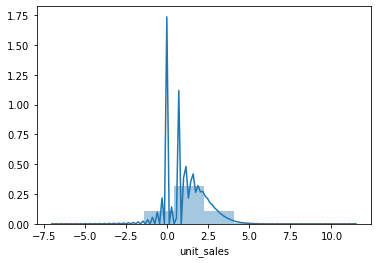

In [0]:
sns.distplot(np.log(train_no_negsales['unit_sales']),bins=10,kde=True)




1. At this point since we are can't certainly determine whether unit_sales are negative due to returns or mis entered, instead of changing them to positive sales, which might have more impact, we shall update their unit_sales to a very less value(say 0.00001)

2. We don't want to drop those records all together because we don't want to have any missing dates.




In [0]:
train['unit_sales']=train['unit_sales'].apply(lambda x: np.log1p(x) if x>0 else 0.00001)

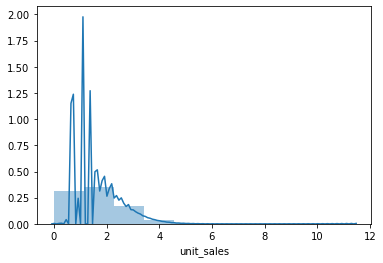

In [0]:
sns.distplot(train['unit_sales'],bins=10,kde=True)

**Neural Networks Model Building**



1.   For datasets with mixed datatypes - neural networks pre-processing is different from the regular machine learning models.
2.   Categorical variables should be processed through categorical embeddings.
3.   Text variables should be process through word embedding models like word2vec.
4.   All these embedding layer outputs should be concatenated with the regular numerical and other categorical variables with less levels(dummified variables)
5.   Then Neural Networks model should be train on all of them.



In [0]:
def convert_other_categ(data,other_categ_cols) :
    for i in other_categ_cols :
        data[other_categ_cols]=data[other_categ_cols].astype('str').astype('category')
    print (data.select_dtypes(include='category').columns, "columns are converted to categorical")

In [0]:
cat_cols=['day','month','year','onpromotion','item_id','locationId']
convert_other_categ(train,cat_cols)
convert_other_categ(test,cat_cols)
train.unit_sales=train.unit_sales.astype('float32')

Index(['locationId', 'item_id', 'onpromotion', 'day', 'month', 'year'], dtype='object') columns are converted to categorical
Index(['locationId', 'item_id', 'onpromotion', 'day', 'month', 'year'], dtype='object') columns are converted to categorical


In [0]:
print(train.dtypes)
print(test.dtypes)

locationId     category
item_id        category
unit_sales      float32
onpromotion    category
day            category
month          category
year           category
dtype: object
locationId     category
item_id        category
onpromotion    category
day            category
month          category
year           category
dtype: object




1.   Seperating the variables locationId and item_id which has more levels/categories.
2.   They will be encodded and processed using categorical embeddings.
3.   Label encoding is used for encoding them.



In [0]:
categorical=train.select_dtypes('category').columns
categorical=categorical.drop(['locationId','item_id'])
categorical

Index(['onpromotion', 'day', 'month', 'year'], dtype='object')

In [0]:
train.columns

Index(['locationId', 'item_id', 'unit_sales', 'onpromotion', 'day', 'month',
       'year'],
      dtype='object')



1.   Train-test split for Nueral network models with variables of mixed data types should split them seperately. 
2.   They are processed differently before they all are trained together.




In [0]:
train_cat,val_cat,\
train_locationId,val_locationId,\
train_itemId,val_itemId,\
train_target,val_target= train_test_split(train[categorical],train['locationId'],
                                          train['item_id'],train['unit_sales'],
                                          test_size=0.2,random_state=1234)

In [0]:
print(train_cat.shape)
print("\n")
print(val_cat.shape)
print("\n")
print(train_locationId.shape)
print("\n")
print(val_locationId.shape)
print("\n")
print(train_itemId.shape)
print("\n")
print(val_itemId.shape)
print("\n")
print(train_target.shape)
print("\n")
print(val_target.shape)
print("\n")

(28183897, 4)


(7045975, 4)


(28183897,)


(7045975,)


(28183897,)


(7045975,)


(28183897,)


(7045975,)






1.   We also split the test data so as to pre-process them seperately.
2.   Categircal variables (with multiple levels) in test data are pre-processed using the same categorical embedding layer along with train data.



In [0]:
test_cat,test_locationId,test_itemId=train[categorical],train['locationId'],train['item_id']

In [0]:
print(test_cat.shape)
print("\n")
print(test_locationId.shape)
print("\n")
print(test_itemId.shape)
print("\n")

(35229872, 4)


(35229872,)


(35229872,)




**Dealing with target variable**


   Reshape(-1,1) is used if our data has a single feature/column. It gives a new shape without changing the data.


In [0]:
y_train=train_target.get_values().reshape(-1, 1)
y_val=val_target.get_values().reshape(-1, 1)

**Dealing with other categorical variables (which are not processed through categorical embeddings)**

In [0]:
train_cat.head(5)

,onpromotion,day,month,year
4820152,0.0,Thursday,February,2018
19882472,0.0,Saturday,July,2018
9317945,0.0,Monday,April,2018
20301852,0.0,Wednesday,August,2018
16552970,0.0,Sunday,June,2018


In [0]:
train_cat.columns

Index(['onpromotion', 'day', 'month', 'year'], dtype='object')



1.   Neural networks models/other machine learning models accept only numerical inputs. 
2.   Since they have less levels, we use onehotencoding to encode them.
3.   We fit them on train and transform on train and test.



In [0]:
ohe=OneHotEncoder(handle_unknown='ignore',)
ohe_fit=ohe.fit(train_cat)
train_cate=ohe_fit.transform(train_cat).toarray()
train_cate

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [0]:
val_cate=ohe_fit.transform(val_cat).toarray()
val_cate

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 1., 0., 1.]])

In [0]:
test_cate=ohe_fit.transform(test_cat).toarray()
test_cate

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [0]:
X_traindata=train_cate
X_valdata=val_cate
X_testdata=test_cate

print(X_traindata.shape)
print(X_valdata.shape)
print(X_testdata.shape)

(28183897, 22)
(7045975, 22)
(35229872, 22)


**Dealing with categ variables with multiple levels using categorical embeddings**



1.   Here we are using Label Encoder to encode the variables.
2.   For the label encodder to detect the new levels in test, we are encoding based on the levels in train,val and test.
3.   We fit the encoder on that concatenated list which has levels from train, val and test and transform on train, val and test column.



**Encoding item_id**

In [0]:
def setdiff_sorted(array1,array2,assume_unique=False):
  ans=np.setdiff1d(array1,array2,assume_unique).tolist()
  if assume_unique:
    return sorted(ans)
  return ans

In [0]:
train_item_levels=train['item_id'].cat.categories.tolist()
test_item_levels=test['item_id'].cat.categories.tolist()
new_item_levels=setdiff_sorted(test_item_levels,train_item_levels)
total_item_levels=train_item_levels+new_item_levels
print('\nItems in train:\n')
print(len(train_item_levels))
print('\nItems in test:\n')
print(len(test_item_levels))
print('\nItems in test only:\n')
print(len(new_item_levels))
print('\nTotal items in train and test are:\n')
print(len(total_item_levels))


Items in train:

3887

Items in test:

3828

Items in test only:

4

Total items in train and test are:

3891


In [0]:
itemId_enc=LabelEncoder().fit(np.asarray(total_item_levels))
train_itemId_enc=itemId_enc.transform(train_itemId)
val_itemId_enc=itemId_enc.transform(val_itemId)
test_itemId_enc=itemId_enc.transform(test_itemId)

**Encoding locationId**

In [0]:
locationId_enc=LabelEncoder().fit(train['locationId'])
train_locationId_enc=locationId_enc.transform(train_locationId)
val_locationId_enc=locationId_enc.transform(val_locationId)
test_locationId_enc=locationId_enc.transform(test_locationId)

**Identifying the number of nodes needed in the input layer**





1.   Number of neurons/nodes needed in input layer for categorical embeddings is equal to the number of levels it has in train data.
2.   categorical embedding for item_id needs 3481 nodes.
3.   categorical embedding for locationId needs 53 nodes.





In [0]:
location_unique_id= np.size(np.unique(train['locationId']))
location_unique_id

54

In [0]:
item_unique_id= np.size(np.unique(total_item_levels))
item_unique_id

3891

**Creating Categorical Embeddings**

In [0]:
itemId_input = Input(shape=(1, ), name="itemId")
itemId_embed = Embedding(input_dim=item_unique_id, output_dim=50)(itemId_input)
itemId_embed_flat = Flatten()(itemId_embed)

In [0]:
cat_inputs = Input(shape=(X_traindata.shape[1],),name='cat_inputs')
out_cat = Dense(64, activation='relu')(cat_inputs)

In [0]:
locationId_input = Input(shape=(1, ), name="locationId")
locationId_embed = Embedding(input_dim=location_unique_id, output_dim=50)(locationId_input)
locationId_embed_flat = Flatten()(locationId_embed)

In [0]:
cat_inputs = Input(shape=(X_traindata.shape[1],),name='cat_inputs')
out_cat = Dense(64, activation='relu')(cat_inputs)

**Concating categorical embeddings with other numerical/categorical data and target**

In [0]:
concatenated = concatenate([itemId_embed_flat,locationId_embed_flat,out_cat],axis=-1)
X = Dense(8, activation='relu')(concatenated)
final_out = Dense(1, activation='linear')(X)

**Create the model by passing the inputs - categorical embeddings, other features**

In [0]:
model = Model(inputs=[itemId_input,locationId_input,cat_inputs], outputs=final_out)

**Check the model summary**

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
itemId (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
locationId (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        194550      itemId[0][0]                     
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 50)        2700        locationId[0][0]                 
____________________________________________________________________________________________

**Compile the model by specifying the loss function, optimizer and metrics**

In [0]:
model.compile(loss='mape', optimizer='adam', metrics=['mape'])

**Fit the model on train predictors and target.**



1.   By using ModelCheckpoint we can instruct the model to update only when the loss function improves i.e., loss decreases. 
2.   Otherwise the last encountered value, even though it is not the one with least error, will determine the set of weights. 



In [0]:
from keras.callbacks import ModelCheckpoint
check2=ModelCheckpoint("weights.{epoch:02d}-{val_loss:.2f}.hdf5",save_best_only=True,
                      monitor='val_loss',mode='min')

model.fit([train_itemId_enc,train_locationId_enc,X_traindata], y=y_val, 
          callbacks=[check2],epochs=50,batch_size=500000,validation_split=0.2)

Train on 22547117 samples, validate on 5636780 samples
Epoch 1/50
22547117/22547117 [==============================] - 30s 1us/step - loss: 95.6336 - mean_absolute_percentage_error: 95.6336 - val_loss: 94.5982 - val_mean_absolute_percentage_error: 94.5982
Epoch 2/50
22547117/22547117 [==============================] - 29s 1us/step - loss: 88.7853 - mean_absolute_percentage_error: 88.7853 - val_loss: 72.2539 - val_mean_absolute_percentage_error: 72.2539
Epoch 3/50
22547117/22547117 [==============================] - 29s 1us/step - loss: 63.3262 - mean_absolute_percentage_error: 63.3262 - val_loss: 60.8442 - val_mean_absolute_percentage_error: 60.8442
Epoch 4/50
22547117/22547117 [==============================] - 29s 1us/step - loss: 59.7734 - mean_absolute_percentage_error: 59.7734 - val_loss: 58.8623 - val_mean_absolute_percentage_error: 58.8623
Epoch 5/50
22547117/22547117 [==============================] - 29s 1us/step - loss: 58.5761 - mean_absolute_percentage_error: 58.5761 - val_

**Evaluate the model performance on train and validation data**

In [0]:
model.evaluate([train_itemId_enc,train_locationId_enc,X_traindata], y=train_target)

28183897/28183897 [==============================] - 353s 13us/step


[56.73325694452313, 56.73325694452313]

In [0]:
model.evaluate([val_itemId_enc,val_locationId_enc,X_valdata], y=val_target)

7045975/7045975 [==============================] - 87s 12us/step


[56.78660239854644, 56.78660239854644]

**Make predictions on train and validation data**

In [0]:
pred_train=model.predict([train_itemId_enc,train_locationId_enc,X_traindata])
pred_train[1:10]

array([[0.96713513],
       [1.0536696 ],
       [2.0041556 ],
       [1.0476167 ],
       [2.0094955 ],
       [8.074951  ],
       [1.5471509 ],
       [1.0762806 ],
       [2.01196   ]], dtype=float32)

In [0]:
pred_val=model.predict([val_itemId_enc,val_locationId_enc,X_valdata])
pred_val[1:10]

array([[1.053658 ],
       [1.0726194],
       [1.0685179],
       [0.9988724],
       [1.0367243],
       [1.0013771],
       [2.9874861],
       [2.0748909],
       [2.079945 ]], dtype=float32)

**Compute train and validation Errors**

In [0]:
def ErrorMetrics(train_y,train_pred,val_y,val_pred):
    print("-----Train Error------")
    print("SSE:", mean_squared_error(train_y, train_pred))
    print("RMSE:", np.sqrt(mean_squared_error(train_y, train_pred)))
    print("MAE:", mean_absolute_error(train_y, train_pred))
    print ('MAPE: ',np.mean(np.abs((train_y - train_pred)/train_y))*100)
    
    print("-----Validation Error------")
    print("SSE:", mean_squared_error(val_y, val_pred))
    print("RMSE:", np.sqrt(mean_squared_error(val_y, val_pred)))
    print("MAE:", mean_absolute_error(val_y, val_pred))
    print ('MAPE: ',np.mean(np.abs((val_y - val_pred)/val_y))*100)

In [0]:
ErrorMetrics(y_train,pred_train,y_val,pred_val)

-----Train Error------
SSE: 626.29565
RMSE: 25.0259
MAE: 6.310654
MAPE:  56.73332214355469
-----Validation Error------
SSE: 1702.766
RMSE: 41.264584
MAE: 6.3250585
MAPE:  56.78659677505493


**Forecasting unit sales for test data by using model Neural Networks model which got better results**

In [0]:
pred_test=model.predict([test_itemId_enc,test_locationId_enc,X_testdata])
pred_test[1:10]

array([[1.0003889],
       [2.0030415],
       [1.0997576],
       [1.3162252],
       [1.0003889],
       [1.054523 ],
       [1.233439 ],
       [1.0003889],
       [1.0003889]], dtype=float32)

In [0]:
Target=pd.DataFrame(pred_test,columns=['unit_sales'])

In [0]:
Target.shape

(1482295, 1)

In [0]:
os.chdir(r"/content/drive/My Drive/PHD")
test_backup=pd.read_csv('test.csv')
id=test_backup.id

In [0]:
NN_Predictions_best=pd.concat([id,Target],axis=1)
create_backupfiles('NN_Predictions_best',NN_Predictions_best)
NN_Predictions_best=reload_backupfiles('NN_Predictions_best')

In [0]:
NN_Predictions_best

,id,unit_sales
0,0,0.768797
1,1,0.783542
2,2,1.769348
3,3,0.768533
4,4,1.761344
...,...,...
1482290,1482290,0.725942
1482291,1482291,0.776028
1482292,1482292,0.764579
1482293,1482293,1.381141


In [0]:
NN_Predictions_best.to_csv('NeuralNetowrk_BestPredictions.csv')

##### Test EDA: Answering questions from the operations team at SmallBasket

**Importing the Required Libraries**

In [0]:
import os
import numpy as np
import pandas as pd
import shutil
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# To filter/truncate warnings
import warnings
warnings.filterwarnings('ignore')

**Changing the working directory and mount the drive and upload the train and test data**

In [0]:
os.chdir(r"C:\Users\pdrva\Desktop\Divya\INSOFE\PHD")

In [0]:
test=pd.read_csv("test.csv")

In [0]:
os.chdir(r"C:\Users\pdrva\Desktop\Divya\INSOFE\PHD\MemoryReducedFiles - January\Predictions")
NN_predictions=pd.read_csv("NeuralNetwork_BestPredictions.csv")

In [0]:
print(test.shape)
print(NN_predictions.shape)

(1482295, 5)
(1048575, 2)


In [0]:
test.columns

Index(['id', 'date', 'locationId', 'item_id', 'onpromotion'], dtype='object')

In [0]:
NN_predictions.columns

Index(['id', 'unit_sales'], dtype='object')

In [0]:
test_output=test.merge(NN_predictions,how='outer',on=['id'])

In [0]:
test_output.head()

,id,date,locationId,item_id,onpromotion,unit_sales
0,0,2019-01-01,location_25,item_99197,False,0.768797
1,1,2019-01-01,location_25,item_103665,False,0.783542
2,2,2019-01-01,location_25,item_105574,False,1.769348
3,3,2019-01-01,location_25,item_105857,False,0.768533
4,4,2019-01-01,location_25,item_106716,False,1.761344


In [0]:
print(test.shape)
print(test_output.shape)

(1482295, 5)
(1482295, 6)


In [0]:
os.chdir(r"C:\Users\pdrva\Desktop\Divya\INSOFE\PHD")
item_details=pd.read_csv("item_details.csv")
location_details=pd.read_csv("location_details.csv")

In [0]:
merged_test=test_output.merge(item_details,how='left',on=['item_id'])

In [0]:
location_details.columns=[x.replace('location_id','locationId') for x in location_details.columns]
merged_test=merged_test.merge(location_details,how='left',on=['locationId'])

In [0]:
merged_test.shape

(1482295, 13)

In [0]:
merged_test.head()

,id,date,locationId,item_id,onpromotion,unit_sales,category_of_item,class,perishable,city,state,type,cluster
0,0,2019-01-01,location_25,item_99197,False,0.768797,grocery_items,class_1067,0,Kanpur,Uttar Pradesh,D,1
1,1,2019-01-01,location_25,item_103665,False,0.783542,baked_items / bread_based,class_2712,1,Kanpur,Uttar Pradesh,D,1
2,2,2019-01-01,location_25,item_105574,False,1.769348,grocery_items,class_1045,0,Kanpur,Uttar Pradesh,D,1
3,3,2019-01-01,location_25,item_105857,False,0.768533,grocery_items,class_1092,0,Kanpur,Uttar Pradesh,D,1
4,4,2019-01-01,location_25,item_106716,False,1.761344,grocery_items,class_1032,0,Kanpur,Uttar Pradesh,D,1


In [0]:
merged_test.columns

Index(['id', 'date', 'locationId', 'item_id', 'onpromotion', 'unit_sales',
       'category_of_item', 'class', 'perishable', 'city', 'state', 'type',
       'cluster'],
      dtype='object')

In [0]:
merged_test.drop(['id'],axis=1,inplace=True)

##### <font color='green'> Question1: Business units belonging to which cluster will see the highest amount of  sales for the first 15 days of 2019? </font> 

In [0]:
merged_test.groupby(['type','cluster']).agg({'unit_sales':'sum'}).sort_values(by='unit_sales',ascending=False)

unit_sales
type cluster               
D    8        414119.716753
A    14       410900.637405
     11       348981.568789
B    6        261612.554365
D    13       231811.740509
A    5        207109.016436
C    3        149006.462507
D    1        141924.421893
E    10       136308.922804
D    4        119721.919599
     2        100565.794113
C    15       100411.282207
D    9         96944.530128
A    17        61277.609378
C    12        45705.749176
     7         39875.193700
B    16        36275.157485
     10        34414.095685
D    10        17646.589684

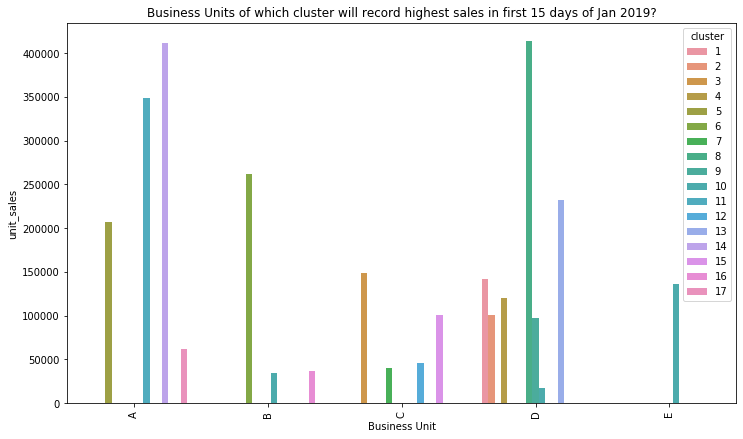

In [0]:
q1=(merged_test.groupby(['type','cluster']).agg({'unit_sales':'sum'}).reset_index())
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,7))
sns.barplot(q1.type,q1.unit_sales,hue=q1.cluster)
plt.xlabel('Business Unit')
plt.xticks(rotation='vertical')
plt.ylabel('unit_sales',)
plt.title('Business Units of which cluster will record highest sales in first 15 days of Jan 2019?')
plt.show()

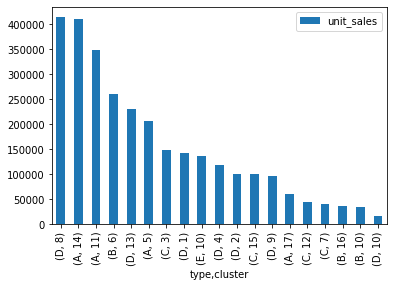

In [0]:
(merged_test.groupby(['type','cluster']).agg({'unit_sales':'sum'}).sort_values(by='unit_sales',ascending=False)).plot(kind='bar')

###### <font color='green'> Answer1: Business units of type D that belong to cluster 8 will record highest amount of sales in the first 15 days of January 2019 ! </font>

##### <font color='green'> Question2: What are the top 10 selling items in this cluster? </font>

In [0]:
q2=merged_test[merged_test.cluster==8].groupby('category_of_item').agg({'unit_sales':'sum'}).sort_values(by='unit_sales',ascending=False).head(10)
q2

,unit_sales
category_of_item,
grocery_items,118078.326983
other_farm_produce,71699.731198
beverages,70167.531139
dairy_items,37378.916671
cleaning_utilities,27102.136842
baked_items / bread_based,19015.491185
vegetables,12576.164626
meat_based_items,10864.336871
home_care,8332.655922


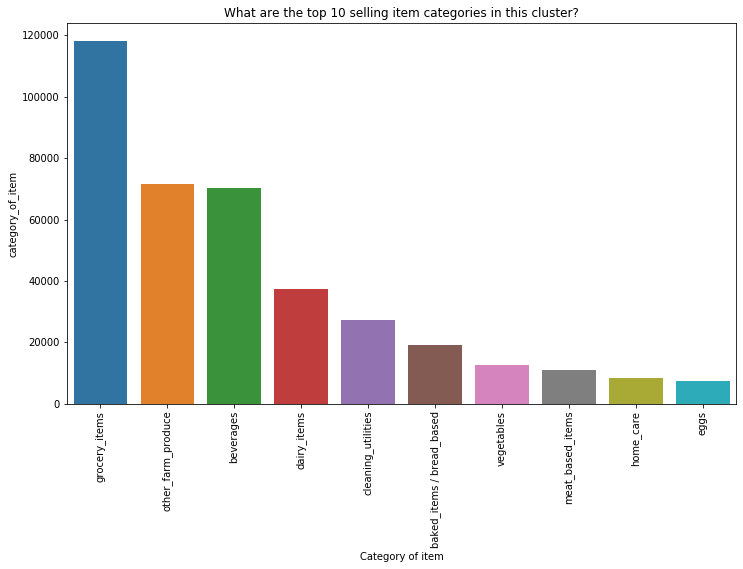

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,7))
sns.barplot(q2.index,q2.unit_sales)
plt.xlabel('Category of item')
plt.xticks(rotation='vertical')
plt.ylabel('category_of_item')
plt.title('What are the top 10 selling item categories in this cluster?')
plt.show()

In [0]:
q2=merged_test[merged_test.cluster==8].groupby('item_id').agg({'unit_sales':'sum'}).sort_values(by='unit_sales',ascending=False).head(10)
q2

,unit_sales
item_id,
item_364606,1393.975896
item_1473474,1337.405339
item_314384,1289.987909
item_502331,1275.735804
item_1463810,1249.568548
item_1463814,1186.988274
item_1695835,1159.880690
item_1473410,1137.984101
item_1473482,1083.473250


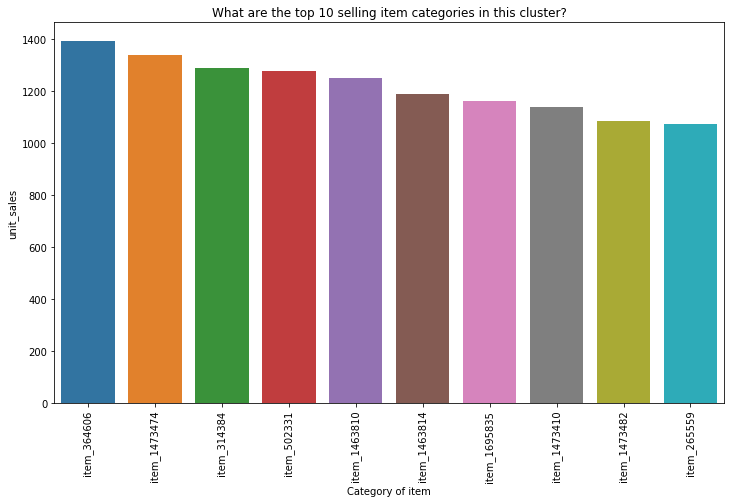

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,7))
sns.barplot(q2.index,q2.unit_sales)
plt.xlabel('Category of item')
plt.xticks(rotation='vertical')
plt.ylabel('unit_sales',)
plt.title('What are the top 10 selling item categories in this cluster?')
plt.show()

##### <font color='green'> Answer2: The top 10 selling items are item_364606, item_1473474, item_314384, item_502331, item_1463810, item_1463814, item_1695835, item_1473410, item_1473482, item_265559 in the same order</font>

##### <font color='green'> Question3: What is the rate of purchase per week for these items? </font>

In [0]:
data=pd.DataFrame()
top_item_list=q2.index.to_list()
print(top_item_list)
for i in top_item_list:
    data=data.append(pd.DataFrame(merged_test[merged_test.item_id==i]))

['item_364606', 'item_1473474', 'item_314384', 'item_502331', 'item_1463810', 'item_1463814', 'item_1695835', 'item_1473410', 'item_1473482', 'item_265559']


In [0]:
data.shape

(6957, 12)

In [0]:
data.head(5)

,date,locationId,item_id,onpromotion,unit_sales,category_of_item,class,perishable,city,state,type,cluster
186,2019-01-01,location_25,item_364606,False,27.873524,grocery_items,class_1014,0,Kanpur,Uttar Pradesh,D,1
1868,2019-01-02,location_1,item_364606,False,34.615300,grocery_items,class_1014,0,Bengaluru,Karnataka,D,13
3468,2019-01-02,location_2,item_364606,False,46.122910,grocery_items,class_1014,0,Bengaluru,Karnataka,D,13
6082,2019-01-02,location_3,item_364606,False,52.958904,grocery_items,class_1014,0,Bengaluru,Karnataka,D,8
8898,2019-01-02,location_4,item_364606,False,45.251072,grocery_items,class_1014,0,Bengaluru,Karnataka,D,9


In [0]:
q3=data.groupby(['item_id']).agg({'unit_sales':'sum'})
q3.sort_values(by='unit_sales',ascending=False)

,unit_sales
item_id,
item_364606,16071.424387
item_502331,14000.090964
item_314384,13898.399530
item_1463810,13378.264021
item_1473474,13104.118577
item_265559,11966.442943
item_1463814,9311.243631
item_1473410,8459.778001
item_1695835,7943.104790


In [0]:
weekly_rateof_purchase=q3/2
weekly_rateof_purchase=weekly_rateof_purchase.sort_values(by='unit_sales',ascending=False)
weekly_rateof_purchase

,unit_sales
item_id,
item_364606,8035.712193
item_502331,7000.045482
item_314384,6949.199765
item_1463810,6689.132011
item_1473474,6552.059288
item_265559,5983.221472
item_1463814,4655.621815
item_1473410,4229.889000
item_1695835,3971.552395


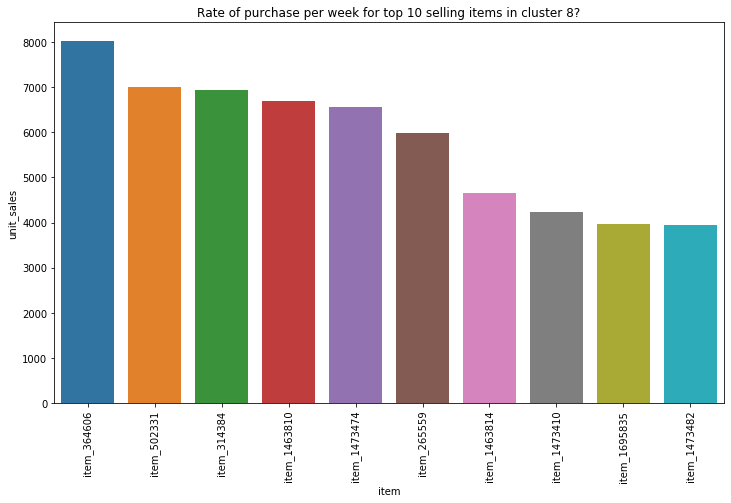

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,7))
sns.barplot(weekly_rateof_purchase.index,weekly_rateof_purchase.unit_sales)
plt.xlabel('item')
plt.xticks(rotation='vertical')
plt.ylabel('unit_sales')
plt.title('Rate of purchase per week for top 10 selling items in cluster 8?')
plt.show()

##### <font color='green'> Answer3: The weekly rate of purchase for the top 10 selling items in cluster 8 is </font>
##### <font color='green'> {item_364606, 8035.712193}; {item_502331, 7000.045482}; {item_314384, 6949.199765}; {item_1463810, 6689.132011}; </font>
##### <font color='green'> {item_1473474, 6552.059288}; {item_265559, 5983.221472}; {item_1463814, 4655.621815}; {item_1473410, 4229.889000} </font>
##### <font color='green'> {item_1695835, 3971.552395}; {item_1473482, 3945.648300} </font>

**Model Building using Time Series models**

##### SARIMAX model based on month

In [0]:
import itertools
p = q = range(0, 4)
d =range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 0, 3, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)


In [0]:
train_last_twoyears=pd.DataFrame(train[((train.year==2017) | (train.year==2018))])
train_last_twoyears.shape

(63094515, 9)

In [0]:
train_last_twoyears.columns

Index(['date', 'locationId', 'item_id', 'unit_sales', 'onpromotion', 'month',
       'day', 'year', 'month_years'],
      dtype='object')

In [0]:
train_last_twoyears=(train_last_twoyears.groupby('month_years')['unit_sales'].sum().reset_index())
train_last_twoyears=train_last_twoyears.set_index('month_years')

In [0]:
train_last_twoyears.head()

,unit_sales
month_years,
2017-01,14896921.0
2017-02,13742395.0
2017-03,15598608.0
2017-04,14955060.0
2017-05,17730364.0


In [0]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_last_twoyears,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:846.3633922177085
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:375.71583613277016
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:406.9904615277017
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:797.8880298152836
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:336.4449042892638
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:435.7616690754351
ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:190798171.44999644
ARIMA(0, 0, 2)x(0, 1, 0, 12)12 - AIC:277.25257004776523
ARIMA(0, 0, 2)x(1, 0, 0, 12)12 - AIC:485.62430156177675
ARIMA(0, 0, 3)x(0, 0, 0, 12)12 - AIC:2245355.7864666544
ARIMA(0, 0, 3)x(0, 1, 0, 12)12 - AIC:nan
ARIMA(0, 0, 3)x(1, 0, 0, 12)12 - AIC:483.75368579890267
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:708.0871411436741
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:332.25072747940914
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:355.6166512964559
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:678.2426175642531
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:298.1504200010245
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:357.11839355693314
ARIMA(0, 1, 2)x(

**ARIMA(1, 1, 2)x(0, 1, 0, 12)12 - AIC:247.8063888631171**

In [0]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(train_last_twoyears, order= (1,1,2), seasonal_order= (0,1,0,12), enforce_stationarity= False,
                                enforce_invertibility= False)

results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         unit_sales   No. Observations:                   24
Model:             SARIMAX(1, 1, 2)x(0, 1, 0, 12)   Log Likelihood                -119.903
Date:                            Wed, 12 Feb 2020   AIC                            247.806
Time:                                    17:01:41   BIC                            248.124
Sample:                                01-31-2017   HQIC                           245.663
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2443      0.742     -0.329      0.742      -1.699       1.210
ma.L1          0.9395      0.050   

In [0]:
residuals = pd.DataFrame(results.resid)

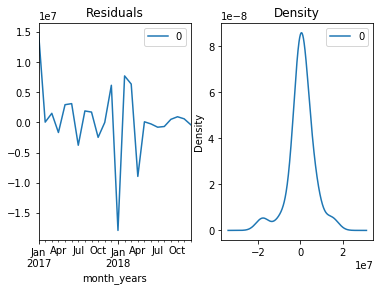

<Figure size 864x864 with 0 Axes>

In [0]:
fig, ax = plt.subplots(1,2)
plt.figure(figsize=(12,12))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

**SARIMAX model based on Week**

In [0]:
os.chdir(r"/content/drive/My Drive/PHD")
train=pd.read_csv('train.csv')

In [0]:
train['date']=pd.to_datetime(train['date'])
train['Week']=train.date.dt.to_period(freq = 'W')
train.head()

,date,locationId,item_id,unit_sales,onpromotion,Week
0,2015-01-01,location_25,item_103665,7.0,NaN,2014-12-29/2015-01-04
1,2015-01-01,location_25,item_105574,1.0,NaN,2014-12-29/2015-01-04
2,2015-01-01,location_25,item_105575,2.0,NaN,2014-12-29/2015-01-04
3,2015-01-01,location_25,item_108079,1.0,NaN,2014-12-29/2015-01-04
4,2015-01-01,location_25,item_108701,1.0,NaN,2014-12-29/2015-01-04


In [0]:
train_last_oneyear=pd.DataFrame(train[(train.date>='2018-01-01')])
train_last_oneyear.shape

(35229871, 6)

In [0]:
train_last_oneyear=(train_last_oneyear.groupby('Week')['unit_sales'].sum().reset_index())
train_last_oneyear=train_last_oneyear.set_index('Week')

In [0]:
train_last_oneyear.head()

,unit_sales
Week,
2018-01-01/2018-01-07,5576298.873
2018-01-08/2018-01-14,5372081.271
2018-01-15/2018-01-21,5321130.353
2018-01-22/2018-01-28,4984633.022
2018-01-29/2018-02-04,5783627.993


In [0]:
import itertools
p = q = range(0, 4)
d =range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 0, 3, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)


In [0]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_last_oneyear,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1763.9001615120055
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1333.885350933861
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1235.9809312513453
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2773.8688907615224
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1266.2744586939803
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1249.8108092495008
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:891.3097550047814
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2739.9854481756006
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:893.0832585207008
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:897.2477922291447
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:532.1888008554376
ARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:1646.0749214952855
ARIMA(0, 0, 0)x(3, 0, 0, 12)12 - AIC:534.1655631007295
ARIMA(0, 0, 0)x(3, 0, 1, 12)12 - AIC:544.731089216227
ARIMA(0, 0, 0)x(3, 1, 0, 12)12 - AIC:164.6217352754984
ARIMA(0, 0, 0)x(3, 1, 1, 12)12 - AIC:158.5282750744779
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1695.6709695008308
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1395.6731453859115
AR

**ARIMA(3, 1, 0)x(3, 1, 0, 12)12 - AIC:43.8863383319909**

In [0]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(train_last_oneyear, order= (3,1,0), seasonal_order= (3,1,0,12), enforce_stationarity= False,
                                enforce_invertibility= False)

results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         unit_sales   No. Observations:                   53
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 12)   Log Likelihood                 -14.943
Date:                            Fri, 21 Feb 2020   AIC                             43.886
Time:                                    16:13:45   BIC                             29.886
Sample:                                01-07-2018   HQIC                              -inf
                                     - 01-06-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2052   1347.089     -0.000      1.000   -2640.452    2640.041
ar.L2          0.0282    255.323   

In [0]:
residuals = pd.DataFrame(results.resid)

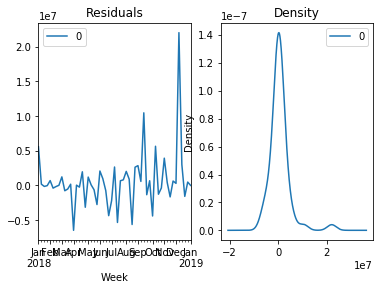

<Figure size 1440x864 with 0 Axes>

In [0]:
fig, ax = plt.subplots(1,2)
plt.figure(figsize=(20,12))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

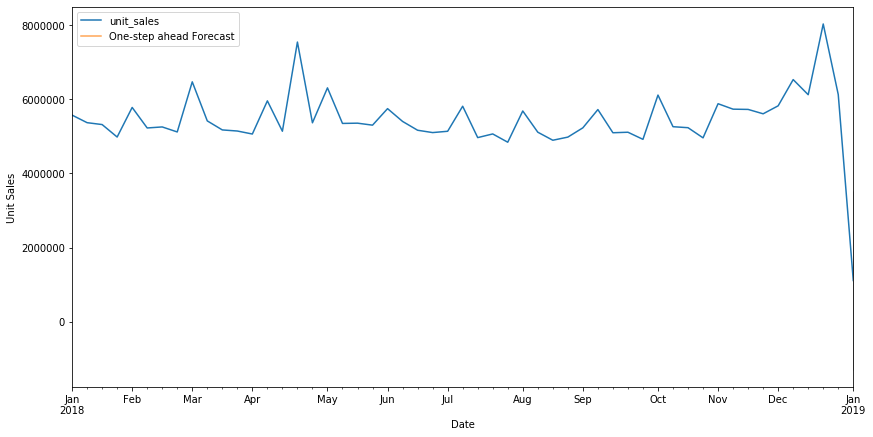

In [0]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = train_last_oneyear['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Unit Sales')
plt.legend()
plt.show()

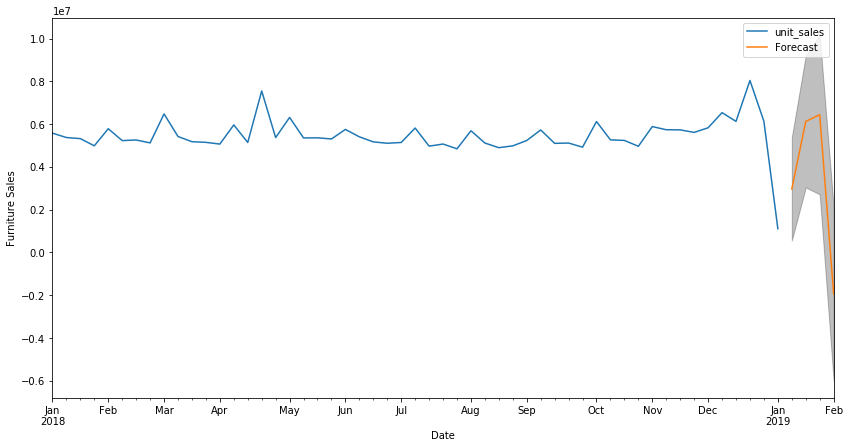

In [0]:
pred_uc = results.get_forecast(steps=4)
pred_ci = pred_uc.conf_int()
ax = train_last_oneyear.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()